In [2]:
import pandas
import os
import itertools
import numpy as np
import nibabel as ni
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from glob import glob
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import model_selection, linear_model
from sklearn import mixture
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score
from nilearn import image, plotting
from sklearn.neighbors import kneighbors_graph
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [3]:
def PCA_LR_pipeline(in_mtx, y, pca = PCA(random_state=123), 
                    clf = linear_model.LassoCV(random_state = 123), 
                    cv_strategy = None, cv = 10, test_gene_num = [100], illustrative = False,
                   sanity_check_style = 'separate', cv_labels = [], reverse_axes = True):
    
    final_outputs = {}
    
    if type(in_mtx) == pandas.core.frame.DataFrame:
        in_mtx = in_mtx.values
    
    if type(pca) == type(None):
        pca_tfm = in_mtx
    else:
        print('running PCA')
        dat_pca = pca.fit(in_mtx)
        print('transforming data')
        pca_tfm = dat_pca.transform(in_mtx)
        #if len(y) != pca_tfm.shape[-1]:
        #    raise ValueError('length of y-axis of transformed item must match the length of y')
        final_outputs.update({'pca_object': dat_pca})
    
    
    print('performing model cross-validation')
    if hasattr(cv_strategy, 'get_n_splits'):
        folds = cv_strategy.get_n_splits(pca_tfm)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, groups=folds, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, groups=folds, cv=cv)
        observed = y
        score = stats.pearsonr(predicted, y)[0]**2
    elif cv_strategy == 'LOLO':
        print('using leave-one-label-out cross-validation')
        observed, predicted = leave_one_x_out(cv_labels, pca_tfm, y, clf)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif cv_strategy == 'balanced':
        print('balancing cross-validation by labels')
        observed, predicted = balanced_cv(cv_labels, pca_tfm, y, clf, cv)
        score = stats.pearsonr(predicted,observed)[0]**2
    elif type(cv_strategy) == int:
        print('using %s iterations of %s-fold cross-validation'%(cv_strategy,cv))
        score = []
        preds = np.zeros((cv_strategy,len(y)))
        for i in range(cv_strategy):
            sel = model_selection.KFold(n_splits=cv, shuffle=True)
            predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=sel)
            preds[i,:] = predicted
            score.append(stats.pearsonr(predicted, y)[0]**2)
            print('completed iteration',i+1)
    elif type(cv_strategy) != type(None):
        print('using basic %s-fold cross-validation'%cv)
        #scores = model_selection.cross_val_score(clf, pca_tfm, y=y, cv=cv)
        predicted = model_selection.cross_val_predict(clf, pca_tfm, y=y, cv=cv)
        observed = y
        try:
            score = stats.pearsonr(predicted, y)[0]**2
        except:
            score = stats.pearsonr(predicted[:,0], y)[0]**2
    else:
        score = None
    if type(score) != type(None):
        if type(score) == list:
            if illustrative:
                plt.close()
                sns.regplot(preds.mean(0), y, fit_reg=False)
                plt.xlabel('Average CV model predicted position along axis')
                plt.ylabel('Actual position along axis')
                plt.show()

                jnk = pandas.DataFrame(index = range(cv_strategy+1), 
                                       columns = ['score','iteration'])
                jnk.loc[:,'iteration'] = list(range(cv_strategy)) + ['mean']
                jnk.loc[:,'score'] = score + [np.mean(score)]
                plt.close()
                sns.factorplot(x='iteration',y='score',data=jnk)
                plt.show()
                print('model cv scores (r2):')
                print(score)
                print('average r2:',np.mean(score))
                final_outputs.update({'CV_scores': score})
        else:        
            if illustrative:
                plt.close()
                sns.regplot(predicted, observed, fit_reg=False)
                plt.xlabel('CV model predicted position along axis')
                plt.ylabel('Actual position along axis')
                plt.show()
            print('model cv score: r2 = ',score)
            final_outputs.update({'CV_scores': score})
    else:
        print('no valid cross-validation method specified')
    
    print('running final model')
    mod = clf.fit(pca_tfm, y)
    if not hasattr(mod,'coef_'):
        raise IOError('right now, this pipeline can only accept clf objects with a coef_ attribute')
    final_outputs.update({'final_model': mod})
    scr = mod.score(pca_tfm, y)
    print('final model fit r2 = ',scr)
    if illustrative:
        plt.close()
        sns.regplot(x=mod.predict(pca_tfm), y=y)
        plt.xlabel('Model predicted position along A-P axis')
        plt.ylabel('Actual position along A-P axis')
        plt.show()
    
    if type(pca) == type(None):
        f_betas = mod.coef_
    else:
        f_betas = back_transform(dat_pca, mod)
    final_outputs.update({'betas': f_betas})
    
    gene_selections = sanity_check(in_mtx, y, f_betas, test_gene_num, 
                                   illustrative, sanity_check_style, reverse_axes)
    final_outputs.update({'gene_selections': gene_selections})
    
    return final_outputs
    
def back_transform(pca_obj, clf_obj):
    return np.dot(pca_obj.components_.T,clf_obj.coef_)

def sanity_check(in_mtx, y, betas, test_gene_num, illustrative, 
                 sanity_check_style, reverse_axes):
    
    if sanity_check_style == 'separate':
        ascores = []
        pscores = []
    else:
        scores = []
    print('running sanity_check')
    try:
        betas = pandas.Series(betas)
    except:
        betas = pandas.Series(betas[:,0])
    outputs = {}
    for num in test_gene_num:
      
        p_chk = betas.sort_values(ascending=False)[:num].index
        a_chk = betas.sort_values(ascending=False)[-num:].index

        pchk_vals = []
        achk_vals = []
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in p_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'model':
                pchk_vals.append(np.mean(np.array(to_avg) * betas.loc[p_chk].values))
            else:
                pchk_vals.append(np.mean(to_avg))
        
        for sample in range(in_mtx.shape[0]):
            to_avg = []
            for gene in a_chk:
                to_avg.append(in_mtx[sample,gene])
            if sanity_check_style == 'separate':
                achk_vals.append(np.mean(to_avg))
            elif sanity_check_style == 'model':
                achk_vals.append(np.mean(np.array(to_avg) * betas.loc[a_chk].values))
            else:
                achk_vals.append(np.mean(to_avg) * -1)

        if sanity_check_style != 'separate':
            chk_vals = np.array(pchk_vals) + np.array(achk_vals)
            
        if sanity_check_style == 'separate':
            pr,pp = stats.pearsonr(pchk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(pchk_vals), y=y, fit_reg=None)
                if reverse_axes:
                    plt.xlabel('expression of anterior direction genes')
                    plt.ylabel('location along hippocampus (anterior = higher)')
                    plt.show()
                    print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))
                else:
                    plt.xlabel('expression of posterior direction genes')
                    plt.ylabel('location along hippocampus (posterior = higher)')
                    plt.show()
                    print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, pr**2, pp))

            ar,ap = stats.pearsonr(achk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(achk_vals), y=y, fit_reg=None)
                if reverse_axes:
                    plt.xlabel('expression of posterior direction genes')
                    plt.ylabel('location along hippocampus (anterior = higher)')
                    plt.show()
                    print('posterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
                else:
                    plt.xlabel('expression of anterior direction genes')
                    plt.ylabel('location along hippocampus (posterior = higher)')
                    plt.show()
                    print('anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(num, ar**2, ap))
            
        else:
            r,p = stats.pearsonr(chk_vals, y)
            if illustrative:
                plt.close()
                sns.regplot(x=np.array(chk_vals), y=y, fit_reg=None)
                plt.xlabel('expression of A-P axis genes')
                if reverse_axes:
                    plt.ylabel('location along hippocampus (anterior = higher)')
                else:
                    plt.ylabel('location along hippocampus (posterior = higher)')
                plt.show()
                print('posterior and anterior %s genes vs. y:  r2 = %s, p = %s \n\n'%(
                                                                                num, r**2, p))
            
        if sanity_check_style == 'separate':
            if reverse_axes:
                ascores.append(pr**2)
                pscores.append(ar**2)
            else:
                ascores.append(ar**2)
                pscores.append(pr**2)
        else:
            scores.append(r**2)
        if reverse_axes:
            outputs.update({'posterior_genes_%s'%num: a_chk}) 
            outputs.update({'anterior_genes_%s'%num: p_chk})
        else:
            outputs.update({'posterior_genes_%s'%num: p_chk}) 
            outputs.update({'anterior_genes_%s'%num: a_chk})
            
    if len(test_gene_num) > 1:
        if sanity_check_style == 'separate':
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(ascores),
                                pandas.Series(pscores)],axis=1)
            jnk.columns = ['num','a','p']

            plt.close()
            fig,(ax1,ax2) = plt.subplots(2, figsize=(8,10))
            sns.factorplot(x='num', y='a', data=jnk, ax=ax1)
            sns.factorplot(x='num', y='p', data=jnk, ax=ax2)
            ax1.set(xlabel = 'Number of posterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            ax2.set(xlabel = 'Number of anterior genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()
        else:
            jnk = pandas.concat([pandas.Series(test_gene_num), 
                                 pandas.Series(scores)
                                ],axis=1)
            jnk.columns = ['num','score']

            plt.close()
            fig,ax1 = plt.subplots(1, figsize=(8,10))
            sns.factorplot(x='num', y='score', data=jnk, ax=ax1)
            ax1.set(xlabel = 'Number of genes', 
                    ylabel ='Explained variance in \nhippocampus a-p gradient')
            plt.show()

    return outputs

def leave_one_x_out(labels, in_X, in_y, clf):

    obsz = []
    predz = []
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for label in np.unique(labels):
        Tr_samps = [i for i in labels if labels[i] != label]
        Te_samps = [i for i in labels if labels[i] == label]
        X = in_X[Tr_samps,:]
        in_y = y.iloc[Tr_samps]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[Te_samps,:])
        for x in range(len(pred)):
            obsz.append(y.values[x])
            predz.append(pred[x])
    
    return obsz, predz

def balanced_cv(labels, in_X, in_y, clf, cv):
    
    obsz = []
    predz = []
    tst = model_selection.StratifiedKFold(n_splits=cv, random_state=123)
    label_map = dict(zip(labels.unique(), range(len(labels.unique()))))
    labels = [label_map[x] for x in labels]
    for tr_idx, te_idx in tst.split(in_X, labels):
        X = in_X[tr_idx,:]
        y = in_y.loc[tr_idx]
        mod = clf.fit(X,y)
        pred = mod.predict(in_X[te_idx,:])
        for i in range(len(predz)):
            obsz.append(y.values[x])
            predz.append(pred[i])
            
    return obsz, predz

In [4]:
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

In [5]:
def make_sphere(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [6]:
def run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 5, vdim = 1,
                                  in_imgs = [], bootstrap = False, n_iter = 100,
                                   hue_vals=[], return_results=False, return_vectors = False,
                                   illustrative=True):
    
    if len(in_imgs) == 0:
        a_idx = df.loc[[x for x in df.index if df.loc[x,ycol] < ant_cut]].index
        p_idx = df.loc[[x for x in df.index if df.loc[x,ycol] > post_cut]].index
        print('%s maps used for posterior, %s used for anterior'%(len(p_idx),len(a_idx)))
        print('\n')
        print('processing anterior image')
        aimg = make_mean_img(df.loc[a_idx,ccol].tolist(),wdir,del_img, 'ant')
        print('processing posterior image')
        pimg = make_mean_img(df.loc[p_idx,ccol].tolist(),wdir,del_img,'post')
    
        if diff_img:
            print('running analysis')
            diff_img = pimg - aimg
            res, vectors = run_gvfcx_analysis(diff_img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
        else:
            print('running posterior analysis')
            res, vectors = run_gvfcx_analysis(pimg, gdf, msk, vrad, vdim, gcx_col,  plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
            print('running anterior analysis')
            res, vectors = run_gvfcx_analysis(aimg, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
    else:
        if diff_img:
            diff_img = ni.load(in_imgs[1]).get_data() - ni.load(in_imgs[0]).get_data()
            res, vectors = run_gvfcx_analysis(diff_img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                     bootstrap, n_iter, hue_vals, illustrative)
        else:
            for img in in_imgs:
                print('running analysis for image',img)
                dat = ni.load(img).get_data()
                res, vectors = run_gvfcx_analysis(dat, gdf, msk, vrad, vdim, gcx_col, plabs, 
                                         bootstrap, hue_vals, illustrative)
    
    if return_results and return_vectors:
        return res, vectors
    elif return_results and not return_vectors:
        return res
    elif return_vectors and not return_results:
        return vectors
    
def make_mean_img(scans, wdir, del_img, lab):
    
    print('making mean image')
    img = ni.concat_images(scans)
    x,y,z,q,t = img.shape
    mat = img.get_data().reshape(x,y,z,t)
    mimg = ni.Nifti1Image(mat.mean(axis=3),img.affine)
    fnm = os.path.join(wdir,'del_%s_img.nii'%lab)
    mimg.to_filename(fnm)
    
    print('moving to template space')
    #mni = '/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii'
    mni = '/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii'
    #tfm = '/Users/jakevogel/Science/AHBA/cx_maps/2_to_1_mm_tfm'
    tfm = '/home/users/jvogel/Science/templates/tfms/2_to_1mm_MNI.tfm'
    nfnm = os.path.join(wdir,'%s_img.nii'%lab)
    #os.system('flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.system('fsl5.0-flirt -in %s -ref %s -applyxfm -init %s -out %s'%(fnm,mni,tfm,nfnm))
    os.remove(fnm)
    nfnm = nfnm+'.gz'
    fimg = ni.load(nfnm).get_data()
    if del_img:
        os.remove(nfnm)
    
    return fimg

def run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs,
                       bootstrap, n_iter, hue_vals, illustrative):
    
    if type(vrad) != list:
        vrad = [vrad]
    res = pandas.DataFrame(index=vrad,columns=['r2','p'])
    for vs in vrad:
        g_cx = []
        f_cx = []
        if len(hue_vals) > 0:
            hvs = []

        for i,row in gdf.iterrows():
            #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
            coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 
                                   'xyz', vdim)
            coord = [round(x) for x in coord]
            if msk[coord[0],coord[1],coord[2]] != 0:
                xs,ys,zs = make_sphere(coord, vs)
                val = img[xs,ys,zs]
                f_cx.append(val.mean())
                g_cx.append(row[gcx_col])
                if len(hue_vals) > 0:
                    hvs.append(hue_vals[i])

        if len(hue_vals) == 0:
            if illustrative:
                plt.close()
                sns.regplot(np.array(g_cx), np.array(f_cx))
                plt.title(plabs[0])
                plt.xlabel(plabs[1])
                plt.ylabel(plabs[2])
                plt.show()
        else:
            if illustrative:
                jnk = pandas.DataFrame(index=range(len(g_cx)),columns = plabs[1:])
                jnk.loc[:,plabs[1]] = g_cx
                jnk.loc[:,plabs[2]] = f_cx
                jnk.loc[:,'sample expression cluster'] = hvs
                sns.lmplot(x=plabs[1],y=plabs[2],hue='sample expression cluster',data=jnk)
                plt.show()

        r, p = stats.pearsonr(np.array(g_cx), np.array(f_cx))
        print('standard statistics: r2 = %s, p = %s'%(r**2,p))
        res.loc[vs,['r2','p']] = [r**2,p]
        
        vectors = {'g_vector': g_cx, 'cx_vector': f_cx}
        
        if bootstrap == 'permute':
            distr = []
            for i in range(n_iter):
                distr.append(stats.pearsonr(np.random.permutation(np.array(g_cx)),
                                            np.array(f_cx)
                                           )[0]**2)
            distr = np.array(distr)
            p = (n_iter - len(distr[distr<r**2])) * (1/n_iter)
            ci_l = sorted(distr)[int(n_iter*0.05)]
            ci_u = sorted(distr)[int(n_iter*0.95)]
            mn = np.mean(distr)
            print('Occurence greater than chance: p = %s (chance r2 = %s [%s,%s])'%(
                                                                p, mn, ci_l, ci_u))
            res.loc[vs,'manual_FDR'] = p
            res.loc[vs,'chance_r2'] = mn
            res.loc[vs,'ci_l'] = ci_l
            res.loc[vs,'ci_u'] = ci_u

        elif bootstrap == 'bootstrap':
            # NEED TO MAKE THIS FASTER SO I CAN DO IT AT LEAST 100 TIMES.
            # AS OF NOW, IT TAKES LIKE >15 seconds to run 1
            distr = []
            for n in range(n_iter):
                r_cx = []
                possible_coords = np.where(msk!=0)
                rand_coords = np.random.permutation(range(len(possible_coords[0])))[:len(g_cx)]
                for i in rand_coords:
                    rand_coord = [possible_coords[0][i], 
                                  possible_coords[1][i], 
                                  possible_coords[2][i]]
                    xs,ys,zs = make_sphere(rand_coord, vs)
                    r_cx.append(img[xs,ys,zs].mean())
                distr.append(stats.pearsonr(np.array(g_cx), np.array(r_cx))[0]**2)
            distr = np.array(distr)
            p = (n_iter - len(distr[distr<r**2])) * (1/n_iter)
            ci_l = sorted(distr)[int(n_iter*0.05)]
            ci_u = sorted(distr)[int(n_iter*0.95)]
            mn = np.mean(distr)
            print('Occurence greater than chance: p = %s (chance r2 = %s [%s,%s])'%(
                                                                p, mn, ci_l, ci_u))
            res.loc[vs,'manual_FDR'] = p
            res.loc[vs,'chance_r2'] = mn
            res.loc[vs,'ci_l'] = ci_l
            res.loc[vs,'ci_u'] = ci_u

    return res, vectors

In [7]:
def make_expression_image(vector, coords, projection_space, 
                          wdir = './', nm = 'gene', vrad=5,
                         return_img = False):
    if len(vector) != len(coords):
        print('input and coordinate vectors must have the same length')
    if type(projection_space) == str:
        jnk = ni.load(projection_space)
        aff = jnk.affine
        dat = jnk.get_data()
    else:
        try:
            aff = projection_space.affine
            dat = projection_space.get_data()
        except:
            raise IOError('projection_space must be a NiftiImage object or path to .nii file')
    nimg = np.zeros_like(dat).astype(float)
    for i in range(len(vector)):
        xs,ys,zs = make_sphere(coords[i], vrad)
        nimg[xs,ys,zs] = vector[i]
    nimg = ni.Nifti1Image(nimg,aff)
    flnm = os.path.join(wdir,'%s_xp_image.nii.gz'%nm)
    nimg.to_filename(flnm)
    
    if return_img:
        return nimg

In [8]:
def find_closest_point_along_axis(coords,skel_coords):
    closest_coords = []
    y_coord = []
    for coord in skel_coords:
        dists = []
        for i in range(len(skel_coords[0])):
            dist = sum([abs(skel_coords[0][i] - coord[0]), 
                        abs(skel_coords[1][i] - coord[1]), 
                        abs(skel_coords[2][i] - coord[2])])
            dists.append(dist)
        gind = np.argmin(dists)
        closest_coords.append([skel_coords[0][gind],
                               skel_coords[1][gind],
                                skel_coords[2][gind]])
        y_coord.append(skel_coords[1][gind])

    return y_coord, closest_coords

In [9]:
def label_coordinate_by_atlas(atlas, coordinates, cube_size = 1):
    ''' This function will take a set of coordinates and an atlas and return the
    atlas label for each coordinate. Optionally, a cube can be drawn around the 
    coordinate. In this case, the most frequent non-zero value inside the cube will 
    be selected as the label. The function will output a pandas dataframe with a
    label for each input coordinate.
    
    atlas can be a path to a nifti image, or a nifti object, or a 3D np.ndarray
    
    coordinates can be a pandas Dataframe, a numpy.ndarray or a list of lists, 
    representing the mni coordinates for each input corrdinate. as such, the 
    length of one of the dimensions should be 3
    
    cube_size represents the radius of the cube to be created. leaving it as 1 will
    only retrieve the value at the coordinate specified. Increasing the value will 
    draw a cube of increasing size and collect values from within the cube. The most
    frequent non-zero value within the cube will be selected
    
    '''
    
    # initiate and check inputs
    atl, coords = init_and_chk_inputs(atlas,coordinates)
    
    # convert coordinates to xyz space
    xyz = np.array([convert_coords(coords[x],'xyz') for x in range(coords.shape[0])
                   ]).astype(int)
    
    # create output container
    results = pandas.DataFrame(index=range(coords.shape[0]),columns = ['Label'])
    
    # get labels for each coordinate
    print('extracting labels')
    if cube_size == 1:
        results.loc[:,'Label'] = atl[xyz[:,0].tolist(),xyz[:,1].tolist(),xyz[:,2].tolist()]
    else:
        labs = []
        for i in range(xyz.shape[0]):
            labs.append(extract_value_from_cube(xyz[i,:], cube_size, atl))
        results.loc[:,'Label'] = labs
    
    print('completed')
    print('%s coordinates were outside of the provided atlas'%(
                                            len(results[results.Label==0])))

    return results
    
def init_and_chk_inputs(atlas,coordinates):
    print('checking and initializing inputs')
    if type(atlas) == str:
        atl = ni.load(atlas).get_data()
    elif type(atlas) == ni.nifti1.Nifti1Image: 
        atl = atlas.get_data()
    elif type(atlas) == np.core.memmap.memmap or type(atlas) == np.ndarray:
        atl = atlas
    else:
        raise IOError('atlas must be a nifti object, a numpy array or a path to a nifti file')
    
    if type(coordinates) == pandas.core.frame.DataFrame:
        coords = coordinates.values
       
    elif type(coordinates) == list or type(coordinates) == tuple:
        if len(coordinates)== 3:
            coords = np.zeros((len(coordinates[0]),3))
            for i in range(3):
                coords[:,i] = coords[i]
    elif type(coordinates) == np.ndarray:
        coords = coordinates
    else:
        raise IOError('coordiantes must be a pandas dataframe, numpy array or list of lists')
    
    if not any(x==3 for x in coords.shape):
        raise IOError('Coordinates are 3D and thus 3 columns are expected...')
    elif coords.shape[-1] != 3:
        coords = coords.T
    
    coords = coords.round()
    
    return atl,coords
    
def convert_coords(coord, to_what = 'mni', vs = 1):
    origin = [90, 126, 72]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

def extract_value_from_cube(coord, radius, atl):
    
    xs,ys,zs = make_cube(coord, radius)
    cube_vals = atl[xs,ys,zs]
    if stats.mode(cube_vals)[0][0] == 0:
        if len(cube_vals[cube_vals!=0]) > 0:
            lab = stats.mode(cube_vals[cube_vals!=0])[0][0]
        else:
            lab = 0
    else:
        lab = stats.mode(cube_vals)[0][0]
    
    return lab
        
def make_cube(coord, radius):
    summers = []
    negrad = (radius*-1)+1
    for x in itertools.product(range(negrad,radius),repeat=3):
        summers.append(np.array(x))
    s_coords = [np.array(coord) + x for x in summers]
    xs = [int(x[0]) for x in s_coords]
    ys = [int(x[1]) for x in s_coords]
    zs = [int(x[2]) for x in s_coords]
    
    return xs, ys, zs

In [11]:
def get_gene_vector(bigdf, gene_vec = [], probe_ids = [], betas = []):

    if len(gene_vec) == 0 and len(probe_ids) == 0:
        raise IOError('please supply either a gene vector or probe IDs')
    if len(gene_vec) > 0 and len(probe_ids) > 0:
        raise IOError('please supply either a gene vector or probe IDs, but NOT BOTH!')
    #if type(clf) != type(None) and len(probe_ids) == 0:
    #   raise IOError('must pass probe_ids with clf')
    if len(betas) == 0 and len(probe_ids==0):
        raise IOError('please supply probe_ids along with the betas argument')
        
    if len(gene_vec) > 0:
        gene_vec = np.array(gene_vec)
        vals = []
        for i in range(bigdf.shape[-1]):
            try:
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
            except:
                bigdf.columns = ['col_%s'%x for x in range(bigdf.shape[-1])]
                vals.append(stats.pearsonr(gene_vec,
                                        bigdf.loc[:,bigdf.columns[i]])[0])
    elif len(probe_ids) > 0:
        #if type(clf) == type(None):
        if len(betas) == 0:
            vals = bigdf.loc[probe_ids].mean().values
        else:
            X = bigdf.loc[probe_ids].values.T
            vals = np.dot(X,betas)
        #    vals = clf.predict(X)
    return vals

# Get hippocampus samples

In [12]:
wdir = '/data1/users/jvogel/Allen_Human_Brain_Atlas/'
#df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
df =  pandas.read_csv(os.path.join(wdir,'MAIN_ALLVAR_hippocampus_sample_info.csv'), index_col=0)
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
#gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv'))
probes = pandas.read_csv(os.path.join(wdir,'normalized_microarray_donor9861/Probes.csv'))

In [312]:
# PERSONAL COMPUTER
wdir = '/Users/jakevogel/Science/AHBA/'
df = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_sample_info.csv'))
xp = pandas.read_csv(os.path.join(wdir,'MAIN_hippocampus_gxp.csv'),index_col=0)
gdf = pandas.read_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'))
probes = pandas.read_csv('/Users/jakevogel/Downloads/normalized_microarray_donor9861/Probes.csv')

# Run main analysis pipeline and evaluate

In [203]:
1e3

1000.0

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


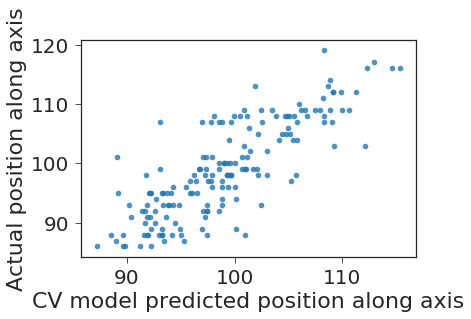

model cv score: r2 =  0.675885977482
running final model
final model fit r2 =  0.876810509326


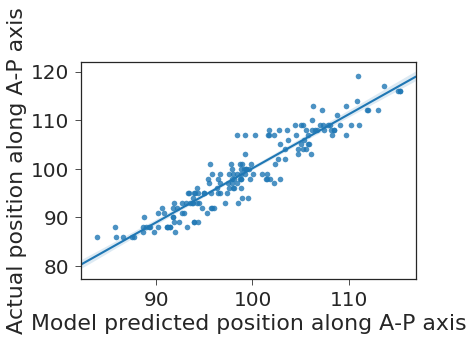

running sanity_check


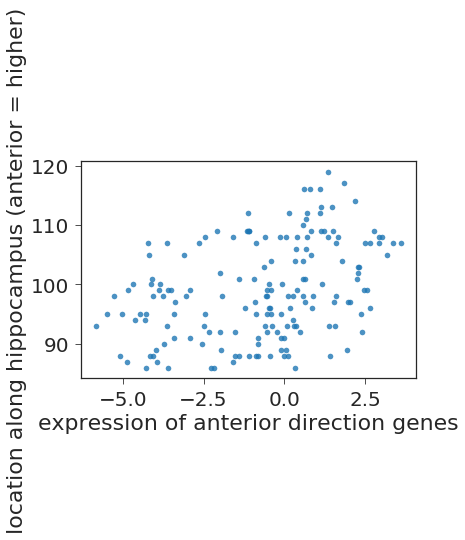

anterior 1 genes vs. y:  r2 = 0.146291960145, p = 2.64362300167e-07 




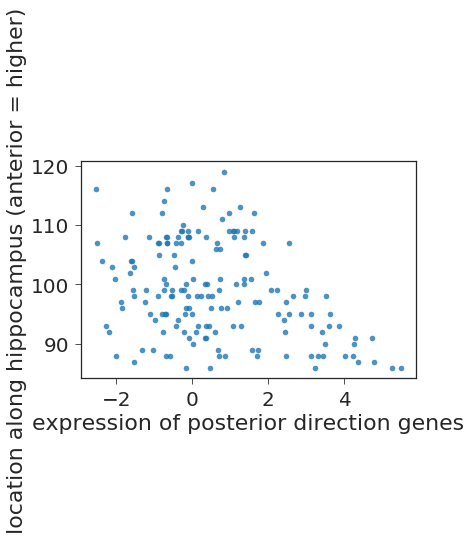

posterior 1 genes vs. y:  r2 = 0.120839023188, p = 3.40674823134e-06 




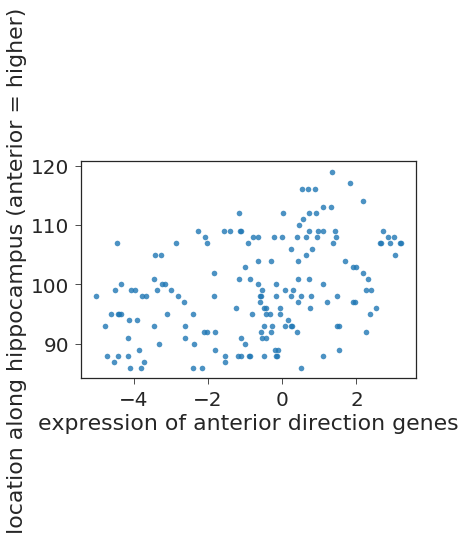

anterior 2 genes vs. y:  r2 = 0.156810463199, p = 9.03376115525e-08 




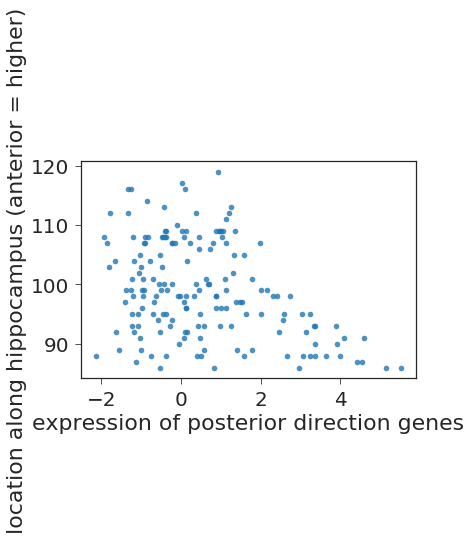

posterior 2 genes vs. y:  r2 = 0.140782455333, p = 4.61980605763e-07 




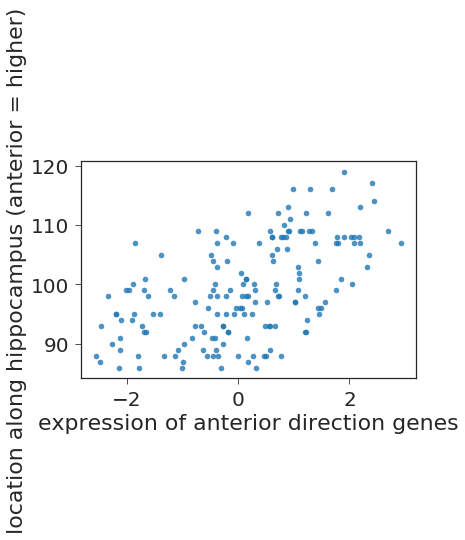

anterior 5 genes vs. y:  r2 = 0.312027641285, p = 2.46628262071e-15 




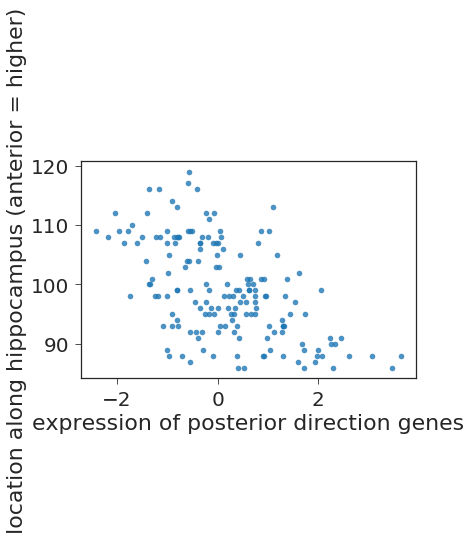

posterior 5 genes vs. y:  r2 = 0.308872084395, p = 3.6401288821e-15 




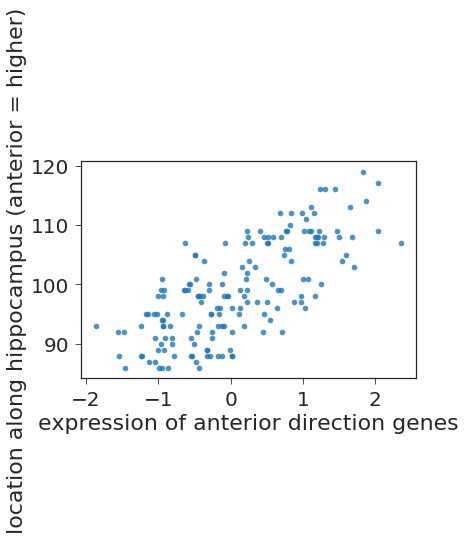

anterior 10 genes vs. y:  r2 = 0.541743338152, p = 2.83625582234e-30 




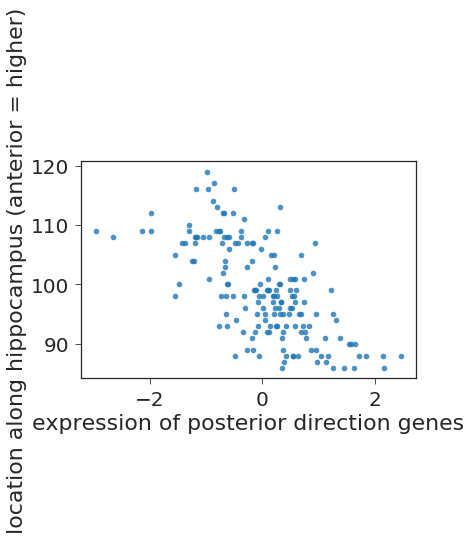

posterior 10 genes vs. y:  r2 = 0.45513306654, p = 6.38206163432e-24 




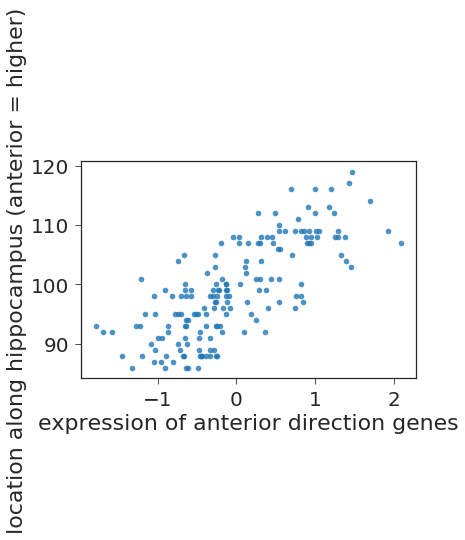

anterior 20 genes vs. y:  r2 = 0.577277974194, p = 3.12395740458e-33 




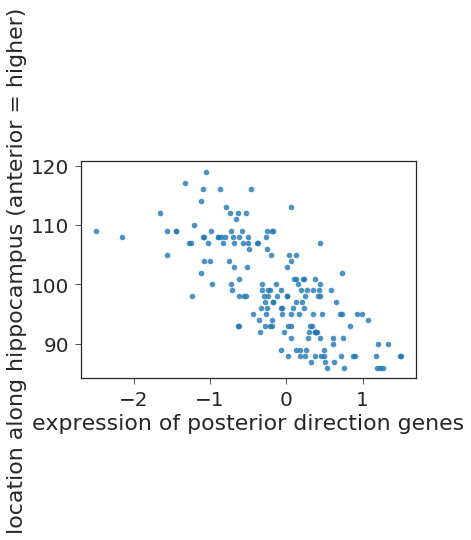

posterior 20 genes vs. y:  r2 = 0.528759540293, p = 3.00011527119e-29 




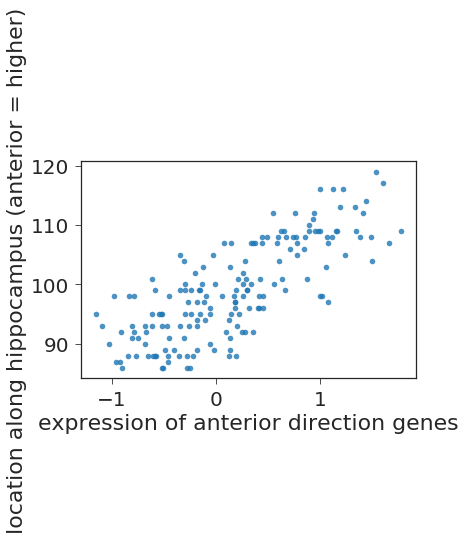

anterior 50 genes vs. y:  r2 = 0.604781566638, p = 1.07277863382e-35 




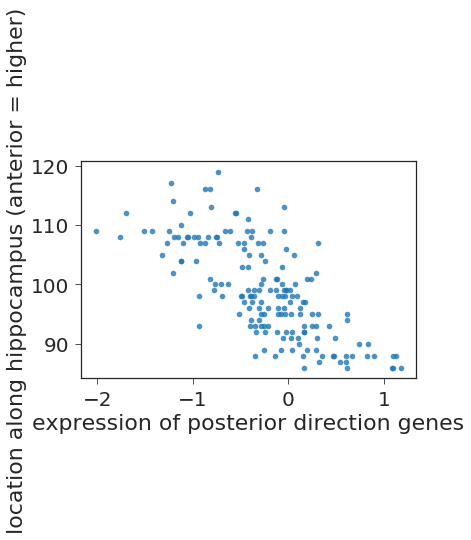

posterior 50 genes vs. y:  r2 = 0.521495808996, p = 1.09169856187e-28 




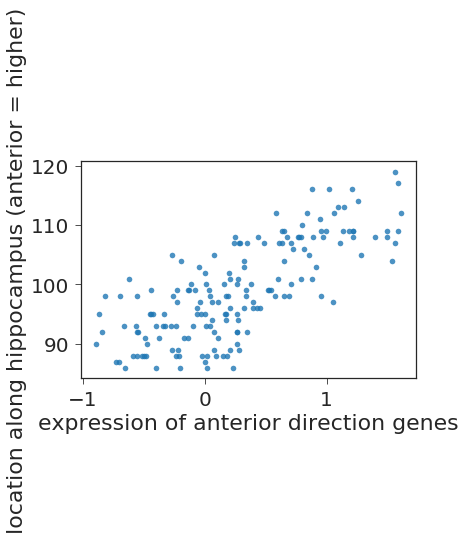

anterior 100 genes vs. y:  r2 = 0.568535370196, p = 1.75686862748e-32 




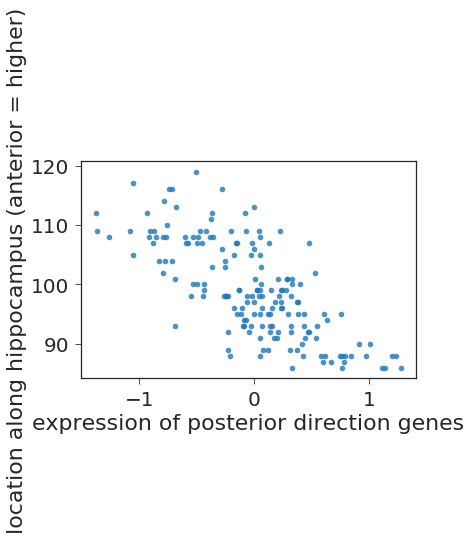

posterior 100 genes vs. y:  r2 = 0.530569444547, p = 2.16785299609e-29 




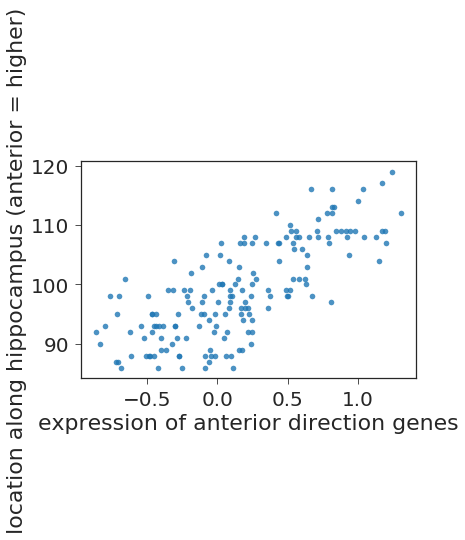

anterior 200 genes vs. y:  r2 = 0.573989954195, p = 6.00589222139e-33 




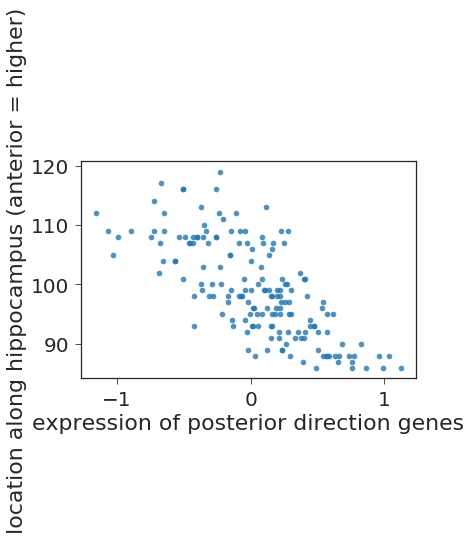

posterior 200 genes vs. y:  r2 = 0.530012749169, p = 2.396015094e-29 




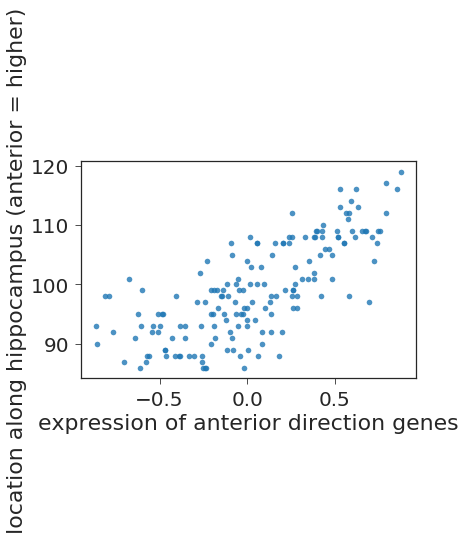

anterior 500 genes vs. y:  r2 = 0.561315373964, p = 7.1262999131e-32 




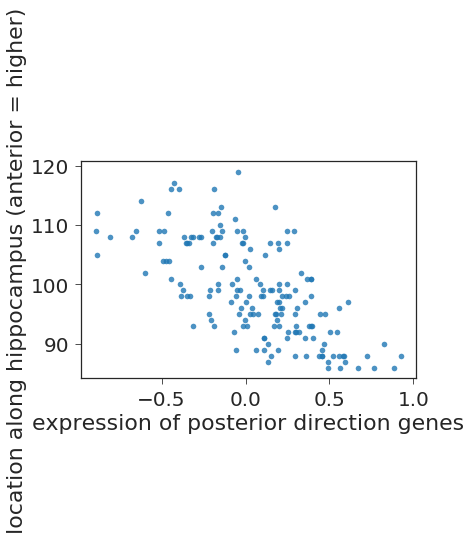

posterior 500 genes vs. y:  r2 = 0.456701046713, p = 5.00149396762e-24 




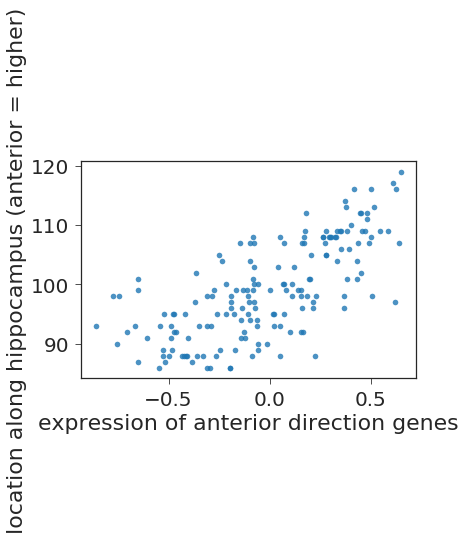

anterior 1000 genes vs. y:  r2 = 0.506219222541, p = 1.5519698984e-27 




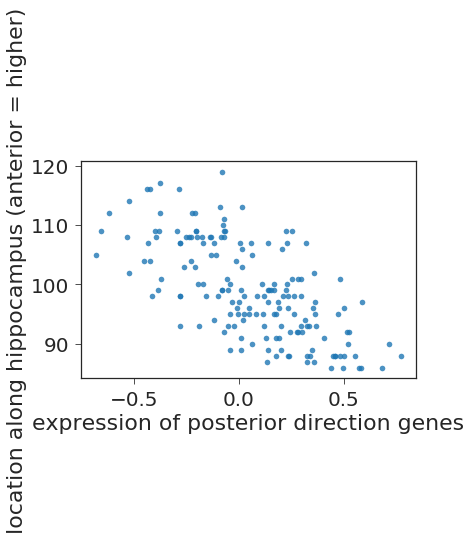

posterior 1000 genes vs. y:  r2 = 0.454418293527, p = 7.13048262374e-24 




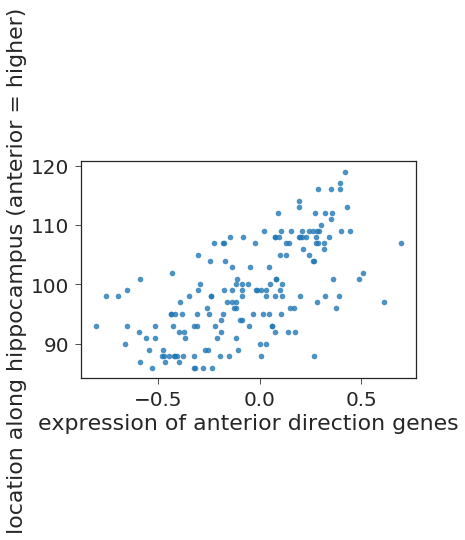

anterior 2000 genes vs. y:  r2 = 0.413582900724, p = 3.20747873988e-21 




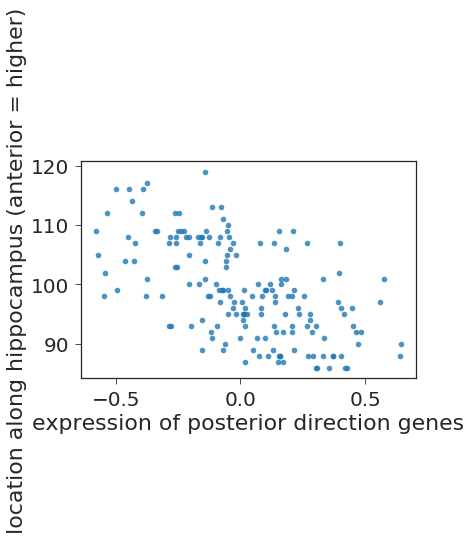

posterior 2000 genes vs. y:  r2 = 0.348659261806, p = 2.35874690133e-17 




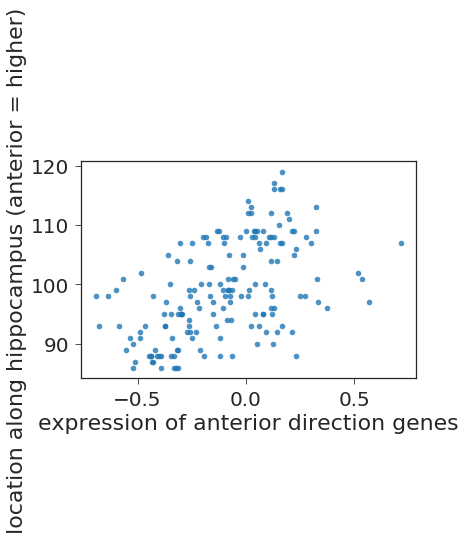

anterior 5000 genes vs. y:  r2 = 0.260250683548, p = 1.19416253845e-12 




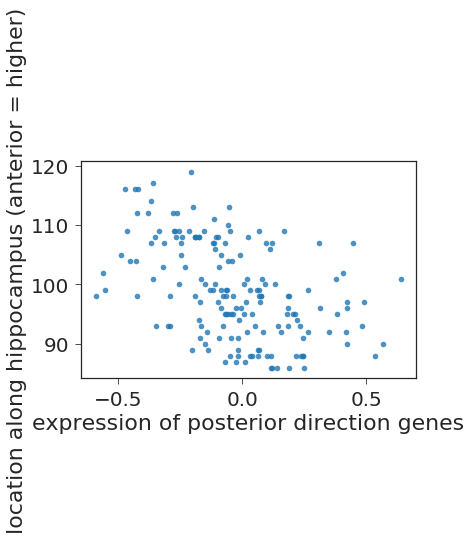

posterior 5000 genes vs. y:  r2 = 0.227039856261, p = 5.09894187119e-11 




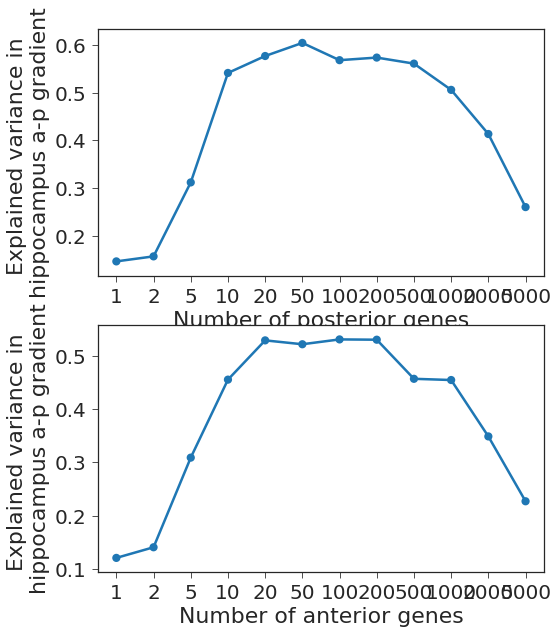

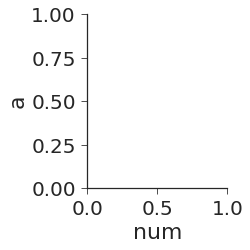

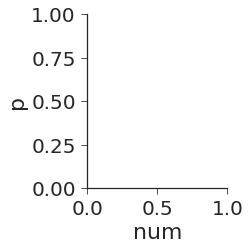

In [773]:
pcalr_out_NEW = PCA_LR_pipeline(xp.values.T, 
                            (df.position_along_hipp_AP_axis), 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [1, 2, 5, 10, 20, 50, 100, 
                                            200, 500, 1000, 2000, 5000],
                               sanity_check_style = 'separate')

# Whole brain stuff

In [188]:
gcx_SPCR = get_gene_vector(bigdf, gene_vec=pcalr_out_NEW['betas'])

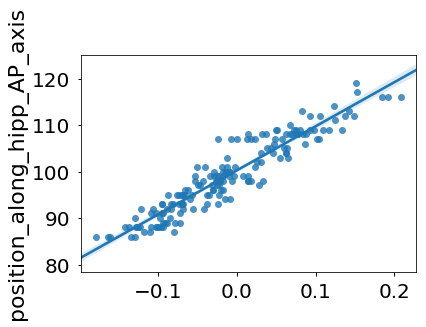

(0.94247801328481062, 7.277902789041337e-82)


In [211]:
rs = []
for i,samp in enumerate(xp.columns):
    svec = xp[samp]
    refvec = pcalr_out_NEW['betas']
    r,p = stats.pearsonr(svec,refvec)
    rs.append(r)
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(stats.pearsonr(np.array(rs),df.position_along_hipp_AP_axis))

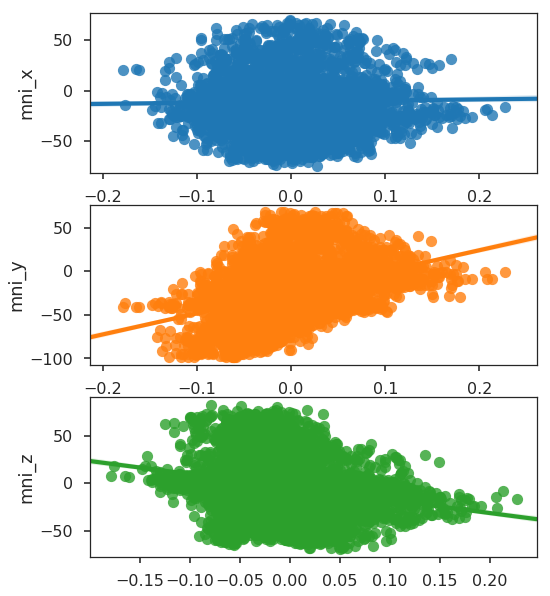

0.000534885864914
0.168072211755
0.0608717979577


In [193]:
# OLD COORDINATES
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_z, ax=ax3)
plt.show()
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_x)[0]**2)
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_y)[0]**2)
print(stats.pearsonr(np.array(gcx_SPCR), gdf.mni_z)[0]**2)

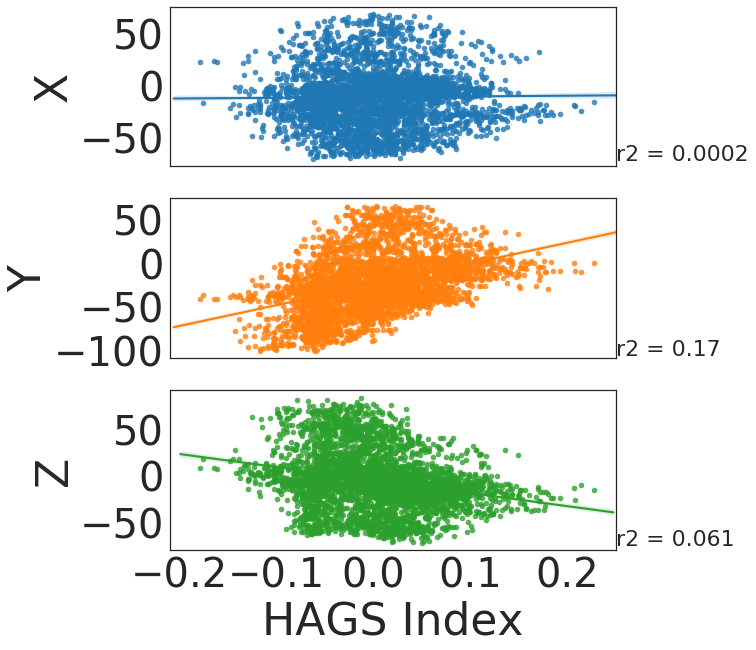

In [587]:
# NEW COORDINATES
sns.set_context('paper',font_scale=5)
gcx_SPCR = gdf.AP_axis_gxp_signature_similarity_SPCR.values
plt.close()
fig,(ax1, ax2, ax3) = plt.subplots(3, figsize=(8,10))
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_x, ax=ax1)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_y, ax=ax2)
sns.regplot(np.array(gcx_SPCR), gdf.mni_nlin_z, ax=ax3)
plt.xlabel('HAGS Index')
#ax1.set(ylabel='MNI X\nCoordinate')
ax1.set(ylabel='X')
ax1.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax1.set(xlim=(-0.21, 0.25))
ax1.set(xticklabels=['','','','',''])
#ax2.set(ylabel='MNI Y\nCoordinate')
ax2.set(ylabel='Y')
ax2.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax2.set(xlim=(-0.21, 0.25))
ax2.set(yticks=[-100,-50,0,50])
ax2.set(xticklabels=['','','','',''])
#ax3.set(ylabel='MNI Z\nCoordinate')
ax3.set(ylabel='Z')
ax3.set(xticks=[-0.2,-0.1,0,0.1,0.2])
ax3.set(xlim=(-0.21, 0.25))

xr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_x)[0]**2
yr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_y)[0]**2
zr = stats.pearsonr(np.array(gcx_SPCR), gdf.mni_nlin_z)[0]**2
#plt.text(0.11, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 340,'r2 = %s'%float('%.2g'%xr), fontsize=22)
plt.text(0.25, 130,'r2 = %s'%float('%.2g'%yr), fontsize=22)
plt.text(0.25, -75,'r2 = %s'%float('%.2g'%zr), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/XYZ_plots_revised.pdf',
           bbox_inches='tight')
plt.show()


In [196]:
gdf.loc[:,'AP_axis_gxp_signature_similarity_SPCR'] = gcx_SPCR

In [207]:
#gdf.drop(gdf.columns[16:27],axis=1,inplace=True)

In [38]:
gdf.to_csv(os.path.join(wdir,'MAIN_gcx_wholebrain_info.csv'),index=False)

In [160]:
vec = gdf.AP_axis_gxp_signature_similarity_SPCR.values
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'MAIN_SPCR_nlin_rev'
gcx_img = make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)

In [222]:
jnk = gcx_img.get_data()
len(jnk[jnk!=0])

299344

In [137]:
trivec = [-1 if x < -0.05 else 1 if x > 0.05 else 0 \
       for x in gdf.AP_axis_gxp_signature_similarity_SPCR]
gdf.loc[:,'AP_division'] = trivec
for div in gdf.AP_division.unique():
    print(div, len(gdf[gdf.AP_division==div]))
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
nm = 'AP_division'
gcx_img = make_expression_image(trivec, input_coords, mni, wdir, nm, 3, return_img=True)

0 2262
1 699
-1 741


In [138]:
univec = [1 if x==0 else 0 for x in gdf.AP_division]
gdf.loc[:,'no_assoc'] = univec
nm = 'unassociated'
gcx_img = make_expression_image(univec, input_coords, mni, wdir, nm, 3, return_img=True)

In [154]:
regs = pandas.DataFrame(index=gdf.structure_acronym.unique(),
                       columns = ['N_samples','N_Ant','N_Post'])
for structure in regs.index.tolist():
    regs.loc[structure,'N_samples'] = len(gdf[gdf.structure_acronym==structure])
    regs.loc[structure,'N_Ant'] = len(gdf[(gdf.structure_acronym==structure
                                   ) & (gdf.AP_division==1)])
    regs.loc[structure,'N_Post'] = len(gdf[(gdf.structure_acronym==structure
                                   ) & (gdf.AP_division==-1)])
    regs.loc[structure,'Name'] = gdf[gdf.structure_acronym==structure]['structure_name'].values[0]

In [155]:
regs.loc[:,'perc_Ant'] = regs.N_Ant/regs.N_samples
regs.loc[:,'perc_Post'] = regs.N_Post/regs.N_samples

In [157]:
regs.sort_values('perc_Post',ascending=False)

N_samples N_Ant N_Post  \
He-VIIIB           7     0      7   
Cun-str           19     0     19   
OPl                1     0      1   
OPs                1     0      1   
OPi                1     0      1   
Ve-VIIAf           5     0      5   
LiG-str           33     0     31   
He-V              10     0      9   
PV-III             8     0      7   
He-VIIIA          15     0     13   
Ve-IX              7     0      6   
Ve-VI              7     0      6   
Ve-VIIIA           7     0      6   
PV-Crus II        12     0     10   
He-X               5     0      4   
Ve-X               5     0      4   
Ve-I-II            5     0      4   
PV-VIIB           14     0     11   
He-VI             18     0     14   
He-III             4     0      3   
PV-IV             12     0      9   
Ve-V               8     0      6   
PoG-cs            26     0     19   
Ve-VIIIB           7     0      5   
PV-VI             14     0     10   
Ve-VIIB            7     0      5   
PV-V              14     0     10   
Ve-IV              7     0      5   
He-VIIB           17     0     12   
LGd               17     0     12   
...              ...   ...    ...   
SNR               24    10      0   
3                  6     1      0   
EW                 3     0      0   
SC                 7     0      0   
PTec               4     1      0   
RN                16     1      0   
Dk                 2     0      0   
ICjl               3     0      0   
IC                 7     0      0   
4                  6     0      0   
SubC              12     6      0   
Mo5               10     0      0   
trIFG             18     1      0   
Pr5                9     0      0   
FuG-l             23    14      0   
FuG-its           28    15      0   
PTG                1     1      0   
Acb               17     3      0   
PHG-l             31    21      0   
PHG-cos           27    20      0   
FuG-cos           25    19      0   
PLP               21    12      0   
MPB               12     7      0   
LPB                9     6      0   
LC                13     7      0   
PRF               24     3      0   
MBRa              12     9      0   
CGMB              26    18      0   
CGPo               4     4      0   
MBRF               4     3      0   

                                                         Name   perc_Ant  \
He-VIIIB                      VIIIB, left, lateral hemisphere          0   
Cun-str                                cuneus, right, striate          0   
OPl                      occipital pole, left, lateral aspect          0   
OPs                     occipital pole, left, superior aspect          0   
OPi                     occipital pole, left, inferior aspect          0   
Ve-VIIAf                                                VIIAf          0   
LiG-str                          lingual gyrus, left, striate          0   
He-V                              V, left, lateral hemisphere          0   
PV-III                                  III, left, paravermis          0   
He-VIIIA                     VIIIA, right, lateral hemisphere          0   
Ve-IX                                                      IX          0   
Ve-VI                                                      VI          0   
Ve-VIIIA                                                VIIIA          0   
PV-Crus II                         Crus II, right, paravermis          0   
He-X                              X, left, lateral hemisphere          0   
Ve-X                                                        X          0   
Ve-I-II                                                  I-II          0   
PV-VIIB                               VIIB, right, paravermis          0   
He-VI                            VI, left, lateral hemisphere          0   
He-III                          III, left, lateral hemisphere          0   
PV-IV                                   IV, right, paravermis          0   
Ve-V                                        

# Resting-state analysis

In [208]:
plt.close()
sns.regplot(np.array(rs),df.position_along_hipp_AP_axis)
plt.show()
print(min(df.position_along_hipp_AP_axis))
print(max(df.position_along_hipp_AP_axis))

NameError: name 'rs' is not defined

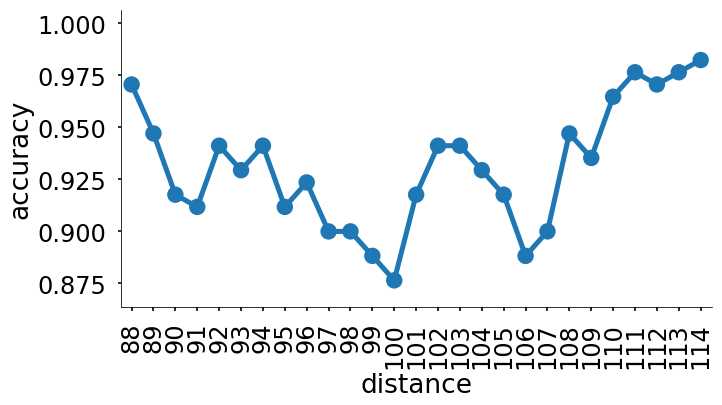

In [232]:
d_classifiers = pandas.DataFrame(index = range(88,115), columns = ['accuracy'])
for i in range(88,115):
    classes = [0 if x < i else 1 for x in df.position_along_hipp_AP_axis]
    tmod = linear_model.LogisticRegressionCV().fit(np.array(rs).reshape(-1,1),classes)
    scr = tmod.score(np.array(rs).reshape(-1,1),classes)
    d_classifiers.loc[i,'accuracy'] = scr
d_classifiers.loc[:,'distance'] = d_classifiers.index

plt.close()
sns.set_context('poster', font_scale=1.5)
g = sns.factorplot(x='distance', y='accuracy', data=d_classifiers, size=6, aspect=1.8)
g.set_xticklabels(rotation=90)
plt.plot([94, 94], [0.87, 1], 'r--', linewidth=2)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/fmri_cutpoints.pdf',
           bbox_inches='tight')
plt.show()

In [290]:
cx_scans

[]

In [14]:
cx_scans = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/*.nii.gz'))
scoords = [[int(x[-3]),int(x[-2]),int(x[-1].split('.')[0])
           ] for x in [y.split('_') for y in cx_scans]]
for i,row in df.iterrows():
    c = [row['mni_nlin_x'],row['mni_nlin_y'],row['mni_nlin_z']]
    dists = [(abs(c[0] - sc[0]) + abs(c[1] - sc[1]) + abs(c[2] - sc[2])) for sc in scoords]
    gcx = np.argmin(dists)
    df.loc[i,'closest_cx_map'] = cx_scans[gcx]


ValueError: attempt to get argmin of an empty sequence

In [7]:
df.head()

Unnamed: 0  donor  sample  structure_id  slab_num  well_id slab_type  \
0          19  10021      20          4263        17     5707        CX   
1          20  10021      21          4264        17     5715        CX   
2          21  10021      22          4265        17     5723        CX   
3          22  10021      23          4266        17     5731        CX   
4          23  10021      24          4267        17     5739        CX   

  structure_acronym        structure_name  polygon_id  \
0               CA1      CA1 field, right     1001646   
1               CA2      CA2 field, right     1001641   
2               CA3      CA3 field, right     1001496   
3               CA4      CA4 field, right     1001475   
4                DG  dentate gyrus, right      998739   

                         ...                          mri_voxel_z  mni_x  \
0                        ...                                  116   19.5   
1                        ...                                  115   21.7   
2                        ...                                  115   20.6   
3                        ...                                  115   20.6   
4                        ...                                  115   21.8   

   mni_y  mni_z  gabe_label  mni_nlin_x mni_nlin_y  mni_nlin_z  \
0  -42.4    4.3  H0351.2002   21.876385 -42.363260    4.710402   
1  -41.2    7.7  H0351.2002   23.899152 -40.879051    8.176524   
2  -41.2    7.7  H0351.2002   22.703225 -40.994060    8.301460   
3  -41.2    6.6  H0351.2002   22.928779 -41.054804    7.141831   
4  -41.2    6.6  H0351.2002   24.115367 -40.962119    7.018704   

   position_along_hipp_AP_axis  \
0                           86   
1                           86   
2                           86   
3                           86   
4                           86   

                                      closest_cx_map  
0  /home/users/jvogel/Science/Allen_Human_Brain_A...  
1  /home/users/jvogel/Science/Allen_Human_Brain_A...  
2  /home/users/jvogel/Science/Allen_Human_Brain_A...  
3  /home/users/jvogel/Science/Allen_Human_Brain_A...  
4  /home/users/jvogel/Science/Allen_Human_Brain_A...  

[5 rows x 22 columns]

In [414]:
#dkt = ni.load('/Users/jakevogel/Science/tau/dkt_atlas_1mm.nii.gz').get_data()
dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii').get_data()
HO = ni.load(
        '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
            ).get_data()
#HO = ni.load(
#        '/usr/local/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
#            ).get_data()
#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

In [67]:
labs.loc[labs.index[69]]

integer_label         70
label             Insula
Name: 69, dtype: object

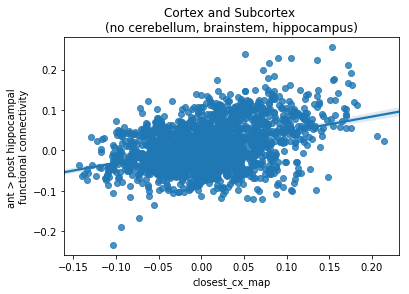

standard statistics: r2 = 0.148600688358, p = 2.01486804344e-70


r2            p
3  0.148601  2.01487e-70

In [41]:
ant_cut = 94
post_cut = 108
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = msk3
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
in_imgs = ['/Users/jakevogel/Science/AHBA/ant_img.nii.gz',
          '/Users/jakevogel/Science/AHBA/post_img.nii.gz']
run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = in_imgs, bootstrap = False, hue_vals=[],
                                  return_results=True)

In [69]:
in_imgs = ['/Users/jakevogel/Science/AHBA/ant_img.nii.gz',
          '/Users/jakevogel/Science/AHBA/post_img.nii.gz']
diff_img = ni.load(in_imgs[1]).get_data() - ni.load(in_imgs[0]).get_data()
img = diff_img
vrad = 3
bootstrap = 'bootstrap'
hue_vals = []
return_results = True
illustrative = True
msk = msk3
if type(vrad) != list:
    vrad = [vrad]
res = pandas.DataFrame(index=vrad,columns=['r2','p'])
for vs in vrad:
    g_cx = []
    f_cx = []
    if len(hue_vals) > 0:
        hvs = []

    for i,row in gdf.iterrows():
        #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
        coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 'xyz')
        coord = [round(x) for x in coord]
        if msk[coord[0],coord[1],coord[2]] != 0:
            xs,ys,zs = make_sphere(coord, vs)
            val = img[xs,ys,zs]
            f_cx.append(val.mean())
            g_cx.append(row[gcx_col])
            if len(hue_vals) > 0:
                hvs.append(hue_vals[i])


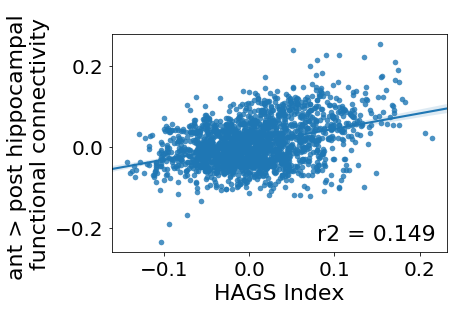

standard statistics: r2 = 0.0906078645198, p = 1.86039576534e-32


In [73]:
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(np.array(g_cx), np.array(f_cx))
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel(plabs[2])
r2 = stats.pearsonr(np.array(g_cx), np.array(f_cx))[0]**2
plt.text(0.08, -0.23,'r2 = %s'%float('%.3g'%r2), fontsize=22)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/rsfmri_HAGS.pdf',
           bbox_inches = 'tight')
plt.show()


print('standard statistics: r2 = %s, p = %s'%(r**2,p))

In [13]:
ant_cut = 94
post_cut = 108
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = msk2
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = [], bootstrap = False, hue_vals=[],
                                  return_results=True)

24 maps used for posterior, 50 used for anterior


processing anterior image


KeyError: 'the label [closest_cx_map] is not in the [columns]'

In [114]:
dmin = min(df.position_along_hipp_AP_axis)+1
dmax = max(df.position_along_hipp_AP_axis)-4
drange = int((dmax-dmin)/2)
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(drange*len(msks)*len(vrad)),
                                      columns = ['ant_cut','post_cut','n_ant','n_post',
                                                 'mask','vs','r2','p', 'manual_FDR',
                                                 'chance_r2', 'ci_l', 'ci_u'])
cnt = 0
for i in range(drange+1):
    ant_cut = dmin+i
    post_cut = dmax-i
    n_ant = len(df[df.position_along_hipp_AP_axis<dmin+i])
    n_post = len(df[df.position_along_hipp_AP_axis>dmax-i])
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'ant_cut'] = [ant_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'post_cut'] = [post_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_ant'] = [n_ant] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_post'] = [n_post] * len(msks)*len(vrad)
    ycol = 'position_along_hipp_AP_axis'
    ccol = 'closest_cx_map'
    gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
    plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
             ccol,'ant > post hippocampal \nfunctional connectivity']
    for m,msk in enumerate(msks):
        lab = 'msk%s'%(m+1)
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
        res = run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                       ccol, wdir, gdf, msk, gcx_col, plabs,
                                       del_img = True, diff_img = True,  vrad = vrad,
                                      in_imgs = [], bootstrap = 'bootstrap', hue_vals=[],
                                      return_results=True, illustrative=False, n_iter = 100)
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],
                  ['r2','p','manual_FDR','chance_r2', 'ci_l', 'ci_u']] = res.values
        cnt+=len(vrad)
        resdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/hipp_cx_analysis_bootstrap.csv')

5 maps used for posterior, 5 used for anterior


processing anterior image
making mean image
moving to template space
processing posterior image
making mean image
moving to template space
running analysis
standard statistics: r2 = 0.196764023042, p = 6.54484914341e-167
standard statistics: r2 = 0.199855857948, p = 8.20485534461e-170
standard statistics: r2 = 0.203942771361, p = 1.15122447462e-173
standard statistics: r2 = 0.209159073071, p = 1.30270863478e-178
standard statistics: r2 = 0.215213702009, p = 2.15146870212e-184
standard statistics: r2 = 0.221820931565, p = 9.37605733622e-191
5 maps used for posterior, 5 used for anterior


processing anterior image
making mean image
moving to template space
processing posterior image
making mean image
moving to template space
running analysis
standard statistics: r2 = 0.280890341107, p = 8.32369944576e-157
standard statistics: r2 = 0.284299290661, p = 4.89743679213e-159
standard statistics: r2 = 0.288415028321, p = 9.61735202791e-162
stand

ValueError: shape mismatch: value array of shape (6,2) could not be broadcast to indexing result of shape (0,2)

In [261]:
resdf = pandas.read_csv('/Users/jakevogel/Science/AHBA/hipp_cx_analysis_permute.csv',
                       index_col=0)

In [274]:
resdf.head()

ant_cut  post_cut  n_ant  n_post         mask  Voxel Radius        r2  \
0       87       115      5       5  Whole Brain             1  0.186267   
1       87       115      5       5  Whole Brain             2  0.189239   
2       87       115      5       5  Whole Brain             3  0.193634   
3       87       115      5       5  Whole Brain             4  0.199146   
4       87       115      5       5  Whole Brain             5  0.205578   

               p  manual_FDR  chance_r2          ci_l      ci_u    Split  \
0  3.153058e-154         0.0   0.000283  1.014456e-06  0.001045  87\n115   
1  6.267558e-157         0.0   0.000290  1.489335e-06  0.001190  87\n115   
2  6.088995e-161         0.0   0.000302  1.191315e-06  0.001166  87\n115   
3  5.244619e-166         0.0   0.000286  1.435880e-06  0.001059  87\n115   
4  5.838083e-172         0.0   0.000311  8.281229e-07  0.001221  87\n115   

   Split ID  
0         0  
1         0  
2         0  
3         0  
4         0

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


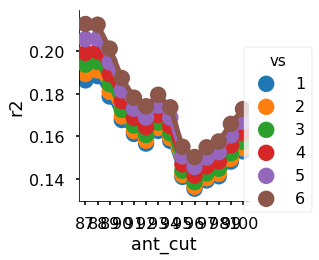

In [263]:
plt.close()
sns.factorplot(x='ant_cut', y='r2', hue='vs', data=resdf[resdf['mask']=='msk1'])
plt.show()

In [264]:
msk_dict = {'msk1': 'Whole Brain', 'msk2': 'No Cerebellum\nor Brainstem',
           'msk3': 'No Cerebellum\nBrainstem or\nHippocampus','msk4': 'Cortex Only'}
resdf['mask'] = [msk_dict[x] for x in resdf['mask']]

In [265]:
resdf.loc[:,'Split'] = [
        '%s\n%s'%(resdf.loc[x,'ant_cut'],resdf.loc[x,'post_cut']) for x in range(len(resdf))]

In [266]:
resdf.columns = resdf.columns[:5].tolist() + ['Voxel Radius'] + resdf.columns[6:].tolist()

In [267]:
split_tix = [resdf.Split.unique()[x] for x in range(0,len(resdf.Split.unique()),3)]

In [268]:
split_dict = dict(zip(resdf.Split.unique(),range(len(resdf.Split.unique()))))
resdf.loc[:,'Split ID'] = [split_dict[x] for x in resdf.Split] 

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


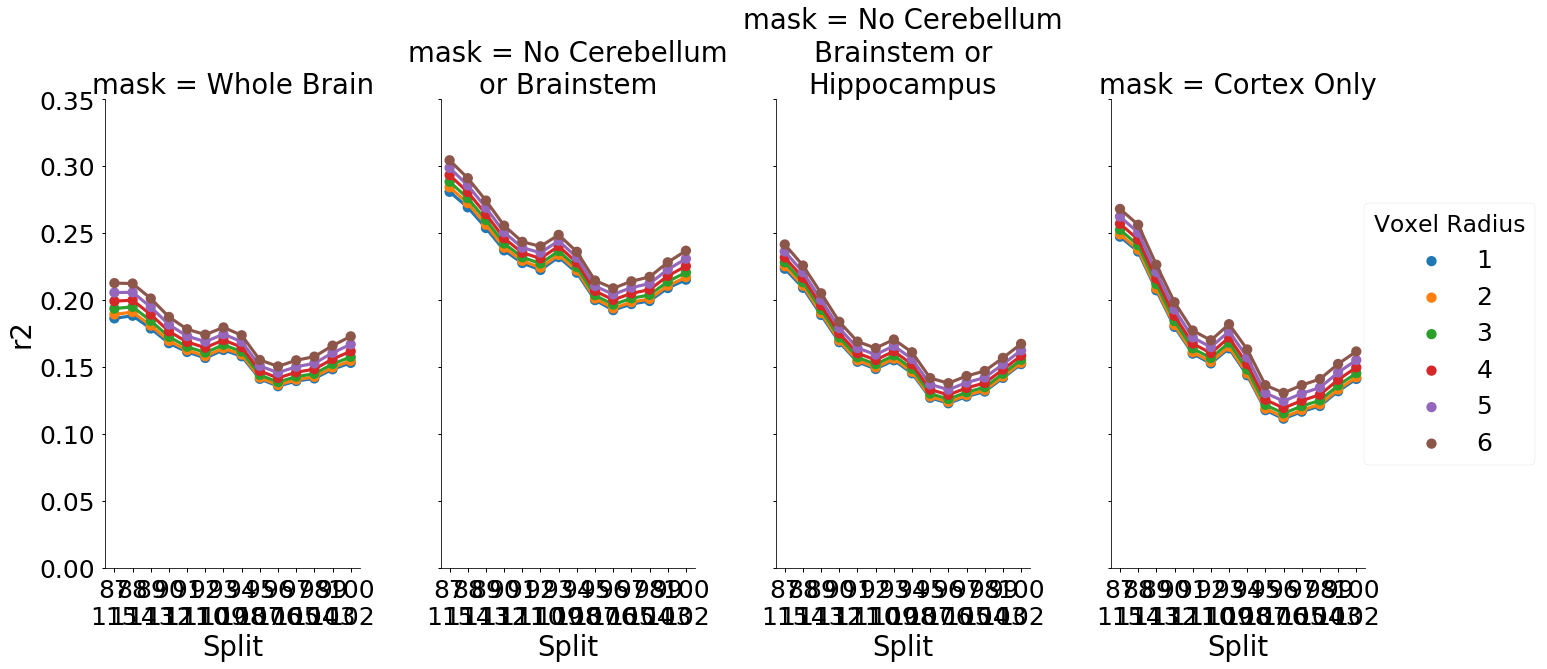

In [284]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
sns.factorplot(x='Split', y='r2', hue='Voxel Radius', col='mask', 
               data=resdf, size=10, aspect=.5)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
plt.ylim(0,0.35)
plt.show()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


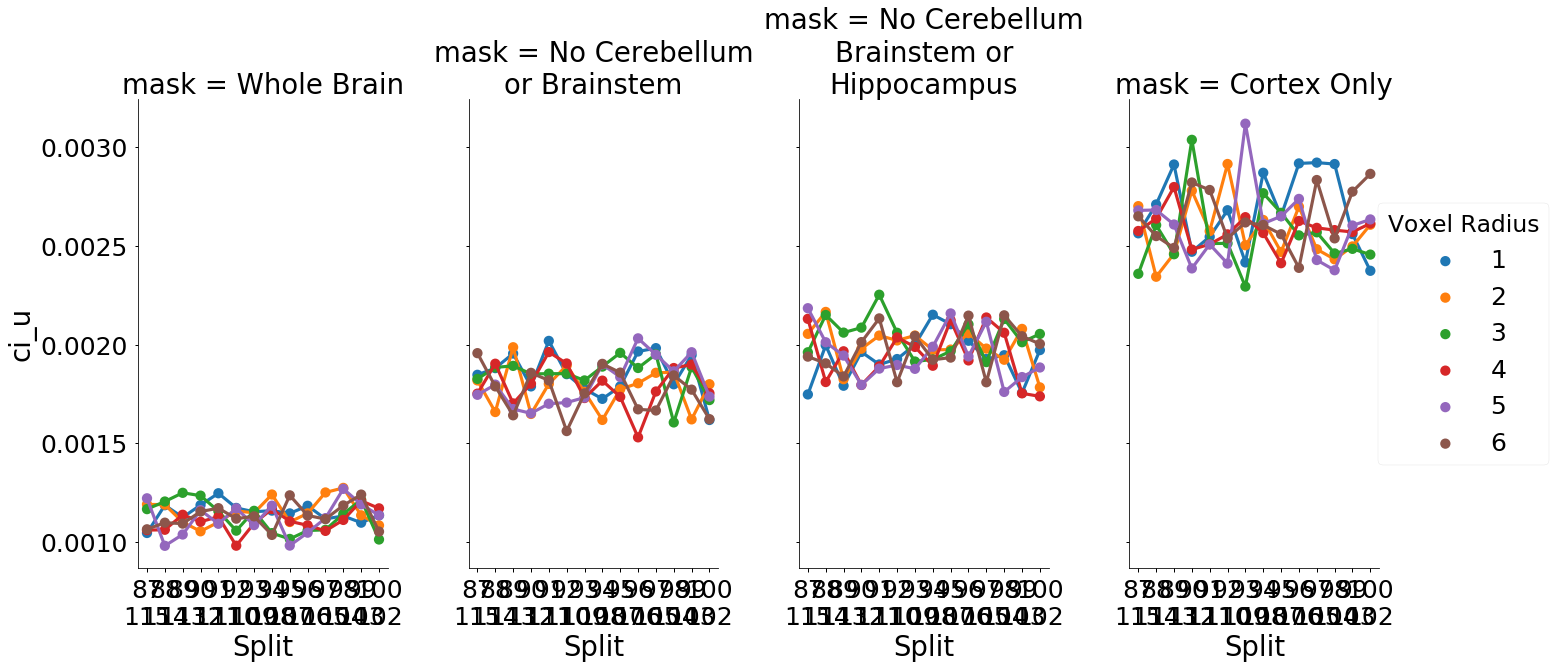

In [288]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
sns.factorplot(x='Split', y='ci_u', hue='Voxel Radius', col='mask', data=resdf, size=10, aspect=.5)
#plt.fill(resdf.ci_l, resdf.ci_u)
#plt.ylim(0,0.3)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
#plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
#plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/Hipp_Control_analysis.pdf',
#           bbox_inches = 'tight')
plt.show()

In [ ]:
jnk = pandas.concat([resdf,resdf])
jnk.index = range(len(jnk))
jnk.loc[]

In [196]:
jnk = pandas.concat([resdf[['Split','n_ant']],
                    resdf[['Split','n_post']]])
jnk.index = range(len(jnk.index))
jnk.columns = ['Split', 'n', 'Structure']
jnk.loc[jnk.index[len(resdf):],'n'] = resdf.n_post.values
jnk.loc[:,'Structure'] = (['Posterior'] * len(resdf)) + (['Anterior'] * len(resdf)) 

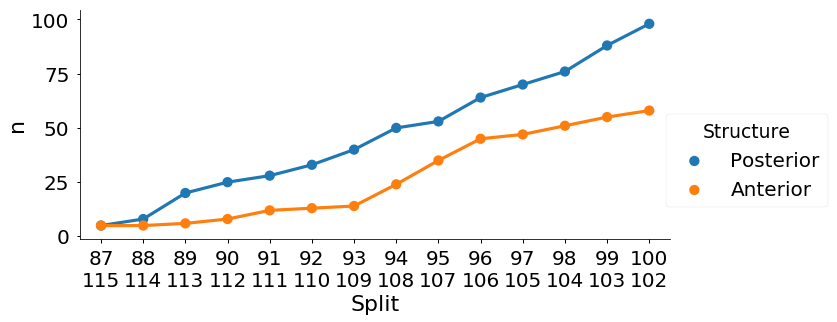

In [203]:
sns.set_context('notebook',font_scale=2)
plt.close()
sns.factorplot(x='Split', y='n', hue= 'Structure', data=jnk, size=5, aspect=2)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/Hipp_Control_n.pdf',
           bbox_inches = 'tight')
plt.show()

In [100]:
dmin = min(df.position_along_hipp_AP_axis)+1
dmax = max(df.position_along_hipp_AP_axis)-4
drange = int((dmax-dmin)/2)
for i in range(drange+1):
    n_ant = len(df[df.position_along_hipp_AP_axis<dmin+i])
    n_post = len(df[df.position_along_hipp_AP_axis>dmax-i])
    print(dmin+i,dmax-i,'      ',n_ant,n_post)

87 115        5 5
88 114        8 5
89 113        20 6
90 112        25 8
91 111        28 12
92 110        33 13
93 109        40 14
94 108        50 24
95 107        53 35
96 106        64 45
97 105        70 47
98 104        76 51
99 103        88 55
100 102        98 58
101 101        104 60


In [105]:
labs.head()

integer_label                       label  frontal  occipital  temporal  \
0              1   Caudal anterior cingulate        1          0         0   
1              2       Caudal middle frontal        1          0         0   
2              3                      Cuneus        0          1         0   
3              4                   entorinal        0          0         1   
4              5                    fusiform        0          0         1   

   parietal  
0         0  
1         0  
2         0  
3         0  
4         0

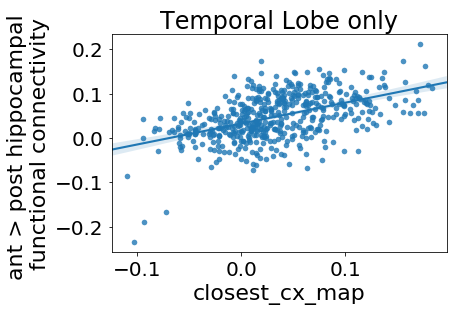

standard statistics: r2 = 0.240382322789, p = 4.4369944352e-32


r2            p
3  0.240382  4.43699e-32

In [112]:
# Within lobar masks
fmsk = np.zeros_like(dkt)
for i,row in labs[labs.temporal==1].iterrows():
    fmsk[dkt==row['integer_label']] = 1
ant_cut = 94
post_cut = 108
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = fmsk
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Temporal Lobe only',
         ccol,'ant > post hippocampal \nfunctional connectivity']
in_imgs = ['/Users/jakevogel/Science/AHBA/ant_img.nii.gz',
          '/Users/jakevogel/Science/AHBA/post_img.nii.gz']
run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = in_imgs, bootstrap = False, hue_vals=[],
                                  return_results=True)

In [295]:
# control analysis
ant_cut = 94
post_cut = 108
ant_xp = xp[xp.columns[df[df.position_along_hipp_AP_axis < ant_cut].index]].mean(1)
post_xp = xp[xp.columns[df[df.position_along_hipp_AP_axis > post_cut].index]].mean(1)
control_vec = post_xp - ant_xp
nvec = get_gene_vector(bigdf, control_vec)
gdf.loc[:,'control_vector'] = nvec

ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
msk = msk3
gcx_col = 'control_vector'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         'ant > post gene expression','ant > post hippocampal \nfunctional connectivity']
in_imgs = []
run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                   ccol, wdir, gdf, msk, gcx_col, plabs,
                                   del_img = True, diff_img = True,  vrad = 3,
                                  in_imgs = in_imgs, bootstrap = False, hue_vals=[],
                                  return_results=True)

0        0.001254
1       -0.071644
2        0.004821
3       -0.192550
4       -0.112686
5       -0.145249
6       -0.310876
7        0.051659
8       -0.568451
9        0.075269
10      -0.174006
11       0.309473
12       0.260167
13      -0.073793
14      -0.972404
15       0.032574
16       0.191798
17      -0.261108
18      -0.207114
19       0.174921
20       0.206280
21      -0.016856
22      -0.575937
23       0.024427
24       0.037170
25       0.002330
26      -0.312504
27      -0.227675
28       0.257096
29       0.133332
           ...   
58662    0.011075
58663   -0.096166
58664   -0.077226
58665    0.337615
58666   -0.022080
58667   -0.177474
58668    0.398560
58669   -0.300068
58670    0.428101
58671    0.841888
58672    0.361013
58673   -0.260915
58674    0.008820
58675    0.177135
58676   -0.191577
58677   -0.223381
58678   -0.357802
58679   -0.053108
58680    1.151650
58681   -0.235163
58682   -0.338572
58683   -0.018652
58684   -0.019217
58685    0.089712
58686    0

# FINALLY! TMAPS from RON!

In [25]:
tmap_GN.shape

(121, 145, 121)

In [248]:
gcx = ni.load('r1p5mm_MAIN_SPCR_nlin_xp_image.nii.gz').get_data()
tmap_GN = ni.load('maps/AD-FTD_globalnorm2.nii.gz').get_data()

In [249]:
dkt = ni.load('from_ron/dkt_atlas_1p5mm.nii').get_data()
#dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii').get_data()
#HO = ni.load(
#        '/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-1mm.nii.gz'
#            ).get_data()
HO = ni.load(
        'from_ron/whole_brain_mask.nii.gz'
            ).get_data()
#whole brain
msk1 = np.array(HO,copy=True)
msk1[HO<1] = 0

#no cereb or brainstem
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt==36] = 0
msk3[dkt==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt>31] = 0
msk4[dkt>41] = dkt[dkt>41]
msk4[dkt>70] = 0

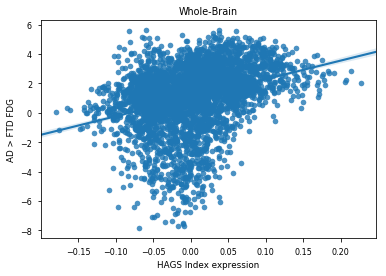

standard statistics: r2 = 0.103019698847, p = 3.48910427809e-89


KeyboardInterrupt: 

In [305]:
msks = [msk1,msk2,msk3,msk4,dkt]
sns.set_context('paper')

img = tmap_GN
vrad=3
vdim = 1.5
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Whole-Brain',
         'HAGS Index expression','AD > FTD FDG']
for mask in msks:
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                           bootstrap, n_iter=10, hue_vals=[], illustrative=True)

In [ ]:
#msks = [msk1,msk2,msk3,msk4,dkt]
sns.set_context('paper')

img = tmap_GN
vrad=3
vdim = 1.5
jnk = pandas.DataFrame(gxp,copy=True)
for i in 
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Whole-Brain',
         'HAGS Index expression','AD > FTD FDG']
msk = np.array(mask,copy=True) 
msk[img==0] = 0
run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)

In [36]:
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(len(msks)*len(vrad)),
                                      columns = ['mask','vs','r2','p'])
cnt = 0
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
for m,mask in enumerate(msks):
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    lab = 'msk%s'%(m+1)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
    res = run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                               bootstrap=False, n_iter=10, hue_vals=[], illustrative=False)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],['r2','p',]] = res.values
    cnt+=len(vrad)
    resdf.to_csv('/Users/jakevogel/Science/AHBA/AD_FTD_HAGS_analysis')

standard statistics: r2 = 0.0953458118362, p = 2.40805102453e-82
standard statistics: r2 = 0.0987310577193, p = 2.35366292708e-85
standard statistics: r2 = 0.103019698847, p = 3.48910427809e-89
standard statistics: r2 = 0.107440966081, p = 3.77132286294e-93
standard statistics: r2 = 0.111510464226, p = 8.10583202345e-97
standard statistics: r2 = 0.115522956538, p = 1.88934368964e-100
standard statistics: r2 = 0.107289522824, p = 7.60550124135e-55
standard statistics: r2 = 0.110074531871, p = 2.63578543817e-56
standard statistics: r2 = 0.114258310502, p = 1.65567337855e-58
standard statistics: r2 = 0.119180530404, p = 4.12528786146e-61
standard statistics: r2 = 0.124208161569, p = 8.74066636048e-64
standard statistics: r2 = 0.129603678308, p = 1.13577976502e-66
standard statistics: r2 = 0.107114960594, p = 6.53415997944e-50
standard statistics: r2 = 0.11002259916, p = 2.68962016552e-51
standard statistics: r2 = 0.114553175964, p = 1.82869567753e-53
standard statistics: r2 = 0.1200387753

In [306]:
vrad = [1,2,3,4,5,6]
msks = [msk1,msk2,msk3,msk4]
resdf = pandas.DataFrame(index=range(len(msks)*len(vrad)),
                                      columns = ['ant_cut','post_cut','n_ant','n_post',
                                                 'mask','vs','r2','p', 'manual_FDR',
                                                 'chance_r2', 'ci_l', 'ci_u'])
cnt = 0
ycol = 'position_along_hipp_AP_axis'
ccol = 'closest_cx_map'
gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
         ccol,'ant > post hippocampal \nfunctional connectivity']
for m,mask in enumerate(msks):
    msk = np.array(mask,copy=True) 
    msk[img==0] = 0
    lab = 'msk%s'%(m+1)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
    res = run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                               bootstrap='permute', n_iter=100, hue_vals=[], 
                             illustrative=False)
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
    resdf.loc[resdf.index[cnt:(cnt+len(vrad))],['r2','p','manual_FDR','chance_r2', 'ci_l', 'ci_u'
                                               ]] = res.values
    cnt+=len(vrad)
    resdf.to_csv('/Users/jakevogel/Science/AHBA/AD_FTD_HAGS_analysis_permute.csv')

standard statistics: r2 = 0.0953458118362, p = 2.40805102453e-82
permuted p-value =  0.0
standard statistics: r2 = 0.0987310577193, p = 2.35366292708e-85
permuted p-value =  0.0


KeyboardInterrupt: 

In [ ]:
resdf = pandas.DataFrame(index=range(drange*len(msks)*len(vrad)),
                                      columns = ['ant_cut','post_cut','n_ant','n_post',
                                                 'mask','vs','r2','p', 'manual_FDR',
                                                 'chance_r2', 'ci_l', 'ci_u'])
cnt = 0
for i in range(drange+1):
    ant_cut = dmin+i
    post_cut = dmax-i
    n_ant = len(df[df.position_along_hipp_AP_axis<dmin+i])
    n_post = len(df[df.position_along_hipp_AP_axis>dmax-i])
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'ant_cut'] = [ant_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'post_cut'] = [post_cut] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_ant'] = [n_ant] * len(msks)*len(vrad)
    resdf.loc[resdf.index[cnt:cnt+(len(msks)*len(vrad))],'n_post'] = [n_post] * len(msks)*len(vrad)
    ycol = 'position_along_hipp_AP_axis'
    ccol = 'closest_cx_map'
    gcx_col = 'AP_axis_gxp_signature_similarity_SPCR'
    plabs = ['Cortex and Subcortex \n(no cerebellum, brainstem, hippocampus)',
             ccol,'ant > post hippocampal \nfunctional connectivity']
    for m,msk in enumerate(msks):
        lab = 'msk%s'%(m+1)
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'mask'] = [lab]*len(vrad)
        res = run_hipp_connectivity_analysis(ant_cut, post_cut, df, ycol, 
                                       ccol, wdir, gdf, msk, gcx_col, plabs,
                                       del_img = True, diff_img = True,  vrad = vrad,
                                      in_imgs = [], bootstrap = 'bootstrap', hue_vals=[],
                                      return_results=True, illustrative=False, n_iter = 100)
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],'vs'] = res.index
        resdf.loc[resdf.index[cnt:(cnt+len(vrad))],
                  ['r2','p','manual_FDR','chance_r2', 'ci_l', 'ci_u']] = res.values
        cnt+=len(vrad)

In [37]:
resdf.columns

Index(['mask', 'vs', 'r2', 'p'], dtype='object')

In [38]:
msk_dict = {'msk1': 'Whole Brain', 'msk2': 'No Cerebellum\nor Brainstem',
           'msk3': 'No Cerebellum\nBrainstem or\nHippocampus','msk4': 'Cortex Only'}
resdf['mask'] = [msk_dict[x] for x in resdf['mask']]
resdf.columns = ['Mask','Voxel Radius'] + resdf.columns[2:].tolist()

//anaconda/envs/py3/lib/python3.5/site-packages/seaborn/categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


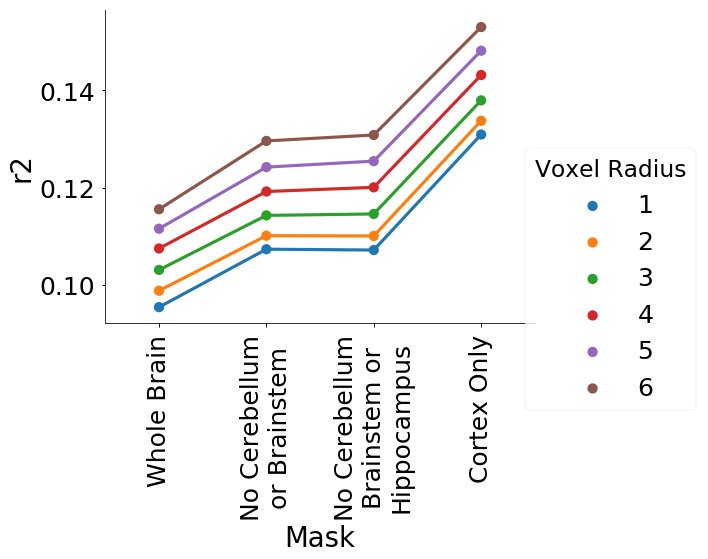

In [51]:
sns.set_context('notebook',font_scale=2.5)
plt.close()
f = sns.factorplot(x='Mask', y='r2', hue='Voxel Radius', data=resdf, size=7, aspect=1.2)
f.set_xticklabels(rotation=90)
#plt.xticks(split_tix)
#plt.yticks([0.1, 0.15, 0.2, 0.25, 0.3])
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/AD_FTD_control_analysis.pdf',
           bbox_inches = 'tight')
plt.show()

In [89]:
resdf.sort_values('r2').tail()

Mask Voxel Radius        r2            p
19  Cortex Only            2  0.133762  4.31124e-48
20  Cortex Only            3  0.137963  1.16528e-49
21  Cortex Only            4  0.143188  1.27699e-51
22  Cortex Only            5  0.148198  1.64148e-53
23  Cortex Only            6  0.153075  2.31372e-55

In [78]:
msk = msk3
vrad = 3
bootstrap = 'False'
hue_vals = []
return_results = True
illustrative = True
if type(vrad) != list:
    vrad = [vrad]
res = pandas.DataFrame(index=vrad,columns=['r2','p'])
for vs in vrad:
    g_cx = []
    f_cx = []
    if len(hue_vals) > 0:
        hvs = []

    for i,row in gdf.iterrows():
        #coord = convert_coords([row['mni_x'], row['mni_y'], row['mni_z']], 'xyz')
        coord = convert_coords([row['mni_nlin_x'], row['mni_nlin_y'], row['mni_nlin_z']], 
                               'xyz', 1.5)
        coord = [round(x) for x in coord]
        if msk[coord[0],coord[1],coord[2]] != 0:
            xs,ys,zs = make_sphere(coord, vs)
            val = img[xs,ys,zs]
            f_cx.append(val.mean())
            g_cx.append(row[gcx_col])
            if len(hue_vals) > 0:
                hvs.append(hue_vals[i])


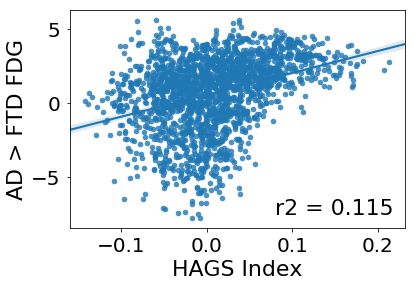

In [84]:

plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(np.array(g_cx), np.array(f_cx))
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel(plabs[2])
r2 = stats.pearsonr(np.array(g_cx), np.array(f_cx))[0]**2
plt.text(0.08, -7.5,'r2 = %s'%float('%.3g'%r2), fontsize=22)
plt.savefig('/Users/jakevogel/Dropbox/Work/Projects/AHBA_Hippocampus_AP/FDG_HAGS.pdf',
            bbox_inches = 'tight')
plt.show()


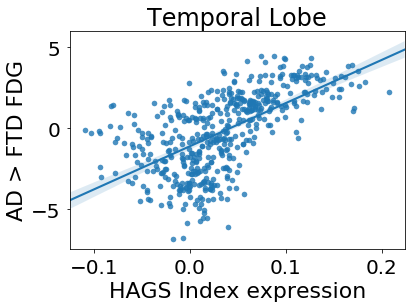

standard statistics: r2 = 0.370213505113, p = 5.8419584112e-52


r2            p
3  0.370214  5.84196e-52

In [119]:
fmsk = np.zeros_like(dkt)
for i,row in labs[labs.temporal==1].iterrows():
    fmsk[dkt==row['integer_label']] = 1
img = tmap_GN
vrad=3
vdim = 1.5
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Temporal Lobe',
         'HAGS Index expression','AD > FTD FDG']
msk = fmsk
run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)

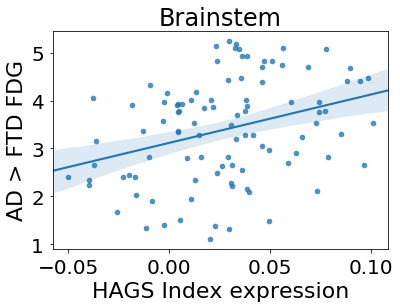

standard statistics: r2 = 0.106722374995, p = 0.00102680117303


r2          p
3  0.106722  0.0010268

In [126]:
img = tmap_GN
vrad=3
vdim = 1.5
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Brainstem',
         'HAGS Index expression','AD > FTD FDG']
msk = dkt
run_gvfcx_analysis(img, gdf[gdf.slab_type=='BS'], msk, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)

# Median analysis

In [69]:
import sys
sys.path.insert(0,'../data_driven_pathology/esm/')
import ESM_utils as esm

In [71]:
esm.Evaluate_Model?

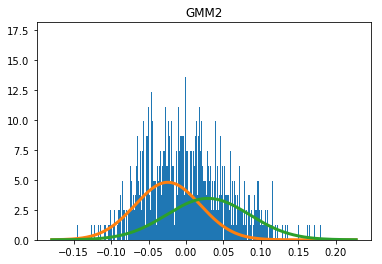

In [77]:
models = {'GMM2': mixture.BayesianGaussianMixture(n_components=2,weight_concentration_prior=1e3)}
esm.Evaluate_Model(gdf.AP_axis_gxp_signature_similarity_SPCR, models)

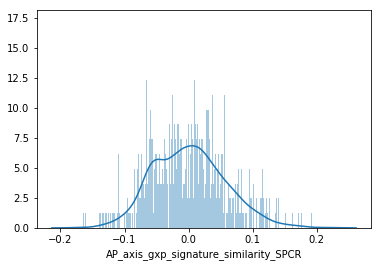

In [66]:
plt.close()
sns.distplot(gdf.AP_axis_gxp_signature_similarity_SPCR, bins = int((gdf.shape[0]/2)))
plt.show()

In [44]:
gdf.columns

Index(['Unnamed: 0', 'donor', 'sample', 'structure_id', 'slab_num', 'well_id',
       'slab_type', 'structure_acronym', 'structure_name', 'polygon_id',
       'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z',
       'gabe_label', 'mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z',
       'AP_axis_gxp_signature_similarity_SPCR'],
      dtype='object')

In [58]:
nvec = gdf[(gdf.AP_axis_gxp_signature_similarity_SPCR > -0.025
    ) & (gdf.AP_axis_gxp_signature_similarity_SPCR < 0.025
        )]['AP_axis_gxp_signature_similarity_SPCR'].values
ncoords = gdf[(gdf.AP_axis_gxp_signature_similarity_SPCR > -0.025
    ) & (gdf.AP_axis_gxp_signature_similarity_SPCR < 0.025
        )][['mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z']].values
ncoords = [convert_coords(ncoords[x],'xyz') for x in range(len(ncoords))]

In [48]:
mni = '/Users/jakevogel/Science/tau/MNI152_T1_1mm_brain.nii'

In [59]:
make_expression_image(nvec, ncoords, mni, 
                          wdir = './', nm = 'near0_0.01', vrad=3,
                         return_img = False)

In [60]:
nvec = gdf[(gdf.AP_axis_gxp_signature_similarity_SPCR > -0.01
    ) & (gdf.AP_axis_gxp_signature_similarity_SPCR < 0.01
        )]['AP_axis_gxp_signature_similarity_SPCR'].values
ncoords = gdf[(gdf.AP_axis_gxp_signature_similarity_SPCR > -0.01
    ) & (gdf.AP_axis_gxp_signature_similarity_SPCR < 0.01
        )][['mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z']].values
ncoords = [convert_coords(ncoords[x],'xyz') for x in range(len(ncoords))]

In [61]:
make_expression_image(nvec, ncoords, mni, 
                          wdir = './', nm = 'near0_0.01', vrad=3,
                         return_img = False)

# ADNI PLASMA GXP

In [437]:
# axp = pandas.read_csv(
#     '/Users/jakevogel/Downloads/ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile.csv')
# adict = pandas.read_csv(
#     '/Users/jakevogel/Downloads/ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile_DICT.csv')
# #
axp = pandas.read_csv(
    '/home/users/jvogel/Science/ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile.csv')
adict = pandas.read_csv(
    '/home/users/jvogel/Science/ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile_DICT.csv')

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,

In [13]:
axp.shape

(49394, 748)

In [14]:
adict.shape

(8, 3)

In [53]:
print(len(axp.loc[1,axp.columns[3:]].unique()))
len(axp.loc[1,axp.columns[3:]])

745


746

In [332]:
axp.loc[19,axp.columns[2]].split(' || ')

['CGB', 'CGB1', 'CGB2', 'CGB5', 'CGB7', 'CGB8']

In [28]:
print(axp.shape)
len(axp[axp.columns[2]].unique())

(49394, 749)


20094

In [442]:
jnk = [x for x in axp[axp.columns[2]
                     ].dropna().index if ' || ' in axp.loc[x,axp.columns[2]]]
multi = axp.loc[jnk]

In [334]:
gene

'9781'

In [335]:
axp[axp[axp.columns[2]] == gene]

Empty DataFrame
Columns: [Phase, Unnamed: 1, Unnamed: 2, ADNIGO, ADNI2, ADNI2.1, ADNIGO.1, ADNI2.2, ADNI2.3, ADNI2.4, ADNIGO.2, ADNI2.5, ADNI2.6, ADNIGO.3, ADNI2.7, ADNI2.8, ADNI2.9, ADNI2.10, ADNI2.11, ADNI2.12, ADNIGO.4, ADNI2.13, ADNI2.14, ADNI2.15, ADNIGO.5, ADNI2.16, ADNI2.17, ADNIGO.6, ADNI2.18, ADNI2.19, ADNI2.20, ADNI2.21, ADNI2.22, ADNIGO.7, ADNIGO.8, ADNIGO.9, ADNIGO.10, ADNIGO.11, ADNIGO.12, ADNIGO.13, ADNI2.23, ADNI2.24, ADNIGO.14, ADNIGO.15, ADNI2.25, ADNIGO.16, ADNI2.26, ADNI2.27, ADNI2.28, ADNIGO.17, ADNI2.29, ADNI2.30, ADNIGO.18, ADNI2.31, ADNIGO.19, ADNIGO.20, ADNI2.32, ADNI2.33, ADNI2.34, ADNI2.35, ADNI2.36, ADNI2.37, ADNIGO.21, ADNI2.38, ADNIGO.22, ADNIGO.23, ADNI2.39, ADNIGO.24, ADNI2.40, ADNI2.41, ADNI2.42, ADNIGO.25, ADNI2.43, ADNI2.44, ADNI2.45, ADNI2.46, ADNI2.47, ADNI2.48, ADNIGO.26, ADNI2.49, ADNI2.50, ADNI2.51, ADNIGO.27, ADNIGO.28, ADNI2.52, ADNI2.53, ADNI2.54, ADNI2.55, ADNI2.56, ADNI2.57, ADNI2.58, ADNI2.59, ADNI2.60, ADNIGO.29, ADNI2.61, ADNI2.62, ADNI2.63, ADNIGO.30, ADNIGO.31, ADNIGO.32, ...]
Index: []

[0 rows x 748 columns]

In [337]:
axp.head(10)

Phase Unnamed: 1 Unnamed: 2      ADNIGO       ADNI2     ADNI2.1  \
0             Visit        NaN        NaN         m48         v03         v03   
1         SubjectID        NaN        NaN  116_S_1249  037_S_4410  006_S_4153   
2           260/280        NaN        NaN        2.05        2.07        2.04   
3           260/230        NaN        NaN        0.55        1.54         2.1   
4               RIN        NaN        NaN         7.7         7.6         7.2   
5        Affy Plate        NaN        NaN           7           3           6   
6  YearofCollection        NaN        NaN        2011        2012        2011   
7          ProbeSet  LocusLink     Symbol         NaN         NaN         NaN   
8       11715100_at    LOC8355   HIST1H3G       2.237       2.294        2.14   
9     11715101_s_at    LOC8355   HIST1H3G       2.624       2.416       2.322   

     ADNIGO.1     ADNI2.2     ADNI2.3     ADNI2.4  \
0         m48         v03         v03         v06   
1  116_S_1232  099_S_4205  007_S_4467  128_S_0205   
2        2.03        2.01        2.05        1.95   
3        1.52         1.6        1.91        1.47   
4         6.8         7.9           7         7.9   
5           7           9           4           3   
6        2011        2011        2012        2011   
7         NaN         NaN         NaN         NaN   
8       2.062        2.04       2.439       1.955   
9         2.5       2.395       2.309       2.451   

                 ...                  ADNIGO.292   ADNI2.443  ADNIGO.293  \
0                ...                          bl         v03         m60   
1                ...                  022_S_2379  014_S_4668  130_S_0289   
2                ...                        2.05        2.05        1.98   
3                ...                         1.9        2.05        1.65   
4                ...                         6.7         6.5         6.3   
5                ...                           8           6           9   
6                ...                        2011        2012        2011   
7                ...                         NaN         NaN         NaN   
8                ...                        2.34       2.405       2.349   
9                ...                        2.53       2.513       2.754   

    ADNI2.444  ADNIGO.294   ADNI2.445   ADNI2.446   ADNI2.447   ADNI2.448  \
0         v03          bl         v03         v03         v03         v06   
1  141_S_4456  009_S_2381  053_S_4557  073_S_4300  041_S_4014  007_S_0101   
2        2.09        1.87        2.03        2.11        1.94        2.06   
3        1.56        1.45        1.33        0.27        1.72        1.35   
4         6.4         6.6         6.8         6.2         5.8         6.7   
5           3           8           5           3           1           4   
6        2012        2011        2012        2011        2011        2012   
7         NaN         NaN         NaN         NaN         NaN         NaN   
8       2.212       2.382       2.497       2.309       2.302       2.661   
9       2.559       2.277       2.466       2.607       2.569       2.679   

                        Unnamed: 747  
0                                NaN  
1                                NaN  
2                                NaN  
3                                NaN  
4                                NaN  
5                                NaN  
6                                NaN  
7                                NaN  
8  [HIST1H3G] histone cluster 1  H3g  
9  [HIST1H3G] histone cluster 1  H3g  

[10 rows x 748 columns]

Empty DataFrame
Columns: [Phase, Unnamed: 1, Unnamed: 2, ADNIGO, ADNI2, ADNI2.1, ADNIGO.1, ADNI2.2, ADNI2.3, ADNI2.4, ADNIGO.2, ADNI2.5, ADNI2.6, ADNIGO.3, ADNI2.7, ADNI2.8, ADNI2.9, ADNI2.10, ADNI2.11, ADNI2.12, ADNIGO.4, ADNI2.13, ADNI2.14, ADNI2.15, ADNIGO.5, ADNI2.16, ADNI2.17, ADNIGO.6, ADNI2.18, ADNI2.19, ADNI2.20, ADNI2.21, ADNI2.22, ADNIGO.7, ADNIGO.8, ADNIGO.9, ADNIGO.10, ADNIGO.11, ADNIGO.12, ADNIGO.13, ADNI2.23, ADNI2.24, ADNIGO.14, ADNIGO.15, ADNI2.25, ADNIGO.16, ADNI2.26, ADNI2.27, ADNI2.28, ADNIGO.17, ADNI2.29, ADNI2.30, ADNIGO.18, ADNI2.31, ADNIGO.19, ADNIGO.20, ADNI2.32, ADNI2.33, ADNI2.34, ADNI2.35, ADNI2.36, ADNI2.37, ADNIGO.21, ADNI2.38, ADNIGO.22, ADNIGO.23, ADNI2.39, ADNIGO.24, ADNI2.40, ADNI2.41, ADNI2.42, ADNIGO.25, ADNI2.43, ADNI2.44, ADNI2.45, ADNI2.46, ADNI2.47, ADNI2.48, ADNIGO.26, ADNI2.49, ADNI2.50, ADNI2.51, ADNIGO.27, ADNIGO.28, ADNI2.52, ADNI2.53, ADNI2.54, ADNI2.55, ADNI2.56, ADNI2.57, ADNI2.58, ADNI2.59, ADNI2.60, ADNIGO.29, ADNI2.61, ADNI2.62, ADNI2.63, ADNIGO.30, ADNIGO.31, ADNIGO.32, ...]
Index: []

[0 rows x 748 columns]

In [443]:
gene_map = {}
for i,gene in enumerate(probes.loc[top_2700.index,'gene_symbol'].unique()):
    hit = axp[axp[axp.columns[2]] == gene]
    if len(hit) > 0:
        gene_map.update({gene: hit.index.tolist()})
    else:
        hit = [x for x in jnk if gene in multi.loc[x,axp.columns[2]].split(' || ')]
        if len(hit) > 0:
            gene_map.update({gene: hit})
    if i%1000 == 0:
        print(i)

0
1000
2000


In [47]:
gene_map = {}
for i,gene in enumerate(probes.gene_symbol.unique()):
    hit = axp[axp[axp.columns[2]] == gene]
    if len(hit) > 0:
        gene_map.update({gene: hit.index.tolist()})
    else:
        hit = [x for x in jnk if gene in multi.loc[x,axp.columns[2]].split(' || ')]
        if len(hit) > 0:
            gene_map.update({gene: hit})
    if i%1000 == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [341]:
len(gene_map.values())

57

In [57]:
pcalr_out_NEW['betas'][probes[probes.gene_symbol==gene].index]

array([ 0.00249709,  0.00184639,  0.00360222])

In [59]:
gene

'APOE'

In [342]:
axp.loc[1,axp.columns[3:]].dropna()

ADNIGO        116_S_1249
ADNI2         037_S_4410
ADNI2.1       006_S_4153
ADNIGO.1      116_S_1232
ADNI2.2       099_S_4205
ADNI2.3       007_S_4467
ADNI2.4       128_S_0205
ADNIGO.2      003_S_2374
ADNI2.5       036_S_4491
ADNI2.6       098_S_4059
ADNIGO.3      031_S_2018
ADNI2.7       002_S_4654
ADNI2.8       019_S_4285
ADNI2.9       141_S_4426
ADNI2.10      067_S_4072
ADNI2.11      037_S_4308
ADNI2.12      041_S_4200
ADNIGO.4      128_S_0200
ADNI2.13      129_S_4220
ADNI2.14      018_S_4313
ADNI2.15      067_S_0257
ADNIGO.5      029_S_1218
ADNI2.16      141_S_4053
ADNI2.17      136_S_4408
ADNIGO.6      021_S_2142
ADNI2.18      114_S_4404
ADNI2.19      116_S_4167
ADNI2.20      116_S_4209
ADNI2.21      073_S_4360
ADNI2.22      072_S_4539
                 ...    
ADNI2.431     019_S_4367
ADNIGO.283    131_S_0384
ADNI2.432     135_S_4309
ADNI2.433     129_S_4369
ADNI2.434     137_S_0686
ADNI2.435     128_S_4571
ADNIGO.284    099_S_2063
ADNI2.436     011_S_4120
ADNI2.437     041_S_0125


In [51]:
subs

In [444]:
good_cols = [x for x in range(3,len(axp.loc[1,axp.columns[3:]])
                 ) if pandas.notnull(axp.loc[1,axp.columns[x]])]

In [344]:
len(db.mean().values)

NameError: name 'db' is not defined

In [345]:
len(subs)

NameError: name 'subs' is not defined

In [346]:
len(good_cols)

742

In [106]:
jnka = np.array([np.nan for x in range(100)])
jnkb = pandas.Series(jnka)
y = np.random.random(100)

array([ 0.91827045,  0.74154761,  0.22093676,  0.31961651,  0.1909398 ,
        0.95081072,  0.14598908,  0.8250563 ,  0.99562252,  0.46933804,
        0.96980615,  0.44860682,  0.85453763,  0.15827398,  0.89863244,
        0.00175156,  0.44695773,  0.42967424,  0.46803401,  0.68062344,
        0.52771921,  0.76370914,  0.84162192,  0.72474993,  0.32510941,
        0.10141325,  0.53389985,  0.24989578,  0.83922127,  0.86001121,
        0.03340031,  0.1667382 ,  0.07920816,  0.6118464 ,  0.23581626,
        0.36157613,  0.49860267,  0.95901248,  0.53864772,  0.99004918,
        0.66626942,  0.08394993,  0.65018422,  0.97617871,  0.29726761,
        0.67065703,  0.42850772,  0.96801544,  0.90349543,  0.1002011 ,
        0.45771433,  0.68511593,  0.89169998,  0.23951496,  0.77742591,
        0.18480314,  0.9470884 ,  0.46467687,  0.44856929,  0.67096734,
        0.76339841,  0.52518577,  0.55565768,  0.92023456,  0.39672806,
        0.83903106,  0.43081177,  0.76305966,  0.30279513,  0.57

In [108]:
%%timeit 
jnka[:] = y

The slowest run took 42.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 570 ns per loop


In [109]:
%%timeit
jnkb.loc[:] = y

The slowest run took 26.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 178 µs per loop


In [112]:
i

21

In [349]:
#gene_map

[12941, 12942]

In [416]:
jnk = top_100.loc[[x for x in top_100.index if x in probes[probes.gene_symbol==gene].index]].index
db = MOD_t100['betas'][[x for x in range(len(top_100.index)) if top_100.index[x] in jnk]]

In [418]:
np.mean(db)

0.0

In [446]:
subs = axp.loc[1,axp.columns[good_cols]]
cols = subs.tolist()
adni_xp = []
#xval = pandas.DataFrame(index = , columns = cols)
genes = list(gene_map.keys())
xval = np.zeros((len(genes),len(cols)))
for i,gene in enumerate(genes):
    #db = pcalr_out_NEW['betas'][probes[probes.gene_symbol==gene].index]
    jnk = top_2700.loc[[x for x in top_2700.index if x in probes[probes.gene_symbol==gene].index]].index
    jnk2 = [x for x in range(len(top_2700.index)) if top_2700.index[x] in jnk]
    db = MOD_t2700['betas'][jnk2]
    if type(db) == float:
        adni_xp.append(db)
    else:
        adni_xp.append(np.mean(db))
    db = axp.loc[gene_map[gene], axp.columns[good_cols]]
    if len(db.shape) == 1:
        xval[i,:] = db.values
    else:
        xval[i,:] = db.astype(float).mean().values
    if i%100==0:
        print(i)

0
100


KeyboardInterrupt: 

In [422]:
xvaldf = pandas.DataFrame(xval,index = genes, columns = subs)

In [423]:
xvaldf.head()

1        116_S_1249  037_S_4410  006_S_4153  116_S_1232  099_S_4205  \
GAL        2.025000    1.986500    2.044000    2.095500    1.864500   
ONECUT2    1.968000    1.942000    2.046500    2.046000    2.140000   
PDLIM5     5.596667    5.540333    5.438167    5.376667    5.958833   
COL5A2     2.358833    2.332167    2.253167    2.538333    2.370167   
KDELR3     2.953500    2.766500    2.851500    2.962500    2.731500   

1        007_S_4467  128_S_0205  003_S_2374  036_S_4491  098_S_4059  \
GAL          2.0060    1.861500    2.053000    2.135500      1.9420   
ONECUT2      1.8740    2.050000    2.209500    2.049500      2.0345   
PDLIM5       5.4845    5.280167    5.643833    5.222000      5.5635   
COL5A2       2.3775    2.493000    2.402500    2.491167      2.4095   
KDELR3       2.8205    2.868000    2.920500    2.767000      3.0965   

1           ...      023_S_4164  128_S_2130  082_S_4339  022_S_2379  \
GAL         ...        2.167000    1.808000    2.000000    2.204500   
ONECUT2     ...        2.036500    2.212500    2.022500    1.970500   
PDLIM5      ...        5.682500    5.544833    5.581833    5.344000   
COL5A2      ...        2.459167    2.468833    2.499000    2.452167   
KDELR3      ...        3.368000    2.825500    3.095500    2.739000   

1        014_S_4668  130_S_0289  141_S_4456  009_S_2381  053_S_4557  \
GAL        2.133500      1.8625    1.858500    2.124000    2.002500   
ONECUT2    2.154500      1.9920    2.138000    2.066500    2.137000   
PDLIM5     5.521500      5.7785    5.516833    5.575833    5.271667   
COL5A2     2.576167      2.4030    2.333500    2.382500    2.378500   
KDELR3     3.042500      3.1950    2.986500    3.284000    2.817000   

1        073_S_4300  
GAL        1.833000  
ONECUT2    2.042500  
PDLIM5     5.402833  
COL5A2     2.472000  
KDELR3     2.587500  

[5 rows x 742 columns]

In [382]:
adni_xp[0]

In [425]:
#h_tfm = pandas.DataFrame(index=subs,columns=['h_tfm'])
#h_tfm.loc[:,'h_tfm'] = xvaldf.mean().values
for sub in subs:
    h_tfm.loc[sub,'h_tfm'] = np.dot(adni_xp, xvaldf[sub])

In [427]:
h_tfm.head()

h_tfm visit         sub
1                                     
116_S_1249  7.833692   m48  116_S_1249
037_S_4410  7.227198   v03  037_S_4410
006_S_4153  6.670985   v03  006_S_4153
116_S_1232  8.102872   m48  116_S_1232
099_S_4205  7.660085   v03  099_S_4205

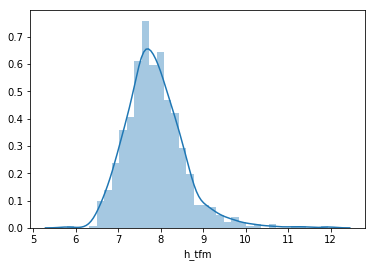

In [428]:
plt.close()
sns.distplot(h_tfm.h_tfm)
plt.show()

In [390]:
#adni = pandas.read_csv('/Users/jakevogel/Science/TADPOLE/TADPOLE_D1_D2.csv',usecols=list(range(50)))
adni = pandas.read_csv('/home/users/jvogel/Science/TADPOLE/TADPOLE_D1_D2.csv',usecols=list(range(50)))

In [391]:
h_tfm.loc[:,'visit'] = axp.loc[axp.index[0],axp.columns[good_cols]].values
h_tfm.loc[:,'sub'] = h_tfm.index.values

In [392]:
h_tfm.head()

h_tfm visit         sub
1                                     
116_S_1249  3.244788   m48  116_S_1249
037_S_4410  3.156477   v03  037_S_4410
006_S_4153  3.151062   v03  006_S_4153
116_S_1232  3.235162   m48  116_S_1232
099_S_4205  3.175939   v03  099_S_4205

In [393]:
gind = [x for x in adni.index if adni.loc[x,'PTID'] in h_tfm.index.tolist()]

In [394]:
adni=adni.loc[gind]

In [395]:
int(h_tfm.loc['099_S_4205','visit'][1:])

3

In [396]:
db = db.sort_values()
db.index[v]

TypeError: sort_values() missing 1 required positional argument: 'by'

In [219]:
row = h_tfm.loc['116_S_4167']
v = int(row['visit'][1:]) -1
db = adni[adni.PTID==row['sub']]['VISCODE'].sort_values()
print(v,db.shape)

10 (10,)


In [397]:
gind = []
for i,row in h_tfm.iterrows():
    if row['visit'][0] == 'v':
        v = int(row['visit'][1:]) -1
        db = adni[adni.PTID==row['sub']]['VISCODE'].sort_values()
        try:
            ind = db.index[v]
        except:
            print(row['sub'],v,db.shape[-1],(v-db.shape[-1]))
    else:
        ind = adni[(adni.PTID==row['sub']) & (adni.VISCODE==row['visit'])].index[0]
    gind.append(ind)
        
len(gind)

116_S_4167 10 10 0
116_S_4209 2 2 0
031_S_4496 10 6 4
073_S_4540 2 2 0
070_S_4692 2 2 0
007_S_4488 10 7 3
032_S_4348 2 2 0
009_S_4564 1 1 0
073_S_4403 2 2 0
033_S_4179 10 8 2
016_S_4353 2 2 0
098_S_4095 2 1 1
141_S_1378 10 10 0
135_S_4489 10 8 2
128_S_4603 2 1 1
109_S_4260 2 1 1


742

In [398]:
adni = adni.loc[gind]
adni.shape

(742, 50)

In [429]:
adni.loc[:,'h_tfm'] = h_tfm['h_tfm'].values

In [430]:
#h_tfm.to_csv('/Users/jakevogel/Science/AHBA/ADNI_gxp_tfm.csv')
h_tfm.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/ADNI_gxp_tfm_set100.csv')

In [235]:
adni.columns

Index(['RID', 'PTID', 'VISCODE', 'SITE', 'D1', 'D2', 'COLPROT', 'ORIGPROT',
       'EXAMDATE', 'DX_bl', 'DXCHANGE', 'AGE', 'PTGENDER', 'PTEDUCAT',
       'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'FDG', 'PIB', 'AV45',
       'CDRSB', 'ADAS11', 'ADAS13', 'MMSE', 'RAVLT_immediate',
       'RAVLT_learning', 'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'FAQ',
       'MOCA', 'EcogPtMem', 'EcogPtLang', 'EcogPtVisspat', 'EcogPtPlan',
       'EcogPtOrgan', 'EcogPtDivatt', 'EcogPtTotal', 'EcogSPMem', 'EcogSPLang',
       'EcogSPVisspat', 'EcogSPPlan', 'EcogSPOrgan', 'EcogSPDivatt',
       'EcogSPTotal', 'FLDSTRENG', 'FSVERSION', 'Ventricles', 'Hippocampus',
       'WholeBrain', 'h_tfm'],
      dtype='object')

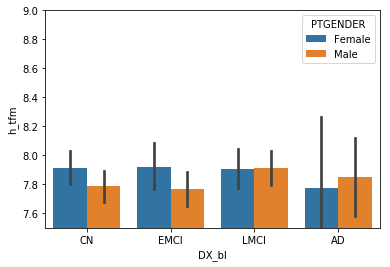

In [433]:
plt.close()
sns.barplot(x='DX_bl',y='h_tfm',hue='PTGENDER',data=adni,
           order = ['CN','EMCI','LMCI','AD'])
plt.ylim(7.5,9)
plt.show()
#[adni.DX_bl=='CN']

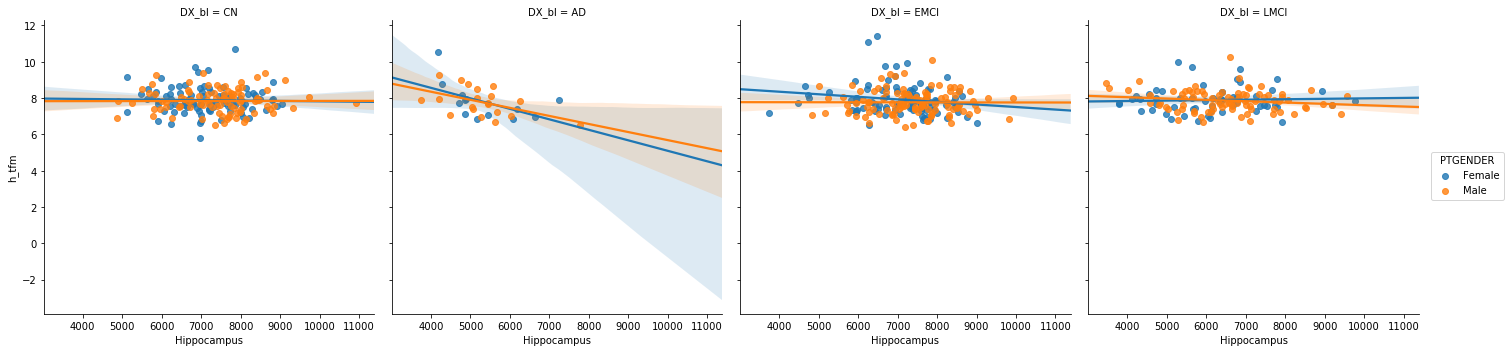

In [434]:
plt.close()
sns.lmplot(x='Hippocampus',y='h_tfm',hue='PTGENDER',col='DX_bl',data=adni)
plt.show()
#[adni.DX_bl=='CN']

# Structural connectivity

In [35]:
from nilearn import datasets, image, plotting, input_data

In [36]:
data = datasets.fetch_oasis_vbm()

In [37]:
data.keys()

dict_keys(['gray_matter_maps', 'white_matter_maps', 'ext_vars', 'data_usage_agreement', 'description'])

In [38]:
demos = pandas.DataFrame(data.ext_vars)
demos.head()

id    mf  hand  age  educ  ses  mmse  cdr  etiv   nwbv  \
0  b'OAS1_0001_MR1'  b'F'  b'R'   74     2    3    29  0.0  1344  0.743   
1  b'OAS1_0002_MR1'  b'F'  b'R'   55     4    1    29  0.0  1147  0.810   
2  b'OAS1_0003_MR1'  b'F'  b'R'   73     4    3    27  0.5  1454  0.708   
3  b'OAS1_0004_MR1'  b'M'  b'R'   28    -1   -1    -1  NaN  1588  0.803   
4  b'OAS1_0005_MR1'  b'M'  b'R'   18    -1   -1    -1  NaN  1737  0.848   

     asf   delay  
0  1.306  b'N/A'  
1  1.531  b'N/A'  
2  1.207  b'N/A'  
3  1.105  b'N/A'  
4  1.010  b'N/A'

In [39]:
len(demos[demos.age < 40])

153

In [131]:
[str(x)[2:-5] for x in demos[demos.age < 40]['id'].values][0]

'OAS1_0004'

In [141]:
data['gray_matter_maps']

['/home/users/jvogel/nilearn_data/oasis1/OAS1_0001_MR1/mwrc1OAS1_0001_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0002_MR1/mwrc1OAS1_0002_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0003_MR1/mwrc1OAS1_0003_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0004_MR1/mwrc1OAS1_0004_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0005_MR1/mwrc1OAS1_0005_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0006_MR1/mwrc1OAS1_0006_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0007_MR1/mwrc1OAS1_0007_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0009_MR1/mwrc1OAS1_0009_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oasis1/OAS1_0010_MR1/mwrc1OAS1_0010_MR1_mpr_anon_fslswapdim_bet.nii.gz',
 '/home/users/jvogel/nilearn_data/oas

In [40]:
scans = []
for sub in [str(x)[2:-5] for x in demos[demos.age < 40]['id'].values]:
    for scan in data['gray_matter_maps']:
        if sub in scan:
            scans.append(scan)

In [150]:
plotting.plot_anat?

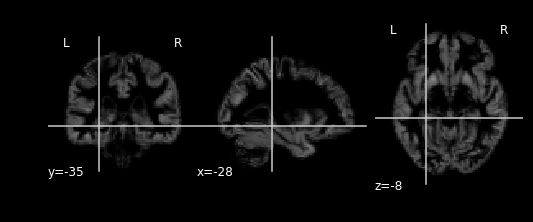

(91, 109, 91)

In [160]:
jnk = ni.load(scans[0])
plt.close()
plotting.plot_anat(jnk, cut_coords=(-28,-35,-8))
plt.show()
jnk.shape

In [348]:
gmvs = image.load_img(scans)
gmvs.shape

(91, 109, 91, 153)

In [42]:
i4d = gmvs.get_data()

In [159]:
tst_coord = convert_coords(convert_coords(df.loc[10,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values, 'xyz',2),
                       'mni',2)

(-28.284227630071697, -34.642096735786509, -7.7934462037831622)

In [44]:
coord = [int(round(x)) for x in convert_coords(df.loc[10,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values, 
                                               'xyz',2)]
coord

[59, 46, 32]

In [45]:
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask[avg_image>0.2] = 1

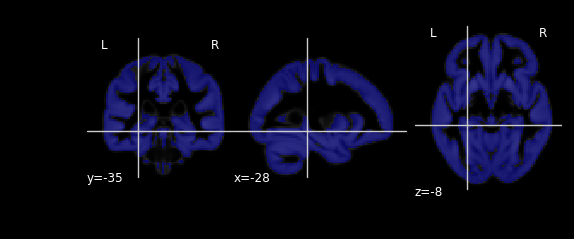

In [46]:
plt.close()
plotting.plot_roi(ni.Nifti1Image(mask,gmvs.affine),
                  bg_img = ni.Nifti1Image(avg_image,gmvs.affine),
                  cut_coords=(-28,-35,-8))
plt.show()

In [47]:
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine))
i2d = mskr.fit_transform(gmvs)

In [182]:
i2d.shape

(153, 148661)

In [53]:
%timeit rs2 = [stats.pearsonr(cvec,i2d[:,x])[0] for x in range(i2d.shape[-1])]

9.27 s ± 53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%%time
#cvec = i4d[coord[0],coord[1],coord[2],:]
rs = []
for x in range(i2d.shape[-1]):
    rs.append(stats.pearsonr(cvec,i2d[:,x])[0])
    #if x%20000==0:
        #print(x)

CPU times: user 9.36 s, sys: 0 ns, total: 9.36 s
Wall time: 9.36 s


In [ ]:
rs2 = [stats.pearsonr(cvec,i2d[:,x])[0] for x in range(i2d.shape[-1])]

In [195]:
r_mtx = np.repeat(np.array(rs)[:, np.newaxis], i2d.shape[0], axis=1).T

In [196]:
r_mtx.shape

(153, 148661)

In [202]:
r_image = mskr.inverse_transform(r_mtx).get_data().mean(3)

(91, 109, 91)

In [ ]:
plt.close()
plotting.plot_stat_map(ni.Nifti1Image(mask,gmvs.affine),
                  bg_img = ni.Nifti1Image(avg_image,gmvs.affine),
                  cut_coords=(-28,-35,-8))
plt.show()

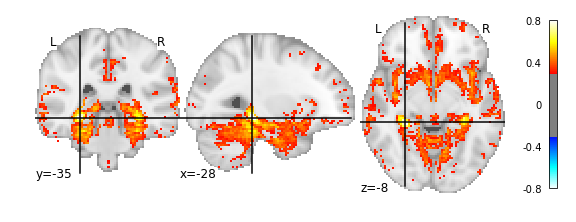

In [209]:
plt.close()
plotting.plot_stat_map(ni.Nifti1Image(r_image, gmvs.affine), cut_coords=(-28,-35,-8), threshold=0.3, vmax=0.8)
plt.show()

In [247]:
len(rs2)

148661

In [207]:
plotting.plot_stat_map?

In [211]:
2 >= 2

True

In [216]:
np.arange(8).reshape(2,4).mean(1)

array([ 1.5,  5.5])

In [266]:
out_imgs = structural_connectivity_analysis(gmvs, df, 'position_along_hipp_AP_axis', 108, 94, 2,
                                           outdir = '/home/users/jvogel/Science/Allen_Human_Brain_Atlas/')

initializing
creating anterior connectivity map
computing 1 of 35 connectivity maps
computing 2 of 35 connectivity maps
computing 3 of 35 connectivity maps
computing 4 of 35 connectivity maps
computing 5 of 35 connectivity maps
computing 6 of 35 connectivity maps
computing 7 of 35 connectivity maps
computing 8 of 35 connectivity maps
computing 9 of 35 connectivity maps
computing 10 of 35 connectivity maps
computing 11 of 35 connectivity maps
computing 12 of 35 connectivity maps
computing 13 of 35 connectivity maps
computing 14 of 35 connectivity maps
computing 15 of 35 connectivity maps
computing 16 of 35 connectivity maps
computing 17 of 35 connectivity maps
computing 18 of 35 connectivity maps
computing 19 of 35 connectivity maps
computing 20 of 35 connectivity maps
computing 21 of 35 connectivity maps
computing 22 of 35 connectivity maps
computing 23 of 35 connectivity maps
computing 24 of 35 connectivity maps
computing 25 of 35 connectivity maps
computing 26 of 35 connectivity maps

TypeError: get_structural_connectivity() missing 1 required positional argument: 'vdim'

In [119]:
def structural_connectivity_analysis(input_img, df, col, ant_cut, post_cut, vdim, 
                                     mask_thr=0.2, outdir = None, outname='strucx'):
    
    print('initializing')
    i4d = input_img.get_data()
    avg_image = i4d.mean(3)
    mask = np.zeros_like(avg_image)
    mask[avg_image>mask_thr] = 1
    mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,input_img.affine))
    i2d = mskr.fit_transform(input_img)
    
    print('creating anterior connectivity map')
    antdf = df[df[col]>=ant_cut][['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
    ant_mtx = get_structural_connectivity(antdf, i4d, i2d, vdim)
    ant_image = mskr.inverse_transform(ant_mtx).get_data().mean(3)
    
    print('creating posterior connectivity map')
    postdf = df[df[col]<=post_cut][['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
    post_mtx = get_structural_connectivity(postdf, i4d, i2d, vdim)
    post_image = mskr.inverse_transform(post_mtx).get_data().mean(3)
    
    diff_image = ni.Nifti1Image((ant_image - post_image), input_img.affine)
    ant_image = ni.Nifti1Image(ant_image,input_img.affine)
    post_image = ni.Nifti1Image(post_image,input_img.affine)
    output = {'anterior': ant_image,
             'posterior': post_image,
             'difference': diff_image}

    if outdir:
        for lab, image in output.items():
            image.to_filename(os.path.join(wdir,'%s_%s'%(outname,lab)))
    
    return output
        
def get_structural_connectivity(cdf, i4d, i2d, vdim, embedded=True):
    
    rmat = np.zeros((len(cdf),i2d.shape[1]))
    for i,c in enumerate(cdf.index):
        coord = [int(round(x)) for x in convert_coords(cdf.loc[c].values, 'xyz', vdim)]
        print('computing %s of %s connectivity maps'%(i+1,len(cdf)))
        cvec = i4d[coord[0],coord[1],coord[2],:]
        rs = [stats.pearsonr(cvec,i2d[:,x])[0] for x in range(i2d.shape[1])]
        rmat[i,:] = rs
    if embedded:
        rvec = rmat.mean(0)
        r_mtx = np.repeat(np.array(rvec)[:, np.newaxis], i2d.shape[0], axis=1).T

        return r_mtx
    else:
        return rmat


In [120]:
from nilearn import input_data
# ALL COORDINATES FOR DIFFUSION EMBEDDING
i4d = gmvs.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask_thr = 0.2
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine))
i2d = mskr.fit_transform(gmvs)
cdf = df[['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
all_mtx = get_structural_connectivity(cdf, i4d, i2d, vdim=2, embedded=False)

computing 1 of 170 connectivity maps
computing 2 of 170 connectivity maps
computing 3 of 170 connectivity maps
computing 4 of 170 connectivity maps
computing 5 of 170 connectivity maps
computing 6 of 170 connectivity maps
computing 7 of 170 connectivity maps
computing 8 of 170 connectivity maps
computing 9 of 170 connectivity maps
computing 10 of 170 connectivity maps
computing 11 of 170 connectivity maps
computing 12 of 170 connectivity maps
computing 13 of 170 connectivity maps
computing 14 of 170 connectivity maps
computing 15 of 170 connectivity maps
computing 16 of 170 connectivity maps
computing 17 of 170 connectivity maps
computing 18 of 170 connectivity maps
computing 19 of 170 connectivity maps
computing 20 of 170 connectivity maps
computing 21 of 170 connectivity maps
computing 22 of 170 connectivity maps
computing 23 of 170 connectivity maps
computing 24 of 170 connectivity maps
computing 25 of 170 connectivity maps
computing 26 of 170 connectivity maps
computing 27 of 170 c

In [142]:
jnk = np.corrcoef(all_mtx)

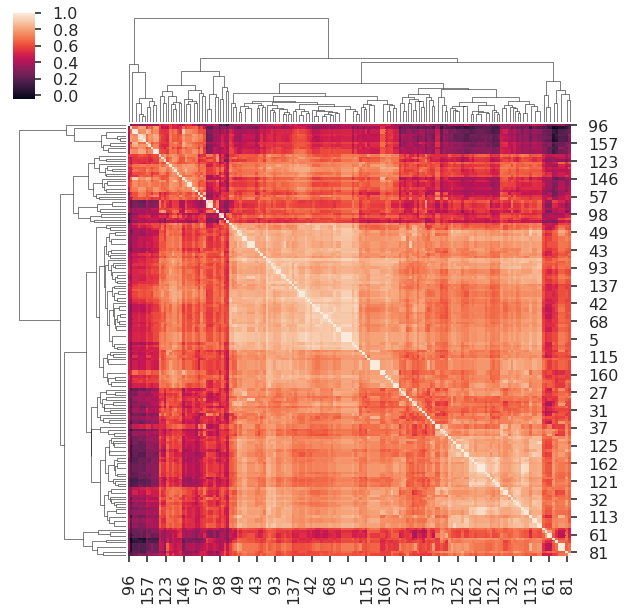

In [143]:
plt.close()
sns.clustermap(jnk)
plt.show()

In [144]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix', all_mtx)

In [332]:
all_mtx = np.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix.npz')['arr_0']

In [145]:
from scipy.io import savemat, loadmat
jnk = {'all_mtx': all_mtx}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_ALL_coords_matrix',jnk)

In [877]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')

In [563]:
del(all_mtx)

In [562]:
del(gmvs)
del(i4d)
del(i2d)

In [149]:
emb['emb'].shape

(170, 10)

In [177]:
res['res'].dtype

dtype([('diffusionTime', 'O'), ('lambdas', 'O'), ('nComponents', 'O'), ('nComponentsAuto', 'O'), ('vectors', 'O')])

In [162]:
res['res'][0][0][0].shape

(1, 12)

In [163]:
res['res'][0][0][1].shape

(1, 12)

In [165]:
res['res'][0][0][2]

array([[10]], dtype=uint8)

In [166]:
res['res'][0][0][3]

array([[10]], dtype=uint8)

In [168]:
res['res'][0][0][4].shape

(170, 13)

In [191]:
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)
predicted = pcalr_out_NEW['final_model'].predict(pca_tfm)
df.loc[:,'predicted'] = predicted

In [881]:
# VARIANCE EXPLAINED:
lambdas = res['res'][0][0][1]
lambdas / np.sum(lambdas)

array([[ 0.22396729,  0.14395641,  0.13441753,  0.10896485,  0.07861001,
         0.06185049,  0.05669524,  0.0454259 ,  0.04152334,  0.03770886,
         0.03393468,  0.03294539]])

In [393]:
svecs = res['res'][0][0][4]
for i in range(vecs.shape[-1]):
    print(i,stats.pearsonr(df.position_along_hipp_AP_axis, vecs[:,i]))

0 (-6.8430364290892191e-05, 0.99929336160501137)
1 (-0.6618368295623529, 8.723749447165814e-23)
2 (0.173577943025643, 0.0235929687507773)
3 (0.029274894606394614, 0.70471531855367864)
4 (-0.19725075305251549, 0.0099304421292270174)
5 (-0.16589345048617823, 0.030615763979139104)
6 (-0.18670636449686484, 0.01477412795284198)
7 (0.21740870703572462, 0.0044009548518901907)
8 (-0.22910158729275748, 0.0026544569949718696)
9 (0.077296656692490737, 0.31639707023572244)
10 (0.037604193281069037, 0.62636211310014955)
11 (-0.098528641391444571, 0.20114686824337744)
12 (-0.0095921766441304825, 0.90119904223024461)


In [334]:
svecs = res['res'][0][0][4]
for i in range(vecs.shape[-1]):
    print(i,stats.pearsonr(df.predicted, vecs[:,i]))

0 (-0.13802969783951821, 0.072651939101505025)
1 (-0.29541954391459813, 9.1901032933832988e-05)
2 (0.46962863789262121, 1.0433803156498566e-10)
3 (0.57316266439389063, 3.1355420059394188e-16)
4 (-0.10782604560385436, 0.16163580496164828)
5 (0.1461788272810346, 0.057157154508370445)
6 (-0.12118387352922425, 0.11544256056097506)
7 (0.045171744149959836, 0.55860096346151367)
8 (0.15214656072340957, 0.04762954059244634)
9 (-0.20589970506252667, 0.0070659007977376303)
10 (-0.20553123406049711, 0.0071710224567514023)
11 (-0.04207123900181492, 0.58593509313253489)
12 (0.10023392425937901, 0.19342072112932551)


In [1089]:
df.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_ALLVAR_hippocampus_sample_info.csv')

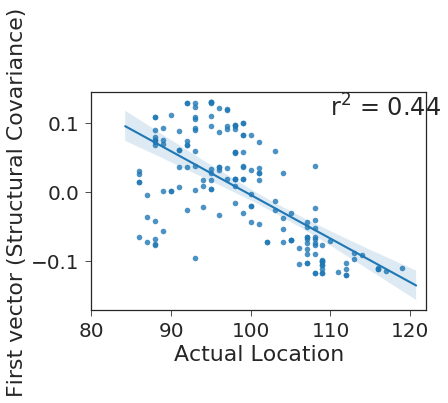

In [871]:
plt.close()
sns.regplot(df.position_along_hipp_AP_axis, svecs[:,1])
plt.xlabel('Actual Location')
plt.ylabel('First vector (Structural Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, svecs[:,1])
plt.text(110,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_actual.pdf',
           bbox_inches='tight')
plt.show()

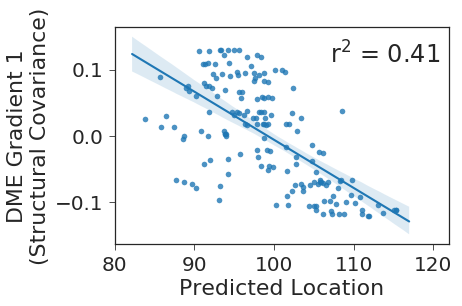

In [872]:
plt.close()
sns.regplot(df['All 58k'], svecs[:,1])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 1\n(Structural Covariance)')
r,p = stats.pearsonr(df['All 58k'], svecs[:,1])
plt.text(107,0.11, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80,122)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_predicted.pdf',
           bbox_inches='tight')
plt.show()

In [1133]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_diff_emb_res.mat')
svecsCTX = emb['emb']
dme_ress = pandas.DataFrame(index=range(fvecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])

# stats
for i in range(svecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, svecsCTX[:,i])
    dme_ress.loc[i,'position_r2'] = r**2
    r,p = stats.pearsonr(df['All 58k'], svecsCTX[:,i])
    dme_ress.loc[i,'predicted_r2'] = r**2
    dme_ress.loc[i,'predicted_p'] = p

# p-correction
dme_ress.loc[:,'p(corrected)'] = multipletests(dme_ress.predicted_p,method='bonferroni')[1]

# explained variance
lambdas = res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]
dme_ress.loc[:,'Expl. Var of Gradient'] = (lambdas / np.sum(lambdas))

dme_ress.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_S_table.csv')
dme_ress

position_r2 predicted_r2  predicted_p p(corrected)  Expl. Var of Gradient
0     0.438028     0.412869  3.55553e-21  3.55553e-20               0.240020
1    0.0301293    0.0143336     0.119927            1               0.154274
2  0.000857019  0.000113178     0.890486            1               0.144052
3    0.0389079    0.0344967    0.0153113     0.153113               0.116775
4    0.0275206    0.0169687    0.0904318     0.904318               0.084244
5    0.0348593    0.0263495    0.0344388     0.344388               0.066284
6    0.0472665    0.0513983    0.0029494     0.029494               0.060759
7    0.0524875    0.0714142  0.000426863   0.00426863               0.048682
8   0.00597477   0.00212038     0.550992            1               0.044499
9   0.00141408   0.00332954     0.454812            1               0.040412

In [345]:
all_mtx.shape

(170, 148661)

In [347]:
vec1_cx.shape

(148661,)

In [352]:
i4d = gmvs.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask_thr = 0.2
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,gmvs.affine)).fit()

In [353]:
vec1_cx = np.dot(all_mtx.T, vecs[:,1])
vec1_dat = mskr.inverse_transform(vec1_cx)

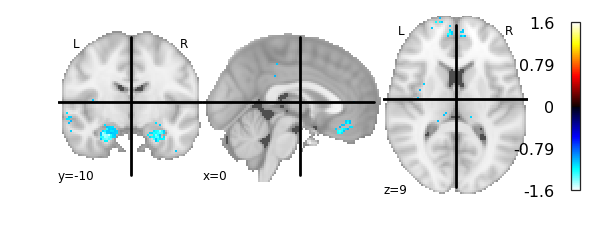

In [363]:
plt.close()
plotting.plot_stat_map(vec1_dat)
plt.show()
#vec1_dat.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_first_vector')

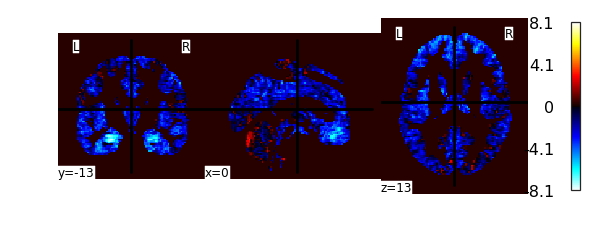

In [360]:
v1d = vec1_dat.get_data()
z = (v1d - v1d.mean()) / v1d.std()
zimg = ni.Nifti1Image(z, vec1_dat.affine)
plt.close()
plotting.plot_stat_map(zimg)
plt.show()
#vec1_dat.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_strucx_first_vector')

In [ ]:
pca_tfm = pcalr_out_NEW['pca_object'].transform(xp.values.T)

In [373]:
top_600.shape

(601, 170)

In [201]:
# embs = emb['emb']
# for i in range(embs.shape[-1]):
#     print(i,stats.pearsonr(df.position_along_hipp_AP_axis, embs[:,i]))

## Now repeat for functional connectivity

In [218]:
cx_paths = sorted(glob('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/rsfmri_neurosynth/*'))
cx_coords = []
for i,cx in enumerate(cx_paths):
    cx_X = int(cx.split('_')[-3])
    cx_Y = int(cx.split('_')[-2])
    cx_Z = int(cx.split('_')[-1].split('.')[0])
    cx_coords.append([cx_X, cx_Y, cx_Z])
    

In [223]:
len(cx_coords)

96

In [228]:
coords = df.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values
coords.shape

(3,)

In [231]:
samp2func_mapping = {}
for i in df.index: 
    coords = df.loc[i,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].values
    dists = []
    for cc in cx_coords:
        dist = sum([abs(cc[0] - coords[0]), 
                    abs(cc[1] - coords[1]), 
                    abs(cc[2] - coords[2])])
        dists.append(dist)
    gind = np.argmin(dists)
    samp2func_mapping.update({i: gind})

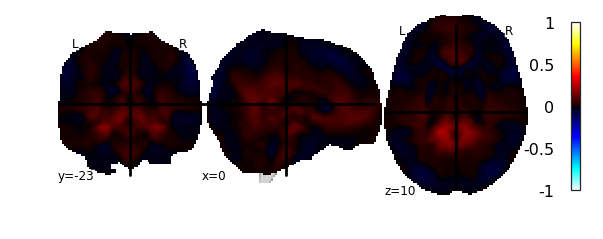

In [235]:
plt.close()
plotting.plot_stat_map(cx_paths[0])
plt.show()

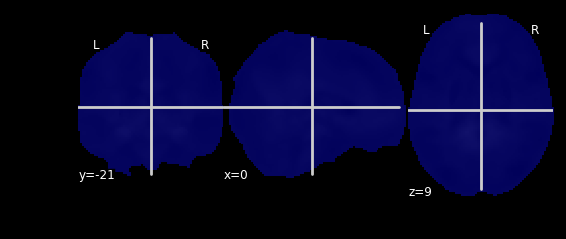

In [239]:
jnk = ni.load(cx_paths[0])
dat = jnk.get_data()
dat[dat!=0] = 1
mask = ni.Nifti1Image(dat, jnk.affine)
plt.close()
plotting.plot_roi(mask,cx_paths[0])
plt.show()

In [ ]:
#dkt = pandas.loa

In [240]:
maskr = input_data.NiftiMasker(mask_img=mask)
mjnk = maskr.fit_transform(jnk)
mjnk.shape

(1, 280494)

In [247]:
(170 * 280494) > (gdf.shape[0] * xp.shape[0])

False

In [260]:
i2d = np.zeros((len(df.index),mjnk.shape[-1]))
for samp, pth in samp2func_mapping.items():
    i2d[samp,:] = maskr.fit_transform(cx_paths[pth])[0,:]
    print(samp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169


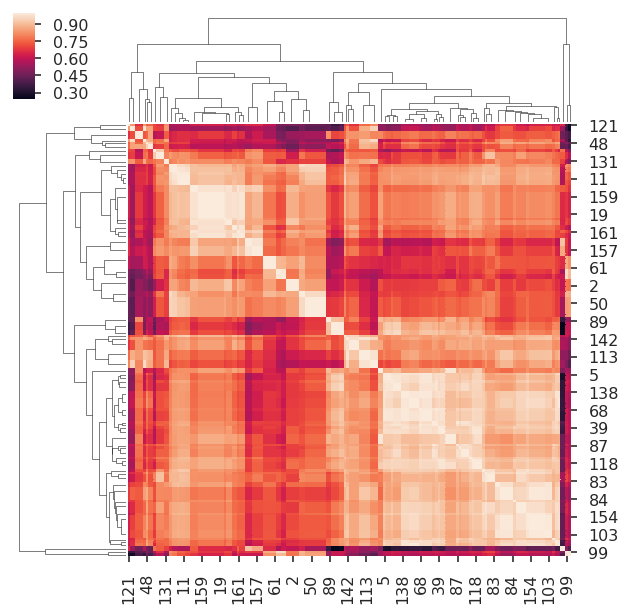

In [266]:
plt.close()
sns.clustermap(np.corrcoef(i2d))
plt.show()

In [267]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix', i2d)
jnk = {'all_mtx': i2d}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix',jnk)

In [882]:
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_emb_res.mat')

In [883]:
lambdas = res['res'][0][0][1]
lambdas / np.sum(lambdas)

array([[ 0.15569876,  0.14525424,  0.12899865,  0.11089619,  0.07912015,
         0.07637728,  0.07474735,  0.06023312,  0.04749339,  0.04393569,
         0.0402931 ,  0.03695209]])

In [480]:
fvecs = res['res'][0][0][4]
for i in range(fvecs.shape[-1]):
    print(i,stats.pearsonr(df.position_along_hipp_AP_axis, fvecs[:,i]))

0 (-0.19221446718872909, 0.012034173291901379)
1 (-0.29312930584039892, 0.00010475522311901664)
2 (0.47137922819137218, 8.7040929772990722e-11)
3 (0.62859770225888523, 4.4232849512832969e-20)
4 (-0.15034694366153231, 0.050352215437950217)
5 (0.14039534939576337, 0.067838062726704521)
6 (-0.19672385947831064, 0.010134178472836996)
7 (0.095896626285937245, 0.21350575311162612)
8 (0.13623088562524058, 0.0764948293923539)
9 (-0.15233563085137561, 0.047350751045484106)
10 (-0.17405092265867028, 0.023210153885215808)
11 (-0.062320650698759347, 0.41946370631964325)
12 (0.11694879510840497, 0.12881480381909757)


In [481]:
fvecs = res['res'][0][0][4]
for i in range(fvecs.shape[-1]):
    print(i,stats.pearsonr(df.predicted, fvecs[:,i]))

0 (-0.13802969783951821, 0.072651939101505025)
1 (-0.29541954391459813, 9.1901032933832988e-05)
2 (0.46962863789262121, 1.0433803156498566e-10)
3 (0.57316266439389063, 3.1355420059394188e-16)
4 (-0.10782604560385436, 0.16163580496164828)
5 (0.1461788272810346, 0.057157154508370445)
6 (-0.12118387352922425, 0.11544256056097506)
7 (0.045171744149959836, 0.55860096346151367)
8 (0.15214656072340957, 0.04762954059244634)
9 (-0.20589970506252667, 0.0070659007977376303)
10 (-0.20553123406049711, 0.0071710224567514023)
11 (-0.04207123900181492, 0.58593509313253489)
12 (0.10023392425937901, 0.19342072112932551)


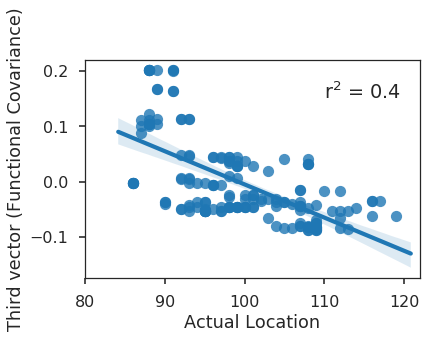

In [398]:
plt.close()
sns.regplot(df.position_along_hipp_AP_axis, fvecs[:,3]*-1)
plt.xlabel('Actual Location')
plt.ylabel('Third vector (Functional Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecs[:,3])
plt.text(110,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_actual.pdf',
           bbox_inches='tight')
plt.show()

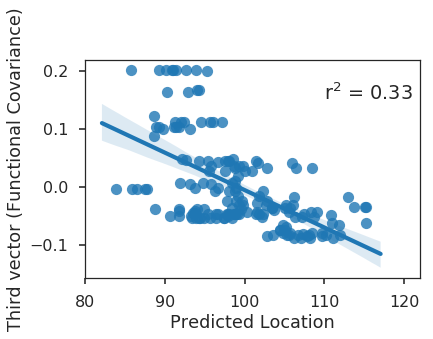

In [399]:
plt.close()
sns.regplot(df.predicted, fvecs[:,3]*-1)
plt.xlabel('Predicted Location')
plt.ylabel('Third vector (Functional Covariance)')
r,p = stats.pearsonr(df.predicted, fvecs[:,3])
plt.text(110,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_predicted.pdf',
           bbox_inches='tight')
plt.show()

In [320]:
vec3_cx = np.dot(i2d.T, vecs[:,3])

In [321]:
vec3_dat = maskr.inverse_transform(vec3_cx)

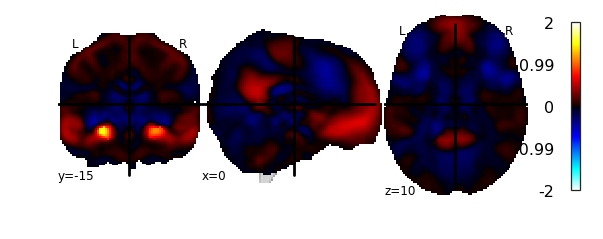

In [325]:
plt.close()
plotting.plot_stat_map(vec3_dat)
plt.show()
vec3_dat.to_filename('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_third_vector')

In [411]:
df.loc[:,'set1_predicted'] = MOD_t100['final_model'].predict(top_100.values.T)
df.loc[:,'set2_predicted'] = MOD_t100_600['final_model'].predict(PCA_t100_600)
df.loc[:,'set1_2_predicted'] = MOD_t600['final_model'].predict(PCA_600)
df.loc[:,'set3_predicted'] = MOD_t600_2700['final_model'].predict(PCA_t600_2700)
df.loc[:,'set1_2_3_predicted'] = MOD_t2700['final_model'].predict(PCA_t2700)

dme_res = pandas.DataFrame(index = range(2*6),
                           columns = ['modality','set','r2'])
c = 0
for i,vec in enumerate([svecs, fvecs]):
    if i == 0:
        lab = 'strucx'
        ind = 1
    else:
        lab = 'funcx'
        ind=3
    for col in df.columns[-6:]:
        r,p = stats.pearsonr(df[col], vec[:,ind])
        dme_res.loc[c,'modality'] = lab
        dme_res.loc[c,'set'] = col
        dme_res.loc[c,'r2'] = r**2
        c+=1

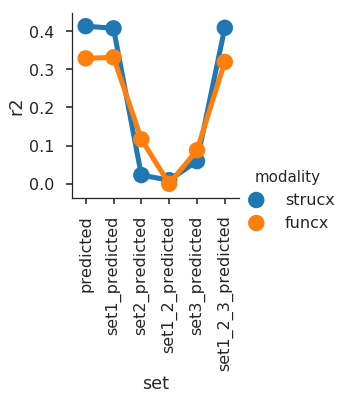

In [412]:
plt.close()
g = sns.factorplot(x='set',y='r2',hue='modality',data=dme_res)
g.set_xticklabels(rotation=90)
plt.show()

In [462]:
# MASKS TAKEN FROM GET CX VECTOR SECTION BELOW
mskrs = {}
for i, msk in enumerate([msk1, msk2, msk3, msk4]):
    l = i+1
    arr = np.zeros_like(msk)
    arr[msk.astype(int)>0] = 1
    jnk = ni.Nifti1Image(arr.astype(int), mni2mm.affine)
    mskr = input_data.NiftiMasker(jnk)
    mskrs.update({'msk%s'%l: mskr})

In [476]:
n_feats = len([x for x in mskrs['msk4'].mask_img.get_data().flat>0 if x])
i2d = np.zeros((len(df.index),n_feats))
for samp, pth in samp2func_mapping.items():
    i2d[samp,:] = mskrs['msk4'].fit_transform(cx_paths[pth])[0,:]
    print(samp)

In [477]:
np.savez_compressed('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX', i2d)
jnk = {'all_mtx': i2d}
savemat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_ALL_coords_matrix_CTX',jnk)

In [1093]:
len((lambdas / np.sum(lambdas))[0,:])

12

In [1099]:
lambdas.shape

(1, 12)

In [1097]:
res['res'][0][0][4].shape

(170, 13)

In [1109]:
emb['emb'].shape

(170, 10)

In [1112]:
fvecsCTX = emb['emb']
for i in range(fvecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,i])
    dme_resf.loc[i,'r2'] = r**2
    dme_resf.loc[i,'p'] = p
    print(i,r,p)

0 -0.183619241649 0.0165365119595
1 0.455208532785 4.46900136734e-10
2 -0.677809017261 3.26942688204e-24
3 0.174552912258 0.0228097177976
4 -0.0919652516656 0.232962244882
5 0.273606487579 0.000305949987661
6 -0.0236056400635 0.759946003729
7 -0.050305185265 0.514741307898
8 -0.187473884835 0.0143623026723
9 -0.211367197729 0.00565938737214


In [1118]:
res['res'][0][0][2][0][0]

10

In [1122]:
res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]

(10,)

In [1126]:
dme_resf.shape

(10, 3)

In [1128]:
df.columns

Index(['Unnamed: 0', 'donor', 'sample', 'structure_id', 'slab_num', 'well_id',
       'slab_type', 'structure_acronym', 'structure_name', 'polygon_id',
       'mri_voxel_x', 'mri_voxel_y', 'mri_voxel_z', 'mni_x', 'mni_y', 'mni_z',
       'gabe_label', 'mni_nlin_x', 'mni_nlin_y', 'mni_nlin_z',
       'position_along_hipp_AP_axis', 'bilateral_structure_name', 'hemisphere',
       'ntn1', 'fstl4', 'rsph9', 'nr2f2', 'fam43b', 'All 58k', 'Set 1',
       'Set 2', 'Set 1,2', 'Set 3', 'Set 1,2,3'],
      dtype='object')

In [1129]:
from statsmodels.sandbox.stats.multicomp import multipletests
emb = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_emb.mat')
res = loadmat('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/funcx_diff_CTX_emb_res.mat')
fvecsCTX = emb['emb']
dme_resf = pandas.DataFrame(index=range(fvecsCTX.shape[-1]), columns = ['position_r2','predicted_r2','predicted_p'])

# stats
for i in range(fvecsCTX.shape[-1]):
    r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,i])
    dme_resf.loc[i,'position_r2'] = r**2
    r,p = stats.pearsonr(df['All 58k'], fvecsCTX[:,i])
    dme_resf.loc[i,'predicted_r2'] = r**2
    dme_resf.loc[i,'predicted_p'] = p

# p-correction
dme_resf.loc[:,'p(corrected)'] = multipletests(dme_resf.predicted_p,method='bonferroni')[1]

# explained variance
lambdas = res['res'][0][0][1][0][:res['res'][0][0][2][0][0]]
dme_resf.loc[:,'Expl. Var of Gradient'] = (lambdas / np.sum(lambdas))

dme_resf

position_r2 predicted_r2  predicted_p p(corrected)  Expl. Var of Gradient
0     0.033716    0.0318459    0.0198954     0.198954               0.178543
1     0.207215     0.209002  3.68212e-10  3.68212e-09               0.157541
2     0.459425     0.398209  2.87252e-20  2.87252e-19               0.135064
3    0.0304687     0.015419     0.106674            1               0.118252
4   0.00845761  0.000657191     0.740012            1               0.091784
5    0.0748605    0.0619135   0.00106808    0.0106808               0.086254
6  0.000557226   0.00621349      0.30689            1               0.078544
7   0.00253061  5.46604e-07     0.992366            1               0.063419
8    0.0351465     0.038701    0.0101335     0.101335               0.050019
9    0.0446761    0.0399738   0.00894785    0.0894785               0.040582

In [1131]:
dme_resf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_F_table.csv')

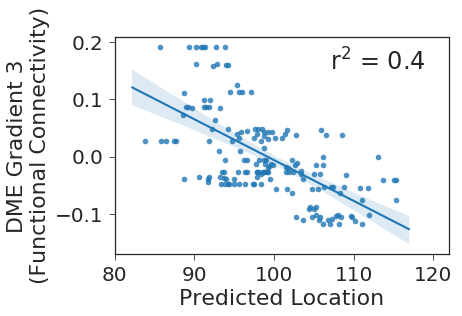

In [528]:
plt.close()
sns.regplot(df['All 58k'], fvecsCTX[:,3])
plt.xlabel('Predicted Location')
plt.ylabel('DME Gradient 3\n(Functional Connectivity)')
r,p = stats.pearsonr(df['All 58k'], fvecsCTX[:,3])
plt.text(107,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_predicted_CTX.pdf',
           bbox_inches='tight')
plt.show()

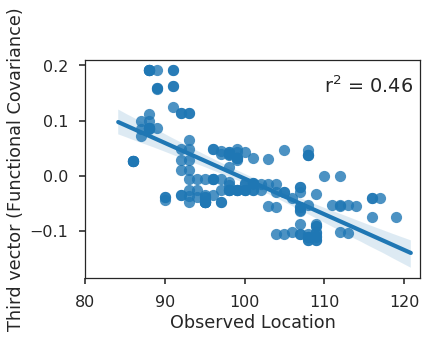

In [490]:
plt.close()
sns.regplot(df.position_along_hipp_AP_axis, fvecsCTX[:,3])
plt.xlabel('Observed Location')
plt.ylabel('Third vector (Functional Covariance)')
r,p = stats.pearsonr(df.position_along_hipp_AP_axis, fvecsCTX[:,3])
plt.text(110,0.15, 'r$^2$ = %s'%round(r**2,2))
plt.xlim(80, 122)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_funcx_observed_CTX.pdf',
           bbox_inches='tight')
plt.show()

(170, 170)

performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.801989880112
running final model
final model fit r2 =  0.912103768448
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.791508887129
running final model
final model fit r2 =  0.849823136228
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.815523673718
running final model
final model fit r2 =  0.87145324415
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.828136755296
running final model
final model fit r2 =  0.903513216179
running sanity_check
running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation
model cv score: r2 =  0.828001139061
running final model
final mod

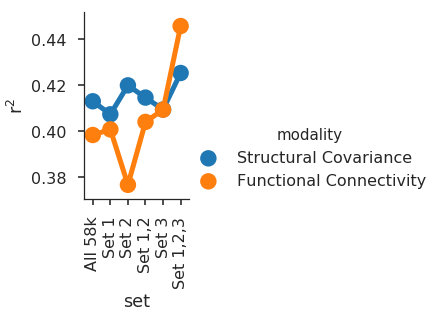

In [510]:
# df.loc[:,'Set 1'] = MOD_t100['final_model'].predict(top_100.values.T)
# df.loc[:,'Set 2'] = MOD_t100_600['final_model'].predict(PCA_t100_600)
# df.loc[:,'Set 1,2'] = MOD_t600['final_model'].predict(PCA_600)
# df.loc[:,'Set 3'] = MOD_t600_2700['final_model'].predict(PCA_t600_2700)
# df.loc[:,'Set 1,2,3'] = MOD_t2700['final_model'].predict(PCA_t2700)

df.columns = df.columns[:-6].tolist() + ['All 58k','Set 1','Set 2','Set 1,2','Set 3','Set 1,2,3' ]
dme_res = pandas.DataFrame(index = range(2*6),
                           columns = ['modality','set','r2'])
c = 0
gsets = [top_100, top_100_600, top_600, top_600_2700, top_2700]
for l,col in enumerate(df.columns[-6:]):
    if l == 0:
        predicted = df[col].values
    else:
        gset = gsets[l-1]
        if col == 'Set 1':
            pcalr_res = PCA_LR_pipeline(gset.values.T,
                                        (df.position_along_hipp_AP_axis), pca=None,
                                        clf = linear_model.LassoCV(cv=10,max_iter=5000),
                                        cv_strategy='score', illustrative=False,
                                       sanity_check_style = 'model')
            predicted = pcalr_res['final_model'].predict(gset.values.T)
        else:
            pcalr_res = PCA_LR_pipeline(gset.values.T, 
                                        (df.position_along_hipp_AP_axis),
                                        clf = linear_model.LassoCV(cv=10),
                                        cv_strategy='score', illustrative=False,
                                       sanity_check_style = 'model')
            predicted = pcalr_res['final_model'].predict(pcalr_res['pca_object'].transform(gset.values.T))
        df[col] = predicted
    for i,vec in enumerate([svecs, fvecsCTX]):
        if i == 0:
            lab = 'Structural Covariance'
            ind = 1
        else:
            lab = 'Functional Connectivity'
            ind=3
        r,p = stats.pearsonr(df[col], vec[:,ind])
        dme_res.loc[c,'modality'] = lab
        dme_res.loc[c,'set'] = col
        dme_res.loc[c,'r2'] = r**2
        c+=1


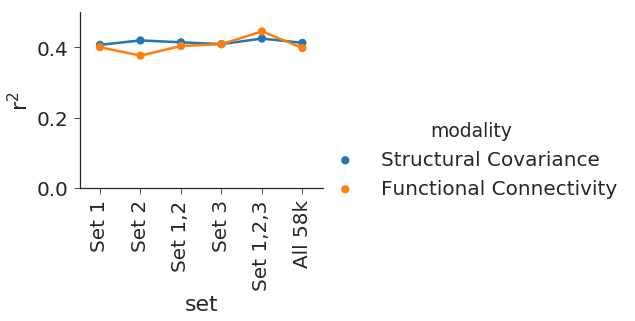

In [522]:
sns.set_context('paper', font_scale=2.5)
plt.close()
g = sns.factorplot(x='set',y='r2',hue='modality',data=dme_res, aspect=1.5,
                   order=['Set 1','Set 2','Set 1,2','Set 3','Set 1,2,3', 'All 58k'])
g.set_xticklabels(rotation=90)
plt.ylabel('r$^2$')
plt.ylim(0,0.5)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/DME_Set_comp.pdf',
           bbox_inches='tight')
plt.show()

In [258]:
ant_image.shape

(91, 109, 91)

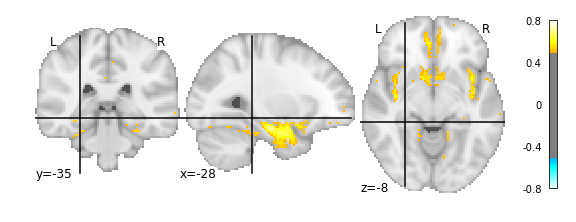

In [260]:
plt.close()
plotting.plot_stat_map(ni.Nifti1Image(ant_image, gmvs.affine), cut_coords=(-28,-35,-8), threshold=0.5, vmax=0.8)
plt.show()

In [256]:
input_img = gmvs
vdim = 2
outdir = None
mask_thr = 0.2
ant_cut = 108
post_cut = 84

print('initializing')
i4d = input_img.get_data()
avg_image = i4d.mean(3)
mask = np.zeros_like(avg_image)
mask[avg_image>mask_thr] = 1
mskr = input_data.NiftiMasker(ni.Nifti1Image(mask,input_img.affine))
i2d = mskr.fit_transform(input_img)

print('creating anterior connectivity map')
antdf = df[df[col]>=ant_cut][['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
cdf = antdf
rmat = np.zeros((len(cdf),i2d.shape[1]))
for i,c in enumerate(cdf.index):
    coord = [int(round(x)) for x in convert_coords(cdf.loc[c].values, 'xyz', vdim)]
    print('computing %s of %s connectivity maps'%(i+1,len(cdf)))
    cvec = i4d[coord[0],coord[1],coord[2],:]
    rs = [stats.pearsonr(cvec,i2d[:,x])[0] for x in range(i2d.shape[1])]
    rmat[i,:] = rs
print(rmat.shape)
rvec = rmat.mean(0)
print(rvec.shape)
r_mtx = np.repeat(np.array(rvec)[:, np.newaxis], i2d.shape[0], axis=1).T
ant_mtx = r_mtx
ant_image = mskr.inverse_transform(ant_mtx).get_data().mean(3)

print('creating posterior connectivity map')
postdf = df[df[col]<=post_cut][['mni_nlin_x','mni_nlin_y','mni_nlin_z']]
post_mtx = get_structural_connectivity(postdf, i2d, vdim)
post_image = mskr.inverse_transform(post_mtx).get_data().mean(3)

diff_image = np.Nifti1Image((ant_image - post_image), input_img.affine)
ant_image = np.Nifti1Image(ant_image,input_img.affine)
print(i2d.shape)
print(r_mtx.shape)
post_image = np.Nifti1Image(post_image,input_img.affine)
output = {'anterior': ant_image,
         'posterior': post_image,
         'difference': diff_image}

if outdir:
    for lab, image in output.items():
        image.to_filename(os.path.join(wdir,'%s_%s'%(outname,lab)))

initializing
creating anterior connectivity map
computing 1 of 35 connectivity maps
computing 2 of 35 connectivity maps
computing 3 of 35 connectivity maps
computing 4 of 35 connectivity maps
computing 5 of 35 connectivity maps
computing 6 of 35 connectivity maps
computing 7 of 35 connectivity maps
computing 8 of 35 connectivity maps
computing 9 of 35 connectivity maps
computing 10 of 35 connectivity maps
computing 11 of 35 connectivity maps
computing 12 of 35 connectivity maps
computing 13 of 35 connectivity maps
computing 14 of 35 connectivity maps
computing 15 of 35 connectivity maps
computing 16 of 35 connectivity maps
computing 17 of 35 connectivity maps
computing 18 of 35 connectivity maps
computing 19 of 35 connectivity maps
computing 20 of 35 connectivity maps
computing 21 of 35 connectivity maps
computing 22 of 35 connectivity maps
computing 23 of 35 connectivity maps
computing 24 of 35 connectivity maps
computing 25 of 35 connectivity maps
computing 26 of 35 connectivity maps

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice.
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


MemoryError: 

# Get all cx vectors

In [444]:
mni2mm = ni.load('/usr/share/fsl/data/standard/MNI152_T1_2mm_brain.nii.gz')
dkt = ni.load('/home/users/jvogel/Science/templates/atlases/dkt_atlas_1mm.nii')
f_diff = ni.load('/home/users/jvogel/git/Hippocampus_AP_Axis/maps/p_over_a_rsfmri.nii.gz')
d_diff = ni.load('/home/users/jvogel/git/Hippocampus_AP_Axis/maps/AD-FTD_globalnorm2.nii.gz')
s_diff = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/strucx_z_difference.nii')
HO2mm = ni.load('/usr/share/fsl/data/atlases/HarvardOxford/HarvardOxford-sub-maxprob-thr0-2mm.nii.gz').get_data()
diffs = {'fmri':f_diff, 'dis': d_diff, 'struc': s_diff, 'dkt': dkt}
diffs_2mm = {}
for lab,diff in diffs.items():
    print(lab,diff.shape)
    nimg = image.resample_to_img(diff, mni2mm)
    print('new shape', nimg.shape)
    diffs_2mm.update({lab: nimg})

fmri (182, 218, 182)
new shape (91, 109, 91)
dis (121, 145, 121)
new shape (91, 109, 91)
struc (91, 109, 91, 1)
new shape (91, 109, 91, 1)
dkt (182, 218, 182)
new shape (91, 109, 91)


In [445]:
dkt2 = diffs_2mm['dkt'].get_data()

msk1 = np.array(HO2mm,copy=True)
msk1[HO2mm<1] = 0
#no cereb or brainstem
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0
msk2 = np.array(dkt2, copy=True)
msk2[msk2>78] = 0

# no cereb, brainstem or hippocampus
msk3 = np.array(msk2, copy=True)
msk3[dkt2==36] = 0
msk3[dkt2==75] = 0

# cortex only (no subcortex)
msk4 = np.array(msk3, copy=True)
msk4[dkt2>31] = 0
msk4[dkt2>41] = dkt2[dkt2>41]
msk4[dkt2>70] = 0

In [77]:
vectors = {}

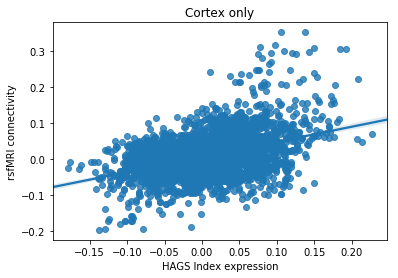

standard statistics: r2 = 0.169855769426, p = 1.19572384377e-136


In [78]:
# functional & genetic

img = diffs_2mm['fmri'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','rsfMRI connectivity']
res, vex = run_gvfcx_analysis(img, gdf, msk2, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'gcx': vex['g_vector'], 'fcx': vex['cx_vector']})

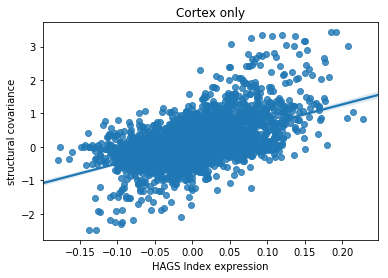

standard statistics: r2 = 0.283649798061, p = 3.07429669376e-243


In [79]:
# structural

img = diffs_2mm['struc'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','structural covariance']
res, vex = run_gvfcx_analysis(img, gdf, msk2, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'scx': vex['cx_vector']})

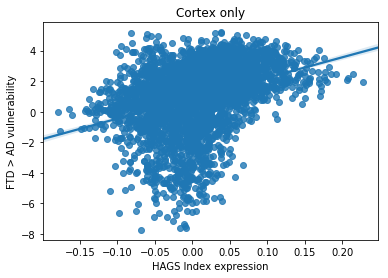

standard statistics: r2 = 0.118291777829, p = 4.77303911885e-93


In [80]:
# disease

img = diffs_2mm['dis'].get_data()
vrad=3
vdim = 2
gcx_col='AP_axis_gxp_signature_similarity_SPCR'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','FTD > AD vulnerability']
res, vex = run_gvfcx_analysis(img, gdf, msk2, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)
vectors.update({'dcx': vex['cx_vector']})

In [167]:
all_vex = pandas.DataFrame.from_dict(vectors)
for col in all_vex.columns:
    if col == 'dcx':
        all_vex.loc[:,'%s_bin'%col] = ['FTD Vulnerable' if x > 0 else 'AD Vulnerable' for x in all_vex[col].values]
    elif col == 'gcx':
        all_vex.loc[:,'%s_bin'%col] = ['Like Ant. Hipp.' if x > 0 else 'Like Post. Hipp.' for x in all_vex[col].values]
    else:
        all_vex.loc[:,'%s_bin'%col] = ['Ant. Connected' if x > 0 else 'Post. Connected' for x in all_vex[col].values]
        

In [171]:
all_vex.head()

dcx       fcx       gcx       scx         dcx_bin          fcx_bin  \
0  1.936761 -0.017439  0.017612  0.500187  FTD Vulnerable  Post. Connected   
1  3.481936  0.030193 -0.048591  0.670868  FTD Vulnerable   Ant. Connected   
2  3.063823  0.028174 -0.001852  0.744531  FTD Vulnerable   Ant. Connected   
3  3.706228  0.032463  0.006891  0.344802  FTD Vulnerable   Ant. Connected   
4  2.084073  0.032044 -0.024976  0.308254  FTD Vulnerable   Ant. Connected   

            gcx_bin         scx_bin  
0   Like Ant. Hipp.  Ant. Connected  
1  Like Post. Hipp.  Ant. Connected  
2  Like Post. Hipp.  Ant. Connected  
3   Like Ant. Hipp.  Ant. Connected  
4  Like Post. Hipp.  Ant. Connected

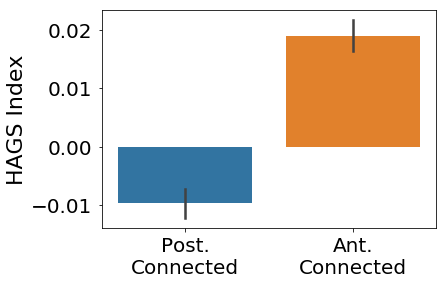

Ttest_indResult(statistic=15.256842243801975, pvalue=7.5155503765664806e-51)


In [170]:
plt.close()
sns.set_context('paper', font_scale=2.5)
g = sns.barplot(x = 'fcx_bin', y = 'gcx', data=all_vex)
g.set_xticklabels(['Post.\nConnected', 'Ant.\nConnected'])
g.set_xlabel('')
g.set_ylabel('HAGS Index')
#plt.ylim(-0.035, 0.035)
plt.show()
print(stats.ttest_ind(all_vex[all_vex.fcx_bin=='Ant. Connected']['gcx'],
                      all_vex[all_vex.fcx_bin=='Post. Connected']['gcx']))

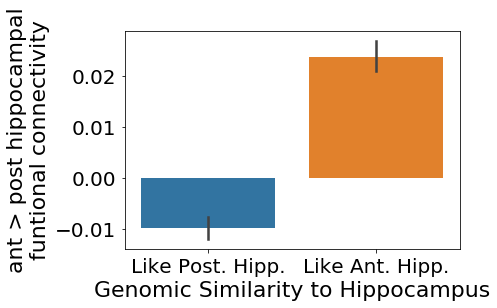

In [183]:
plt.close()
sns.set_context('paper', font_scale=2.5)
g = sns.barplot(x = 'gcx_bin', y = 'fcx', data=all_vex, order = ['Like Post. Hipp.', 'Like Ant. Hipp.'])
g.set_xticklabels(['Like Post. Hipp.', 'Like Ant. Hipp.'])
g.set_ylabel('ant > post hippocampal\nfuntional connectivity')
g.set_xlabel('Genomic Similarity to Hippocampus')
#plt.ylim(-0.035, 0.035)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/rsfmri_cat_HAGS.pdf',
           bbox_inches = 'tight')
plt.show()


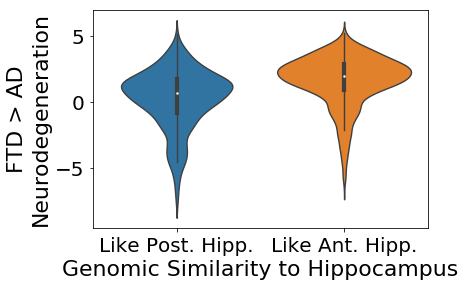

In [223]:
plt.close()
sns.violinplot(x = 'gcx_bin', y = 'dcx', data=all_vex, order = ['Like Post. Hipp.', 'Like Ant. Hipp.'])
plt.xlabel('Genomic Similarity to Hippocampus')
plt.ylabel('FTD > AD\nNeurodegeneration')
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/disease_cat_HAGS.pdf',
           bbox_inches = 'tight')
#plt.ylim(-0.035, 0.035)
plt.show()


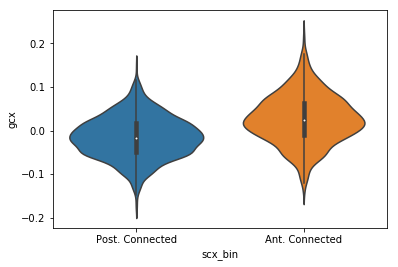

Ttest_indResult(statistic=22.945363245001186, pvalue=2.7599690254494644e-108)


In [117]:
plt.close()
sns.violinplot(x = 'scx_bin', y = 'gcx', data=all_vex, order=['Post. Connected','Ant. Connected',])
#plt.ylim(-0.035, 0.035)
plt.show()
print(stats.ttest_ind(all_vex[all_vex.scx_bin=='Ant. Connected']['gcx'],
                      all_vex[all_vex.scx_bin=='Post. Connected']['gcx']))

In [214]:
print("\N{GREEK CAPITAL LETTER DELTA}" )

Δ


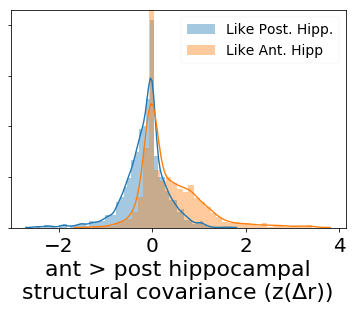

In [218]:
plt.close()
sns.distplot(all_vex[all_vex.gcx_bin=='Like Post. Hipp.']['scx'], label = 'Like Post. Hipp.')
g = sns.distplot(all_vex[all_vex.gcx_bin=='Like Ant. Hipp.']['scx'], label = 'Like Ant. Hipp')
plt.legend(fontsize='xx-small')
g.set_yticklabels(['' for x in g.get_yticklabels()])
g.set_xlabel('ant > post hippocampal\nstructural covariance (z(\N{GREEK CAPITAL LETTER DELTA}r))')
#plt.ylim(0, 3)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/scx_cat_HAGS.pdf',
           bbox_inches = 'tight')
plt.show()


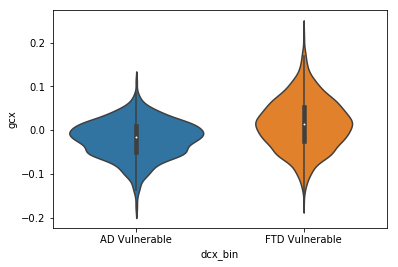

Ttest_indResult(statistic=16.056871767965429, pvalue=6.1537736527117834e-56)


In [118]:
plt.close()
sns.violinplot(x = 'dcx_bin', y = 'gcx', data=all_vex, order=['AD Vulnerable','FTD Vulnerable',])
#plt.ylim(-0.035, 0.035)
plt.show()
print(stats.ttest_ind(all_vex[all_vex.dcx_bin=='FTD Vulnerable']['gcx'],
                      all_vex[all_vex.dcx_bin=='AD Vulnerable']['gcx']))

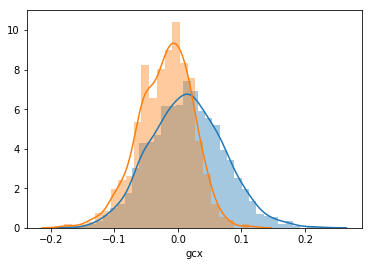

In [122]:
plt.close()
sns.distplot(all_vex[all_vex.dcx_bin=='FTD Vulnerable']['gcx'])
sns.distplot(all_vex[all_vex.dcx_bin=='AD Vulnerable']['gcx'])
plt.ylim(0,11)
plt.show()

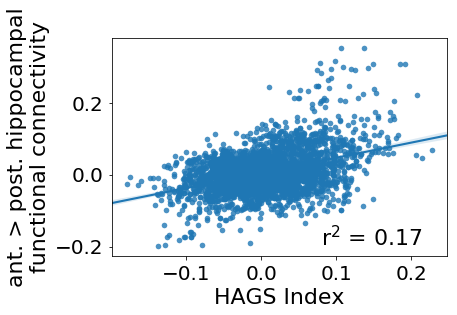

In [212]:
g_cx = all_vex.gcx.values
f_cx = all_vex.fcx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, f_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('ant. > post. hippocampal\nfunctional connectivity')
r2 = stats.pearsonr(g_cx,f_cx)[0]**2
plt.text(0.08, -0.20,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/rsfmri_HAGS.pdf',
           bbox_inches = 'tight')
plt.show()

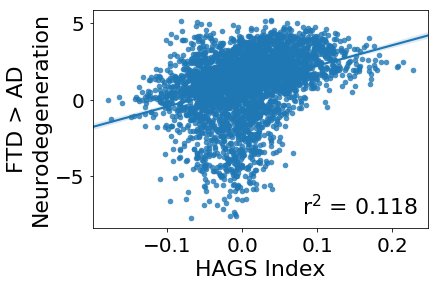

In [219]:
d_cx = all_vex.dcx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, d_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('FTD > AD\nNeurodegeneration')
r2 = stats.pearsonr(g_cx, d_cx)[0]**2
plt.text(0.08, -7.5,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/FDG_HAGS.pdf',
            bbox_inches = 'tight')
plt.show()


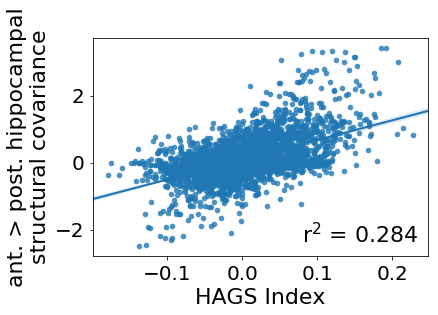

In [213]:
s_cx = all_vex.scx.values
plt.close()
sns.set_context('paper', font_scale=2.5)
sns.regplot(g_cx, s_cx)
#plt.title(plabs[0])
plt.xlabel('HAGS Index')
plt.ylabel('ant. > post. hippocampal\nstructural covariance')
r2 = stats.pearsonr(g_cx, s_cx)[0]**2
plt.text(0.08, -2.4,'r$^2$ = %s'%float('%.3g'%r2), fontsize=22)
plt.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/scx_HAGS.pdf',
            bbox_inches = 'tight')
plt.show()


In [565]:
vec100 = get_gene_vector(bigdf,probe_ids=top_100.index, betas=MOD_t100['betas'])
vec1_600 = get_gene_vector(bigdf,probe_ids=top_100_600.index, betas=MOD_t100_600['betas'])
vec600 = get_gene_vector(bigdf, probe_ids=top_600.index,betas=MOD_t600['betas'])
vec6_2700 = get_gene_vector(bigdf,probe_ids=top_600_2700.index, betas=MOD_t600_2700['betas'])
vec2700 = get_gene_vector(bigdf,probe_ids=top_2700.index,betas=MOD_t2700['betas'])
vec5k = get_gene_vector(bigdf,probe_ids=mod_genes[mod_genes.step<5].index)

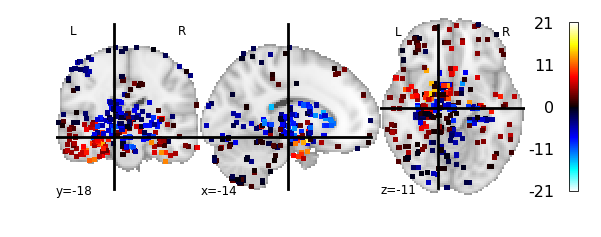

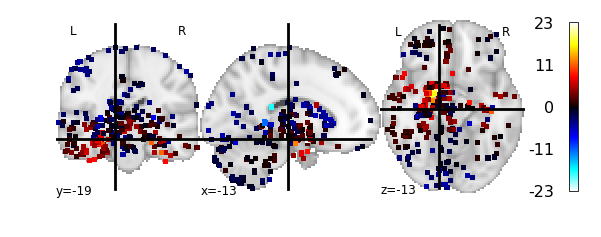

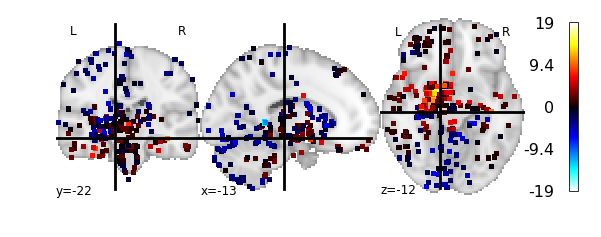

In [383]:
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
input_coords = []
for i,row in gdf.iterrows():
    input_coords.append(convert_coords([round(int(row['mni_nlin_x'])), 
                                        round(int(row['mni_nlin_y'])), 
                                        round(int(row['mni_nlin_z']))], 'xyz'))
vex = {'100': vec100, '600': vec600, '2700': vec2700}
for n_probes,vec in vex.items():
    nm = 'XPIMG_%s_top_probes'%n_probes
    gcx_img = make_expression_image(vec, input_coords, mni, wdir, nm, 3, return_img=True)
    plt.close()
    plotting.plot_stat_map(gcx_img)
    plt.show()

In [225]:
diffs_2mm.keys()

dict_keys(['fmri', 'dis', 'struc', 'dkt'])

In [239]:
res['r2'].values[0]

0.11829177782899052

In [257]:
msks = {'Whole brain': msk1, 'No Cereb/Brainstem': msk2, 
        'No Hippocampus': msk3, 'Cortex only': msk4}
imods = ['fmri','dis','struc']
gsets = {'vec100': vec100, 'vec1_600': vec1_600, 'vec600': vec600, 
         'vec6_2700': vec6_2700, 'vec2700': vec2700, 'all': 'all'}
gset_res = pandas.DataFrame(index = range(len(imods) * len(msks.keys()) * len(gsets.keys())),
                            columns = ['modality', 'mask', 'gene_set', 'r2'])
gcx_col='gvec'
vrad = 3
vdim = 2
bootstrap = False
plabs = ['HAGS v Imaging', 'HAGS', 'Imaging']
i=0
for imod in imods:
    img = diffs_2mm[imod].get_data()
    for glab, gset in gsets.items():
        if gset == 'all':
            gdf.loc[:,'gvec'] = gdf.AP_axis_gxp_signature_similarity_SPCR.values
        else:
            gdf.loc[:,'gvec'] = gset
        for mlab, msk in msks.items():
            res, vex = run_gvfcx_analysis(img, gdf, msk, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=False)
            gset_res.loc[i,'modality'] = imod
            gset_res.loc[i,'gene_set'] = glab
            gset_res.loc[i,'mask'] = mlab
            gset_res.loc[i,'r2'] = res['r2'].values[0]
            i += 1
    print('finished',imod)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


standard statistics: r2 = 0.230920243648, p = 1.09439753179e-200
standard statistics: r2 = 0.236635414488, p = 2.73410886168e-197
standard statistics: r2 = 0.175796090851, p = 1.61935915947e-133
standard statistics: r2 = 0.13790841134, p = 1.35149333997e-87
standard statistics: r2 = 0.19142252048, p = 8.41885763522e-163
standard statistics: r2 = 0.196941442942, p = 1.2242336611e-160
standard statistics: r2 = 0.119913469242, p = 7.10413342607e-89
standard statistics: r2 = 0.104343612156, p = 1.56678145882e-65
standard statistics: r2 = 0.229357380307, p = 3.75582958601e-199
standard statistics: r2 = 0.23389803373, p = 1.05824000688e-194
standard statistics: r2 = 0.156546818233, p = 8.23340603273e-118
standard statistics: r2 = 0.134135098635, p = 4.49587702569e-85
standard statistics: r2 = 0.140331009565, p = 1.96415809314e-116
standard statistics: r2 = 0.142167636837, p = 6.48630917324e-113
standard statistics: r2 = 0.0820390570312, p = 3.57089321844e-60
standard statistics: r2 = 0.07283

In [258]:
nkey = {'vec100': 'Set 1', 'vec1_600': 'Set 2', 'vec600': 'Sets 1,2', 
        'vec6_2700': 'Set 3', 'vec2700': 'Sets 1,2,3', 'all': 'All 58k' }
gset_res.loc[:,'gene_set'] = [nkey[x] for x in gset_res.gene_set.values]

In [259]:
nkey = {'fmri': 'FC', 'struc': 'SC', 'dis': 'Disease'}
gset_res.loc[:,'modality'] = [nkey[x] for x in gset_res.modality]
gset_res.columns = ['analysis' if x == 'modality' else x for x in gset_res.columns]

In [260]:
gset_res.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_geneset_v_img_modality.csv')

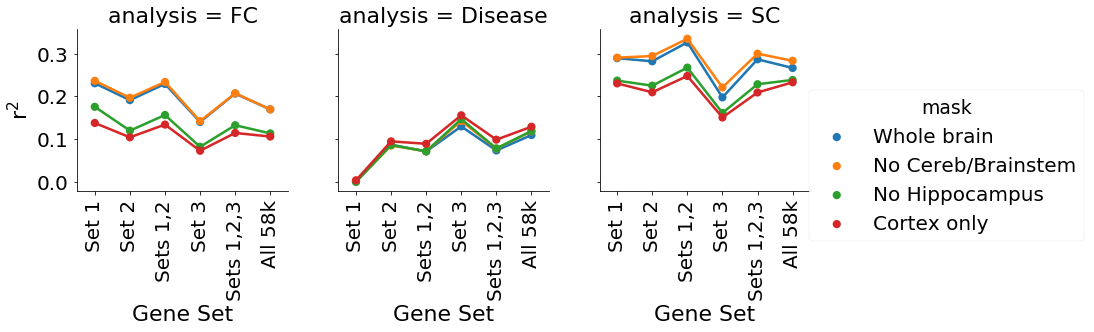

In [265]:
plt.close()
g = sns.factorplot(x = 'gene_set', y = 'r2', hue = 'mask', col = 'analysis', data = gset_res)
g.set_xticklabels(rotation = 90)
g.set_xlabels('Gene Set')
g.set_ylabels('r$^2$')
g.savefig('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/figs/GeneSet_v_imaging.pdf')
plt.show()

In [256]:
res

r2             p
3  0.233169  3.63008e-155

In [267]:
diffs_2mm.keys()

dict_keys(['fmri', 'dis', 'struc', 'dkt'])

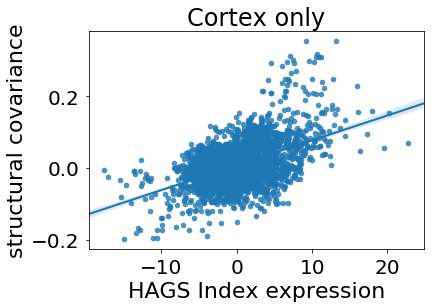

standard statistics: r2 = 0.23389803373, p = 1.05824000688e-194


In [269]:
# structural
# sns.set_context('notebook')
# gdf.loc[:,'vec100'] = vec100
img = diffs_2mm['fmri'].get_data()
vrad=3
vdim = 2
gdf.loc[:,'gvec'] = vec600
gcx_col='gvec'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','structural covariance']
res, vex = run_gvfcx_analysis(img, gdf, msk2, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)


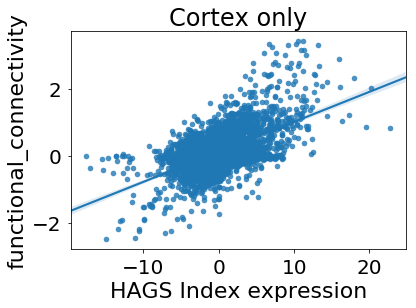

standard statistics: r2 = 0.335182431948, p = 3.40630582063e-297


In [270]:
# functional
img = diffs_2mm['struc'].get_data()
vrad=3
vdim = 2
gdf.loc[:,'gvec'] = vec600
gcx_col='gvec'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','functional_connectivity']
res, vex = run_gvfcx_analysis(img, gdf, msk2, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)


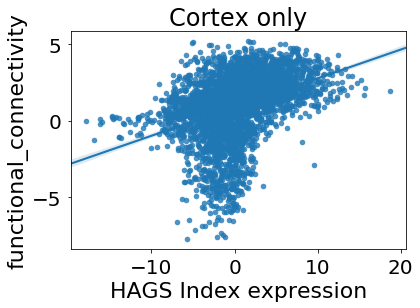

standard statistics: r2 = 0.142828637474, p = 1.79583390355e-113


In [271]:
# functional
img = diffs_2mm['dis'].get_data()
vrad=3
vdim = 2
gdf.loc[:,'gvec'] = vec6_2700
gcx_col='gvec'
bootstrap = False
plabs = ['Cortex only',
         'HAGS Index expression','functional_connectivity']
res, vex = run_gvfcx_analysis(img, gdf, msk2, vrad, vdim, gcx_col, plabs, 
                       bootstrap, n_iter=10, hue_vals=[], illustrative=True)


In [410]:
gdf.to_csv('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/MAIN_gcx_wholebrain_info_W_SMALL_SETS.csv')

# Boris & Reinder

In [87]:
mni = ni.load('/home/users/jvogel/Science/templates/templates/MNI152_T1_1mm_brain.nii')
mnip7 = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Bernhardt/MNI152_T1_0.7mm.nii.gz')
gradient = ni.load('/home/users/jvogel/Science/Allen_Human_Brain_Atlas/Bernhardt/gradient1.nii.gz')

In [88]:
gradient_1mm = image.resample_to_img(gradient,mni)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:462: UserWarning: The behaviour of affine_transform with a one-dimensional array supplied for the matrix parameter has changed in scipy 0.18.0.
  "The behaviour of affine_transform with a one-dimensional "


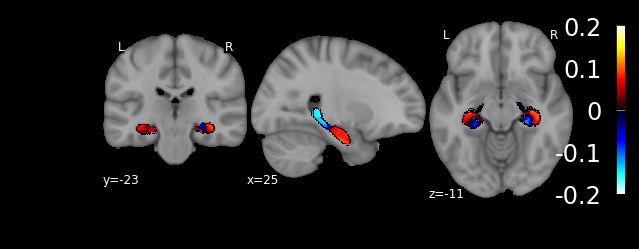

In [92]:
plt.close()
plotting.plot_stat_map(gradient_1mm,mni, draw_cross=False, threshold=0.001)
plt.show()

In [190]:
coords = [convert_coords(df.loc[x,['mni_nlin_x','mni_nlin_y','mni_nlin_z']].tolist(),'xyz') for x in df.index]

In [195]:
grad[[int(round(x)) for x in coords[0]]]

array([[[-0.,  0., -0., ...,  0.,  0., -0.],
        [ 0., -0.,  0., ..., -0., -0.,  0.],
        [-0.,  0., -0., ...,  0.,  0., -0.],
        ..., 
        [-0.,  0., -0., ..., -0., -0.,  0.],
        [ 0., -0.,  0., ...,  0.,  0., -0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[-0.,  0., -0., ...,  0.,  0., -0.],
        [ 0., -0.,  0., ..., -0., -0.,  0.],
        [-0.,  0., -0., ...,  0.,  0., -0.],
        ..., 
        [ 0., -0.,  0., ..., -0., -0.,  0.],
        [-0.,  0., -0., ...,  0.,  0., -0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0., -0.,  0., ...,  0.,  0., -0.],
        [-0.,  0., -0., ..., -0., -0.,  0.],
        [ 0., -0.,  0., ...,  0.,  0., -0.],
        ..., 
        [-0.,  0., -0., ..., -0., -0.,  0.],
        [ 0., -0.,  0., ...,  0.,  0., -0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]], dtype=float32)

In [198]:
grad = gradient_1mm.get_data()
vals = []
for i,coord in enumerate(coords):
    x,y,z = [int(round(x)) for x in coord]
    vals.append(grad[x,y,z])
df.loc[:,'reinder_gradient'] = vals

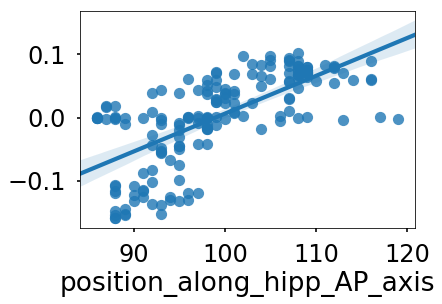

In [232]:
plt.close()
sns.regplot(df.position_along_hipp_AP_axis,df.reinder_gradient.values)
plt.show()

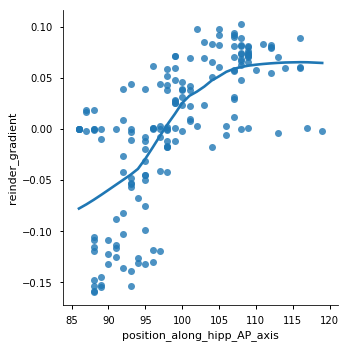

In [238]:
sns.set_context('notebook')
plt.close()
sns.lmplot(x='position_along_hipp_AP_axis', y='reinder_gradient', lowess=True, data=df)
plt.show()

In [234]:
sns.lmplot?

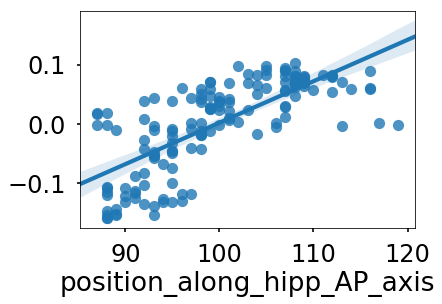

In [216]:
near_zero = [x for x in range(len(df.index)) if abs(vals[x]) < 0.001]
good_ind = [df.index[x] for x in range(len(df.index)) if x not in near_zero]
plt.close()
sns.regplot(df.loc[good_ind].position_along_hipp_AP_axis,df.loc[good_ind].reinder_gradient.values)
plt.show()

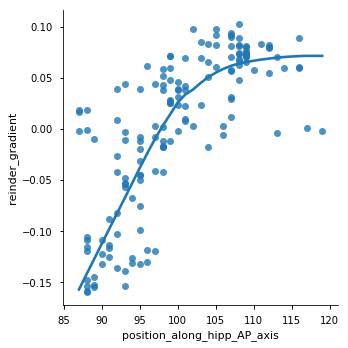

In [241]:
sns.set_context('notebook')
plt.close()
sns.lmplot(x='position_along_hipp_AP_axis', y='reinder_gradient', lowess=True, data=df.loc[good_ind])
plt.show()

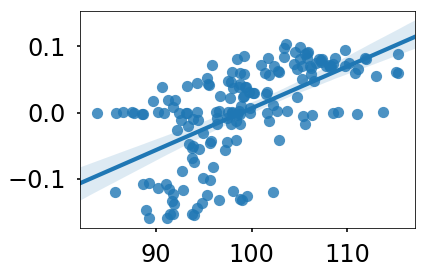

In [228]:
fit_mod = pcalr_out_NEW2['final_model']
pred = fit_mod.predict(pcalr_out_NEW2['pca_object'].transform(xp.values.T))
plt.close()
sns.regplot(pred,df.reinder_gradient.values)
plt.show()

running PCA
transforming data
performing model cross-validation
using basic 10-fold cross-validation


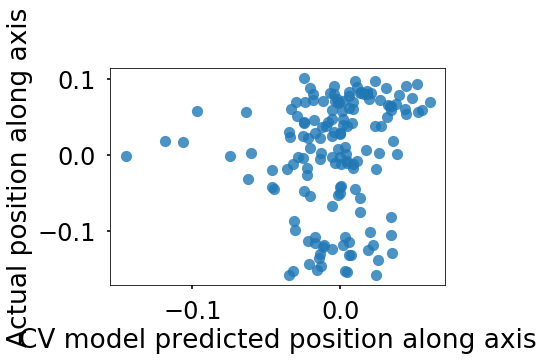

model cv score: r2 =  0.0170968223889
running final model
final model fit r2 =  0.502086083132


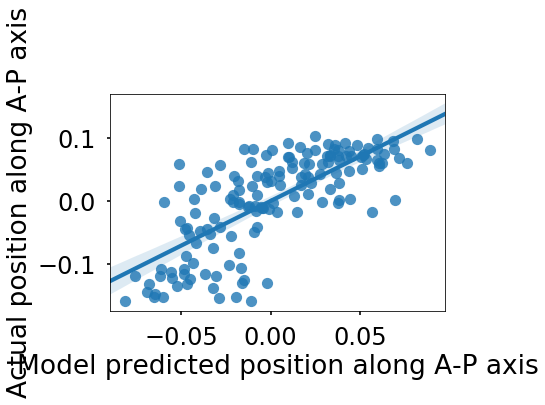

running sanity_check


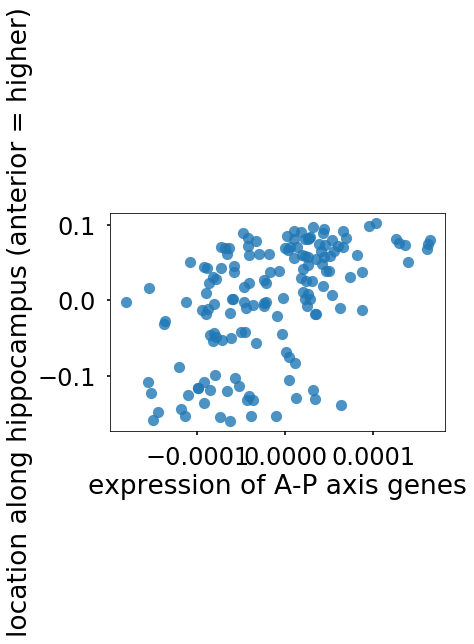

posterior and anterior 100 genes vs. y:  r2 = 0.253900639143, p = 4.24187436537e-11 




In [225]:
# testing weighted averages
x_ind = [xp.columns[x] for x in range(len(df.index)) if x not in near_zero]
pcr_out = PCA_LR_pipeline(xp[x_ind].values.T,
                            df.loc[good_ind].reinder_gradient, 
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

performing model cross-validation
using basic 10-fold cross-validation


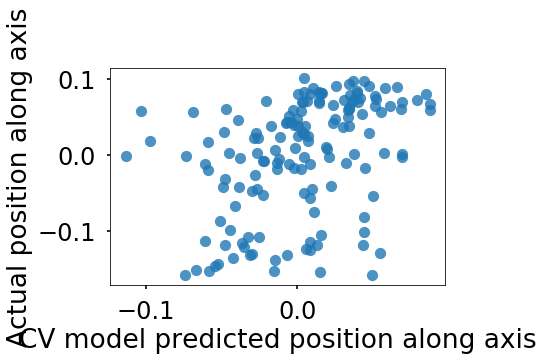

model cv score: r2 =  0.157477453916
running final model
final model fit r2 =  0.999988471493


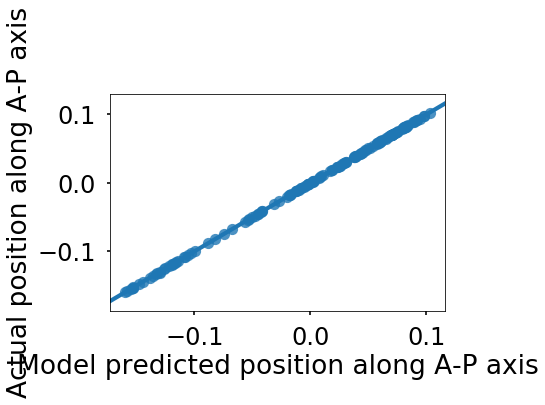

running sanity_check


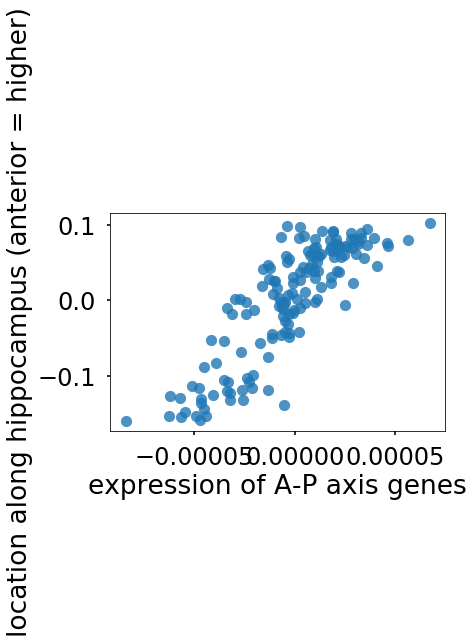

posterior and anterior 100 genes vs. y:  r2 = 0.717467898875, p = 9.77558250607e-43 




In [226]:
pls_reinder = PCA_LR_pipeline(xp[x_ind].values.T,
                            df.loc[good_ind].reinder_gradient, 
                          clf = PLSRegression(n_components=20),
                          pca=None,
                            cv_strategy='score', illustrative=True,
                           test_gene_num = [100],
                               sanity_check_style = 'model')

In [227]:
jnk = pandas.DataFrame()
jnk['betas'] = pls_reinder['betas'][:,0]
jnk['gene'] = probes.loc[:,'gene_symbol'].values
jnk.sort_values('betas',ascending=False)

betas                   gene
13560  0.000114                  GULP1
3619   0.000112                 MAGEA9
58508  0.000108  CUST_3844_PI416261804
26853  0.000107                   GHSR
21057  0.000106               C20orf85
10214  0.000104                  GPR83
38863  0.000101                 NEURL3
41969  0.000101                 TMEM71
24512  0.000101                  OVCH1
57949  0.000099            A_23_P43977
42447  0.000098                FAM110C
20802  0.000098                   TMC2
48748  0.000097           A_24_P798709
28063  0.000096                 ATP11C
40987  0.000096                  NR2F2
13855  0.000095                   SIX4
28484  0.000094                  OR4D9
40112  0.000094                  NR2F2
27208  0.000094                 IFNAR2
50871  0.000091           A_24_P307744
1912   0.000091                   GPR3
17124  0.000091                   IRX3
1078   0.000090                  EFNA2
23434  0.000090               C10orf72
20529  0.000089                  LYPD1
37807  0.000089               C1orf204
20397  0.000089                C1QTNF2
41214  0.000089                 TEX264
20507  0.000088                TM4SF19
9712   0.000088                 PLXNC1
...         ...                    ...
10144 -0.000094                   NEU3
2890  -0.000095                   KRT7
39699 -0.000095             AC007364.1
32888 -0.000095                   NPNT
27183 -0.000095                  CHRM2
54368 -0.000096           A_24_P920038
41805 -0.000097               TRAPPC6B
39861 -0.000097                C9orf45
22152 -0.000097                  HIPK4
9744  -0.000097                 HOXB13
22984 -0.000099                MOBKL2C
6341  -0.000099                      T
46046 -0.000100                   GRPR
32889 -0.000101                   NPNT
41173 -0.000101              LOC401433
49224 -0.000101           A_24_P911132
9450  -0.000101                  SPRY1
6488  -0.000102               TNFRSF1B
3447  -0.000102                    MN1
55301 -0.000104   CUST_566_PI417507815
6582  -0.000105                    TTR
23028 -0.000105                CLEC12A
53828 -0.000107           A_24_P390974
55027 -0.000109           LOC100127951
13849 -0.000111                  MYOZ2
41465 -0.000114                  BANK1
44590 -0.000114                  ACTN3
50299 -0.000115           A_23_P216581
17357 -0.000118                  REXO1
52676 -0.000120            A_23_P10885

[58692 rows x 2 columns]